scipy.signal.spectrogram(x, fs=1.0, window=('tukey', 0.25), nperseg=None, noverlap=None, nfft=None, detrend='constant', return_onesided=True, scaling='density', axis=-1, mode='psd')
用连续的傅立叶变换计算频谱图。

频谱图可以用作可视化非平稳信号频率成分随时间变化的一种方式。

参数：
x：array_like
测量值的时间序列

fs：float, 可选参数
x时间序列的采样频率。默认为1.0。

window：str 或 tuple 或 array_like, 可选参数
希望使用的窗口。如果window是字符串或元组，则将其传递给get_window生成窗口值，默认情况下为DFT-even。参考get_window有关窗口和必需参数的列表。如果窗口是数组，它将直接用作窗口，并且其长度必须为nperseg。默认为形状参数为0.25的Tukey窗口。

nperseg：int, 可选参数
每个段的长度。默认为无，但是如果window是str或tuple，则设置为256，如果window是数组，则设置为窗口的长度。

noverlap：int, 可选参数
段之间重叠的点数。如果没有，noverlap = nperseg // 8。默认为没有。

nfft：int, 可选参数
如果需要零填充的FFT，则使用的FFT的长度。如果为None，则FFT长度为nperseg。默认为无。

detrend：str 或 function 或 False, 可选参数
指定如何使每个段趋势消失。如果detrend是一个字符串，它将作为类型参数传递给detrend函数。如果它是一个函数，它将采用一个段并返回一个去趋势的段。如果detrend是假，不进行趋势消除。默认为‘constant’。

return_onesided：bool, 可选参数
如果为True，则返回真实数据的one-sided频谱。如果为False，则返回two-sided频谱。默认为True，但是对于复杂数据，始终返回two-sided频谱。

scaling：{ ‘density’, ‘spectrum’ }, 可选参数
如果x的单位为V且fs的单位为fs，则在计算Sxx的单位为V ** 2 /Hz的功率谱密度(‘density’)和计算Sxx的单位为V ** 2的功率谱(‘spectrum’)之间进行选择。赫兹。默认为‘density’。

axis：int, 可选参数
计算频谱图的轴；默认值位于最后一个轴上(即axis=-1)。

mode：str, 可选参数
定义期望的返回值类型。选项为[‘psd’，‘complex’，‘magnitude’，‘angle’，‘phase’]。 ‘complex’等效于stft没有填充或边界扩展。 ‘magnitude’返回STFT的绝对大小。 ‘angle’和‘phase’分别返回带展开和不展开的STFT的复角。

返回值：
f：ndarray
采样频率数组。

t：ndarray
细分时间数组。

Sxx：ndarray
x的频谱图。默认情况下，Sxx的最后一个轴对应于段时间。

注意：
适当的重叠量将取决于窗口的选择和您的要求。与韦尔奇(Welch)的方法相反，在整个方法中对整个数据流求平均，在计算频谱图时可能希望使用较小的重叠(或根本不重叠)，以保持各个段之间的统计独立性。因此，默认窗口是Tukey窗口，该窗口的两端各有1/8的长度重叠。

In [1]:
import os
import soundfile  
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
dataFolder = "F:\Jupyter Projects\ANC\Data"

PP_RefPath = os.path.join(dataFolder, 'PP_Ref.wav')
PP_ErrPath = os.path.join(dataFolder, 'PP_Err.wav')
PP_RefData, sample_rate = soundfile.read(PP_RefPath)
PP_ErrData, _ = soundfile.read(PP_ErrPath)
PPlength = PP_RefData.shape[0] / sample_rate

spkPath = os.path.join(dataFolder, 'White Noise.wav')
errPath = os.path.join(dataFolder, 'SP_err.wav')
spkData, spk_sample_rate = soundfile.read(spkPath) 
errData, _ = soundfile.read(errPath)
spklength = spkData.shape[0] / sample_rate

frameLength = 16384
numFrames_PP = int(PP_RefData.size//frameLength)
numFrames_err = int(errData.size//frameLength)
numFrames_spk = int(spkData.size//frameLength)
numFrames = min(numFrames_PP, numFrames_err, numFrames_spk)

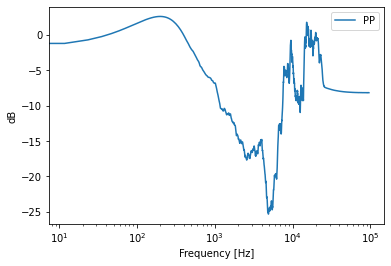

In [2]:
#PP建模

f, _, errPP =  signal.spectrogram(PP_ErrData[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),
                                   nperseg=16384, noverlap=3/4*16384, mode='complex')
_, _, refPP =  signal.spectrogram(PP_RefData[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),
                                   nperseg=16384, noverlap=3/4*16384, mode='complex')
PPErr = 20*np.log10(np.mean(np.abs(errPP), 1))
PPRef = 20*np.log10(np.mean(np.abs(refPP), 1))
PP = signal.savgol_filter(PPErr-PPRef, 73, 3) #savgol_filter平滑曲线
plt.plot(f, PP, label="PP")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()


[0.00214409 0.00178637 0.00107219 ... 0.00274795 0.00127891 0.00010004]


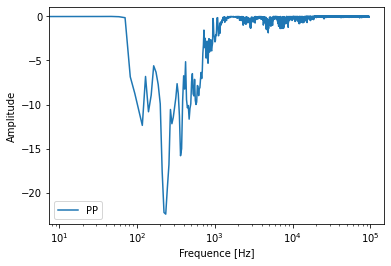

In [3]:
#求信号相干性
f, Cxx = signal.coherence(PP_ErrData[:numFrames*frameLength-1],PP_RefData[:numFrames*frameLength-1], sample_rate, window='hann', nperseg=frameLength)
print(Cxx)
Cxx = 20*np.log10(np.clip(np.abs(1-Cxx), 1e-20, 1e100))
plt.plot(f, Cxx, label="PP")
plt.legend()
plt.xscale('log')
plt.xlabel("Frequence [Hz]")
plt.ylabel("Amplitude")
plt.show()

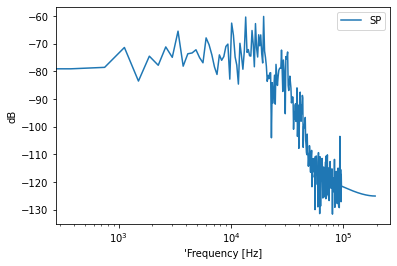

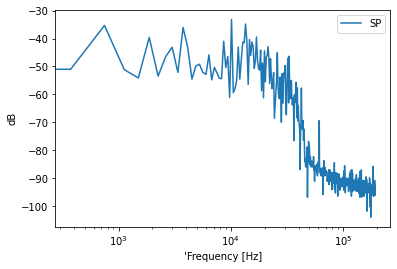

In [4]:
#求SP的脉冲响应，取前4096阶作为FIR滤波器,但是与spectrogram函数对应不上，自己手动分帧求fft好像存在错误
spFreq = np.zeros(frameLength, dtype='complex') #FFT的频率精度为192000/16384
errFreq = np.zeros(frameLength, dtype='complex') 
spkFreq = np.zeros(frameLength, dtype='complex') 
num_cut = 4
noverlop = 3/4
nnum = int((numFrames-1)/(1-noverlop)+1)
nLength = int(frameLength*(1-noverlop))
for i in range(1, nnum):    
    errFreq = np.fft.fft(errData[i*nLength:i*nLength+frameLength])#[:frameLength//num_cut] #16384/4=4096，只求4096阶的FIR
    spkFreq = np.fft.fft(spkData[i*nLength:i*nLength+frameLength])#[:frameLength//num_cut]
    spFreq[:frameLength//num_cut] += (errFreq/spkFreq)[:frameLength//num_cut]
spFreq = spFreq/nnum
spFreq[0] = 0 # 0Hz为直流分量
spFreq[frameLength//2:frameLength-1] = np.flipud(np.conj(spFreq[1:frameLength//2])) #共轭对称
spModel = np.real(np.fft.ifft(spFreq))[:frameLength//num_cut] #反变换的实部即是脉冲响应，取4096阶
w, h = signal.freqz(spModel, 1) #求FIR的频响

plt.plot(sample_rate*w/np.pi, 20*np.log10(np.abs(h)), label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()


num_cut = 2
noverlop = 2/4
nnum = int((numFrames-1)/(1-noverlop)+1)
nLength = int(frameLength*(1-noverlop))
for i in range(1, nnum):    
    errFreq += np.fft.fft(errData[i*nLength:i*nLength+frameLength])#[:frameLength//num_cut] #16384/4=4096，只求4096阶的FIR
    spkFreq += np.fft.fft(spkData[i*nLength:i*nLength+frameLength])#[:frameLength//num_cut]
spFreq[:frameLength//num_cut] = (errFreq/spkFreq)[:frameLength//num_cut]
# spFreq = spFreq/nnum #不用除以nnum，因为errFreq/spkFreq已经抵消了除数
spFreq[0] = 0 # 0Hz为直流分量
spFreq[frameLength//2:frameLength] = np.flipud(np.conj(spFreq[1:frameLength//2+1])) #共轭对称
spModel = np.real(np.fft.ifft(spFreq))[:frameLength//num_cut] #反变换的实部即是脉冲响应，取4096阶
w, h = signal.freqz(spModel, 1) #求FIR的频响

plt.plot(sample_rate*w/np.pi, 20*np.log10(np.abs(h)), label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

[ 3.36780350e-07+0.j  1.32307968e-07+0.j -7.87672402e-07+0.j ...
 -5.29391289e-07+0.j -2.20243145e-07+0.j  9.42999310e-07+0.j]


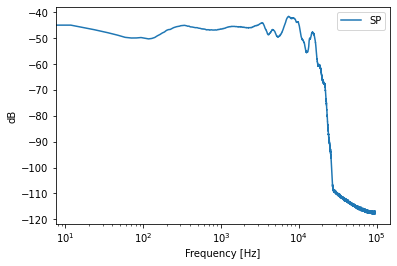

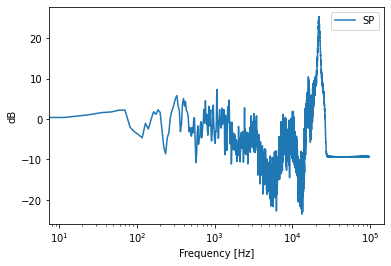

In [5]:
#SP建模
f, errPhase, errSP =  signal.spectrogram(errData[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),
                                   nperseg=16384, noverlap=3/4*16384, mode='complex')
_, _, spkSP =  signal.spectrogram(spkData[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),
                                   nperseg=16384, noverlap=3/4*16384, mode='complex')
SPErr = 20*np.log10(np.mean(np.abs(errSP), 1))
SPSpk = 20*np.log10(np.mean(np.abs(spkSP), 1))
SP = SPErr-SPSpk
print(errSP[0])
plt.plot(f, SPErr-SPSpk, label="SP")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()

#隔离度SPRef-SPErr,这里没有录SPRef,所以暂时用PPRef表示
plt.plot(f, SPErr-PPRef, label="SP")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()

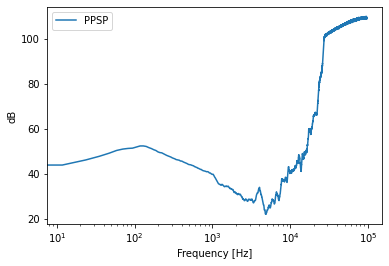

In [6]:
#PP/SP
PPSP = PP-SP
plt.plot(f, PPSP, label="PPSP")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()

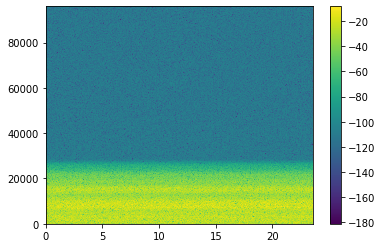

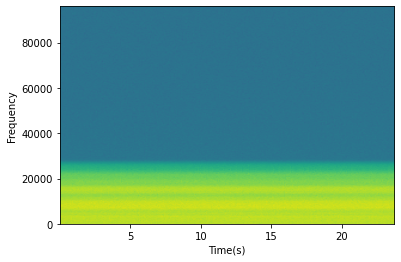

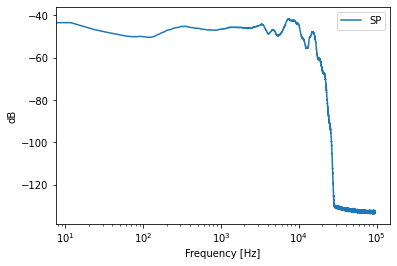

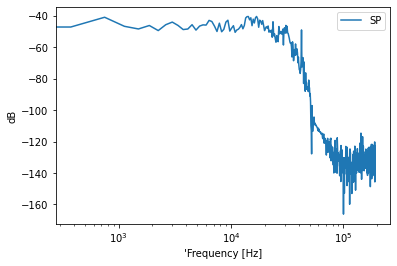

In [7]:
#FFT与spectrogram的关系，为什么求出来的差别这么大
# import librosa
# import numpy as np
# import matplotlib.pyplot as plt

#计算每帧对应的时间
def FrameTimeC(frameNum, frameLen, inc, fs):
    ll = np.array([i for i in range(frameNum)])
    return ((ll - 1) * inc + frameLen / 2) / fs

#分帧函数
def enframe(x, win, inc=None):
    nx = len(x)
    if isinstance(win, list) or isinstance(win, np.ndarray):
        nwin = len(win)
        nlen = nwin  # 帧长=窗长
    elif isinstance(win, int):
        nwin = 1
        nlen = win  # 设置为帧长
    if inc is None:
        inc = nlen
    nf = int((nx - nlen + inc) // inc)
    frameout = np.zeros((nf, nlen))
    indf = np.multiply(inc, np.array([i for i in range(nf)])) #数组和矩阵对应位置相乘，输出与相乘数组/矩阵的大小一致
    for i in range(nf):
        frameout[i, :] = x[int(indf[i]):int(indf[i]) + nlen]
    if isinstance(win, list) or isinstance(win, np.ndarray):
        frameout = np.multiply(frameout, np.array(win))
    return frameout

#加窗
def hanning_window(N):
    nn = [i for i in range(N)]
    return 0.5 * (1 - np.cos(np.multiply(nn, 2 * np.pi) / (N - 1)))

def rectangle_window(N): #矩形窗会造成频谱泄露
    nn = [1 for i in range(N)]
    return nn

#短时傅里叶变换
def STFFT(x, win, nfft, inc):
    xn = enframe(x, win, inc)
    xn = xn.T
    y = np.fft.fft(xn, nfft, axis=0)
    return y[:nfft // 2, :]


nfft = frameLength
win = hanning_window(frameLength)
# inc = frameLength*3/4
inc = frameLength*1/2
errData_y = STFFT(errData[:numFrames*frameLength-1], win, nfft, inc)
spkData_y = STFFT(spkData[:numFrames*frameLength-1], win, nfft, inc)

FrequencyScale = [i * sample_rate / frameLength for i in range(frameLength // 2)] #频率刻度
frameTime = FrameTimeC(errData_y.shape[1], frameLength, inc, sample_rate) #每帧对应的时间
LogarithmicSpectrogramData=20*np.log10((np.abs(errData_y))) #取对数后的数据

#np.savetxt("SpectrogramData.txt",LogarithmicSpectrogramData)

plt.pcolormesh(frameTime, FrequencyScale,LogarithmicSpectrogramData)
plt.colorbar()
#plt.savefig('语谱图22.png')
plt.show()

#掉包实现
plt.specgram(errData[:numFrames*frameLength-1], NFFT=nfft, Fs=sample_rate, window=np.hanning(frameLength))
plt.ylabel('Frequency')
plt.xlabel('Time(s)')
#plt.savefig('语谱图11.png')
plt.show()

SPErr = 20*np.log10(np.mean(np.abs(errData_y), 1))
SPSpk = 20*np.log10(np.mean(np.abs(spkData_y), 1))
SP = SPErr-SPSpk
plt.plot(FrequencyScale, SP, label="SP")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()

num_cut = 2
spFreq = np.zeros(frameLength, dtype='complex') 
spFreq[:frameLength//2] = ( np.mean(errData_y, 1)/np.mean(spkData_y, 1) )
spFreq[frameLength//2:frameLength-1] = np.flipud(np.conj(spFreq[1:frameLength//2])) #共轭对称
spModel = np.real(np.fft.ifft(spFreq))[:frameLength//num_cut] #反变换的实部即是脉冲响应，取4096阶
w, h = signal.freqz(spModel, 1) #求FIR的频响

plt.plot(sample_rate*w/np.pi, 20*np.log10(np.abs(h)), label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

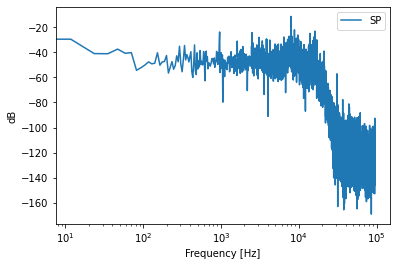

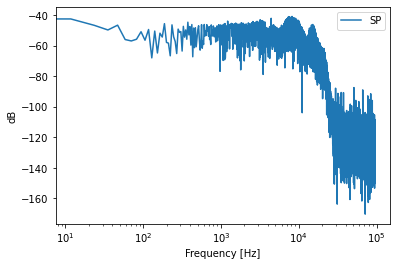

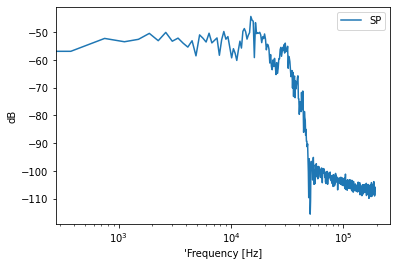

In [8]:
#求SP的脉冲响应，取前4096阶作为FIR滤波器
spFreq = np.zeros(frameLength, dtype='complex') #FFT的频率精度为192000/16384
errFreq = np.zeros(frameLength, dtype='complex') 
spkFreq = np.zeros(frameLength, dtype='complex') 
num_cut = 2
noverlop = 3/4
nnum = int((numFrames-1)/(1-noverlop)+1)
nLength = int(frameLength*(1-noverlop))
for i in range(1, nnum):   #为什么累加才能对应上 ？？？
    errFreq += np.fft.fft(errData[i*nLength:i*nLength+frameLength])#[:frameLength//num_cut] #16384/4=4096，只求4096阶的FIR
    spkFreq += np.fft.fft(spkData[i*nLength:i*nLength+frameLength])#[:frameLength//num_cut]
    spFreq[:frameLength//num_cut] += (errFreq/spkFreq)[:frameLength//num_cut]
spFreq = spFreq/nnum
errFreq = errFreq/nnum
spkFreq = spkFreq/nnum
SPFreq_y = 20*np.log10(np.abs(spFreq[:frameLength//num_cut]))

SPErr = 20*np.log10(np.abs(errFreq[:frameLength//num_cut])) 
SPSpk = 20*np.log10(np.abs(spkFreq[:frameLength//num_cut]))
SP = SPErr-SPSpk
plt.plot(FrequencyScale, SP, label="SP")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()

plt.plot(FrequencyScale, SPFreq_y, label="SP")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()

spFreq[0] = 0 # 0Hz为直流分量
spFreq[frameLength//2:frameLength-1] = np.flipud(np.conj(spFreq[1:frameLength//2])) #共轭对称
spModel = np.real(np.fft.ifft(spFreq))[:frameLength//num_cut] #反变换的实部即是脉冲响应，取4096阶
w, h = signal.freqz(spModel, 1) #求FIR的频响
plt.plot(sample_rate*w/np.pi, 20*np.log10(np.abs(h)), label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

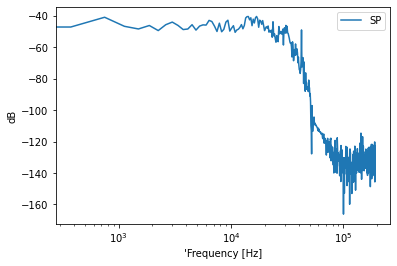

In [9]:
#分帧函数
def enframe(x, win, inc=None):
    nx = len(x)
    if isinstance(win, list) or isinstance(win, np.ndarray): #isinstance判断数据属性
        nwin = len(win)
        nlen = nwin  # 帧长=窗长
    elif isinstance(win, int):
        nwin = 1
        nlen = win  # 设置为帧长
    if inc is None:
        inc = nlen
    nf = int((nx - nlen + inc) // inc)
    frameout = np.zeros((nf, nlen))
    indf = np.multiply(inc, np.array([i for i in range(nf)])) #数组和矩阵对应位置相乘，输出与相乘数组/矩阵的大小一致
    for i in range(nf):
        frameout[i, :] = x[int(indf[i]):int(indf[i]) + nlen]
    if isinstance(win, list) or isinstance(win, np.ndarray):
        frameout = np.multiply(frameout, np.array(win)) #加窗，利用了广播特性
    return frameout

#加窗
def hanning_window(N):
    nn = [i for i in range(N)]
    return 0.5 * (1 - np.cos(np.multiply(nn, 2 * np.pi) / (N - 1)))

def rectangle_window(N):
    nn = [1 for i in range(N)]
    return nn

nfft = frameLength
win = hanning_window(frameLength)
# win = rectangle_window(frameLength)
# inc = frameLength*3/4
inc = frameLength*1/2
errData_xn = enframe(errData[:numFrames*frameLength-1], win, inc)
errData_xn = errData_xn.T
errData_y = np.fft.fft(errData_xn, nfft, axis=0)

spkData_xn = enframe(spkData[:numFrames*frameLength-1], win, inc)
spkData_xn = spkData_xn.T
spkData_y = np.fft.fft(spkData_xn, nfft, axis=0)

num_cut = 2
spFreq = np.zeros(frameLength, dtype='complex') 
spFreq[:frameLength//num_cut] = ( np.mean(errData_y, 1)/np.mean(spkData_y, 1) )[:frameLength//num_cut]
spFreq[frameLength//2:frameLength-1] = np.flipud(np.conj(spFreq[1:frameLength//2])) #共轭对称
spModel = np.real(np.fft.ifft(spFreq))[:frameLength//num_cut] #反变换的实部即是脉冲响应，取4096阶
w, h = signal.freqz(spModel, 1) #求FIR的频响
plt.plot(sample_rate*w/np.pi, 20*np.log10(np.abs(h)), label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

errData_xn = errData_xn.T
spkData_xn = spkData_xn.T

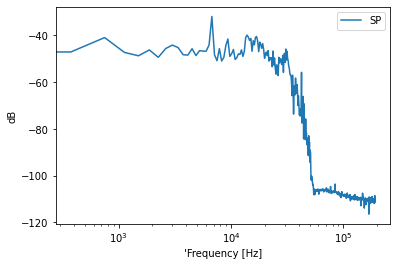

In [10]:
#求SP的脉冲响应，取前4096阶作为FIR滤波器,但是与spectrogram函数对应不上，自己手动分帧求fft好像存在错误
spFreq = np.zeros(frameLength, dtype='complex') #FFT的频率精度为192000/16384
errFreq = np.zeros(frameLength, dtype='complex') 
spkFreq = np.zeros(frameLength, dtype='complex') 
for i in range(1, len(errData_xn)):    
    errFreq += np.fft.fft(errData_xn[i])#[:frameLength//num_cut] #16384/4=4096，只求4096阶的FIR
    spkFreq += np.fft.fft(spkData_xn[i])#[:frameLength//num_cut]
spFreq[:frameLength//num_cut] = (errFreq/spkFreq)[:frameLength//num_cut]
# spFreq = spFreq/numFrames
spFreq[0] = 0 # 0Hz为直流分量
spFreq[frameLength//2:frameLength-1] = np.flipud(np.conj(spFreq[1:frameLength//2])) #共轭对称
spModel = np.real(np.fft.ifft(spFreq))[:frameLength//num_cut] #反变换的实部即是脉冲响应，取4096阶
w, h = signal.freqz(spModel, 1) #求FIR的频响

plt.plot(sample_rate*w/np.pi, 20*np.log10(np.abs(h)), label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

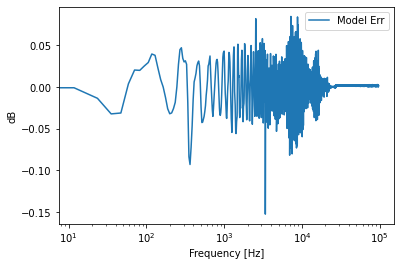

In [11]:
#建模精度(errAfterSPData-errData*SPModel)/errData
errAfterSPData = signal.lfilter(spModel, 1, errData[:numFrames*frameLength-1])

res = errAfterSPData[:numFrames*frameLength-1] -errData[:numFrames*frameLength-1]
f, _, errSP =  signal.spectrogram(errData[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),
                                   nperseg=16384, noverlap=3/4*16384, mode='complex')
_, _, Res =  signal.spectrogram(res[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),
                                   nperseg=16384, noverlap=3/4*16384, mode='complex')
Res = 20*np.log10(np.mean(np.abs(Res), 1))
SPErr = 20*np.log10(np.mean(np.abs(errSP), 1))
plt.plot(f, Res-SPErr, label="Model Err")
plt.legend()
plt.xscale('log')
plt.ylabel('dB')
plt.xlabel('Frequency [Hz]')
plt.show()

[ 2.67701882e-04  5.35403765e-04  2.67701882e-04  1.00000000e+00
 -1.99889647e+00  9.99967281e-01]


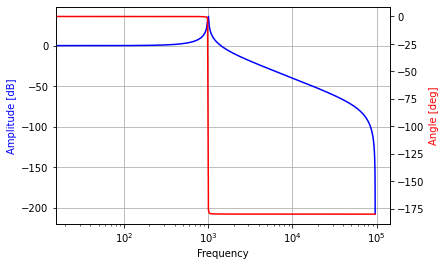

In [12]:
import numpy as np
from scipy import signal as sg
import matplotlib.pyplot as plt

def low_pass_filter_iir(f0, Q=1., fs=192000):
    """
    根据PEQ参数设计二阶IIR数字低通滤波器，默认采样率192k
    :param f0: 中心频率
    :param Q: 峰值带宽
    :param fs: 系统采样率
    :return: 双二阶滤波器系数
    """
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = (1 - np.cos(w0)) / 2
    b1 = 1 - np.cos(w0)
    b2 = (1 - np.cos(w0)) / 2
    a0 = 1 + alpha
    a1 = -2 * np.cos(w0)
    a2 = 1 - alpha
    b = np.array([b0, b1, b2])
    a = np.array([a0, a1, a2])
    h = np.hstack((b / a[0], a / a[0]))

    return h

def high_pass_filter_iir(f0, Q=1., fs=192000):
    """
    根据PEQ参数设计二阶IIR数字高通滤波器，默认采样率192k
    :param f0: 中心频率
    :param Q: 峰值带宽
    :param fs: 系统采样率
    :return: 双二阶滤波器系数
    """
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = (1 + np.cos(w0)) / 2
    b1 = -1 - np.cos(w0)
    b2 = (1 + np.cos(w0)) / 2
    a0 = 1 + alpha
    a1 = -2 * np.cos(w0)
    a2 = 1 - alpha
    b = np.array([b0, b1, b2])
    a = np.array([a0, a1, a2])

    h = np.hstack((b / a[0], a / a[0]))

    return h


def low_shelf_filter_iir(f0, gain=0., Q=1., fs=192000):
    """
    根据PEQ参数设计二阶IIR数字low shelf滤波器，默认采样率192k
    :param f0: 中心频率
    :param gain: 峰值增益
    :param Q: 峰值带宽
    :param fs: 系统采样率
    :return: 双二阶滤波器系数
    """
    A = np.sqrt(10 ** (gain / 20))
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = A * ((A + 1) - (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
    b1 = 2 * A * ((A - 1) - (A + 1) * np.cos(w0))
    b2 = A * ((A + 1) - (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha)
    a0 = (A + 1) + (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha
    a1 = -2 * ((A - 1) + (A + 1) * np.cos(w0))
    a2 = (A + 1) + (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha

    b = np.array([b0, b1, b2])
    a = np.array([a0, a1, a2])

    h = np.hstack((b / a[0], a / a[0]))

    return h


def high_shelf_filter_iir(f0, gain=0., Q=1., fs=192000):
    """
    根据PEQ参数设计二阶IIR数字high shelf滤波器，默认采样率192k
    :param f0: 中心频率
    :param gain: 峰值增益
    :param Q: 峰值带宽
    :param fs: 系统采样率
    :return: 双二阶滤波器系数
    """
    A = np.sqrt(10 ** (gain / 20))
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = A * ((A + 1) + (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
    b1 = -2 * A * ((A - 1) + (A + 1) * np.cos(w0))
    b2 = A * ((A + 1) + (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha)
    a0 = (A + 1) - (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha
    a1 = 2 * ((A - 1) - (A + 1) * np.cos(w0))
    a2 = (A + 1) - (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha

    b = np.array([b0, b1, b2])
    a = np.array([a0, a1, a2])

    h = np.hstack((b / a[0], a / a[0]))

    return h


def peak_filter_iir(f0, gain=0., Q=1., fs=192000):
    """
    根据PEQ参数设计二阶IIR数字peak滤波器，默认采样率192k
    :param f0: 中心频率
    :param gain: 峰值增益，正值为peak filter,负值为notch filter
    :param Q: 峰值带宽
    :param fs: 系统采样率
    :return: 双二阶滤波器系数
    """
    A = np.sqrt(10 ** (gain / 20))
    w0 = 2 * np.pi * f0 / fs
    alpha = np.sin(w0) / (2 * Q)

    b0 = 1 + alpha * A
    b1 = -2 * np.cos(w0)
    b2 = 1 - alpha * A
    a0 = 1 + alpha / A
    a1 = -2 * np.cos(w0)
    a2 = 1 - alpha / A
    b = np.array([b0, b1, b2])
    a = np.array([a0, a1, a2])

    h = np.hstack((b / a[0], a / a[0]))

    return h

if __name__ == '__main__':
    f0 = 1000
    Q = 1000
    fs = 192000
    gain = 0

#     sos = high_shelf_filter_iir(f0, gain, Q, fs)
    sos = low_pass_filter_iir(f0, Q, fs)
    print(sos)
    w, h = sg.sosfreqz(sos, worN=4096, fs=fs)

    fig, ax1 = plt.subplots()
    ax1.semilogx(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency')
    ax1.grid()
    ax2 = ax1.twinx()
    ax2.semilogx(w, np.angle(h, deg=True), 'r')
    ax2.set_ylabel('Angle [deg]', color='r')
    ax2.axis('tight')
    plt.show()


In [13]:
import numpy as np
from scipy import signal
#IIR类，EQ、Biquad相互转换
class IIRFilter(object):    
    def __init__(self, eqType, eqParam):  
        self.fs = 192000
        self.nfft = 16384
        self.numerator = np.array([])
        self.denominator = np.array([])
        self.sos = np.array([])
        self.eqType = eqType
        self.eqParam = eqParam  #[f0, gain, Q]
        if self.eqType != 'Biquad':
            self.eqParam[2] /= 1000
        if self.eqType == 'LowPass':
            self.low_pass_filter_iir()
        elif self.eqType == 'HighPass':
            self.high_pass_filter_iir()
        elif self.eqType == 'LowShelf':
            self.low_shelf_filter_iir()
        elif self.eqType == 'HighShelf':
            self.high_shelf_filter_iir()
        elif self.eqType == 'Peaking':
            self.peak_filter_iir()
        elif self.eqType == 'Biquad':
            self.numerator = eqParam[0]
            self.denominator= eqParam[1]
    def low_pass_filter_iir(self):
        w0 = 2 * np.pi * self.eqParam[0] / self.fs
        alpha = np.sin(w0) / (2 * self.eqParam[2])

        b0 = (1 - np.cos(w0)) / 2
        b1 = 1 - np.cos(w0)
        b2 = (1 - np.cos(w0)) / 2
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha
        self.numerator = np.array([b0, b1, b2])/a0
        self.denominator = np.array([a0, a1, a2])/a0
        self.sos = np.hstack((self.numerator, self.denominator))
        
    def high_pass_filter_iir(self):
        w0 = 2 * np.pi * self.eqParam[0] / self.fs
        alpha = np.sin(w0) / (2 * self.eqParam[2])

        b0 = (1 + np.cos(w0)) / 2
        b1 = -1 - np.cos(w0)
        b2 = (1 + np.cos(w0)) / 2
        a0 = 1 + alpha
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha
        self.numerator = np.array([b0, b1, b2])/a0
        self.denominator = np.array([a0, a1, a2])/a0
        self.sos = np.hstack((self.numerator, self.denominator))
        
    def low_shelf_filter_iir(self):
        A = np.sqrt(10 ** (self.eqParam[1] / 20))
        w0 = 2 * np.pi * self.eqParam[0] / fs
        alpha = np.sin(w0) / (2 * self.eqParam[2])

        b0 = A * ((A + 1) - (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
        b1 = 2 * A * ((A - 1) - (A + 1) * np.cos(w0))
        b2 = A * ((A + 1) - (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha)
        a0 = (A + 1) + (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha
        a1 = -2 * ((A - 1) + (A + 1) * np.cos(w0))
        a2 = (A + 1) + (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha
        self.numerator = np.array([b0, b1, b2])/a0
        self.denominator = np.array([a0, a1, a2])/a0
        self.sos = np.hstack((self.numerator, self.denominator))
        
    def high_shelf_filter_iir(self):
        A = np.sqrt(10 ** (self.eqParam[1] / 20))
        w0 = 2 * np.pi * self.eqParam[0] / self.fs
        alpha = np.sin(w0) / (2 * self.eqParam[0])

        b0 = A * ((A + 1) + (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha)
        b1 = -2 * A * ((A - 1) + (A + 1) * np.cos(w0))
        b2 = A * ((A + 1) + (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha)
        a0 = (A + 1) - (A - 1) * np.cos(w0) + 2 * np.sqrt(A) * alpha
        a1 = 2 * ((A - 1) - (A + 1) * np.cos(w0))
        a2 = (A + 1) - (A - 1) * np.cos(w0) - 2 * np.sqrt(A) * alpha

        b = np.array([b0, b1, b2])
        a = np.array([a0, a1, a2])
        self.numerator = np.array([b0, b1, b2])/a0
        self.denominator = np.array([a0, a1, a2])/a0
        self.sos = np.hstack((self.numerator, self.denominator))

    def peak_filter_iir(self):
        A = np.sqrt(10 ** (self.eqParam[0] / 20))
        w0 = 2 * np.pi * self.eqParam[1] / self.fs
        alpha = np.sin(w0) / (2 * self.eqParam[2])

        b0 = 1 + alpha * A
        b1 = -2 * np.cos(w0)
        b2 = 1 - alpha * A
        a0 = 1 + alpha / A
        a1 = -2 * np.cos(w0)
        a2 = 1 - alpha / A
        self.numerator = np.array([b0, b1, b2])/a0
        self.denominator = np.array([a0, a1, a2])/a0
        self.sos = np.hstack((self.numerator, self.denominator))
        
    def FreqResponse(self):
        f = np.linspace(0, self.fs, self.nfft)
        w, h = signal.freqz(self.numerator, self.denominator, worN=self.nfft, fs=self.fs)
        s = 20*np.log10(np.abs(h)+1e-5)
        phi = w*180/np.pi
        return f, s, phi


[0.00000000e+00 1.17194653e+01 2.34389306e+01 ... 1.91976561e+05
 1.91988281e+05 1.92000000e+05]
16384
16384
16384


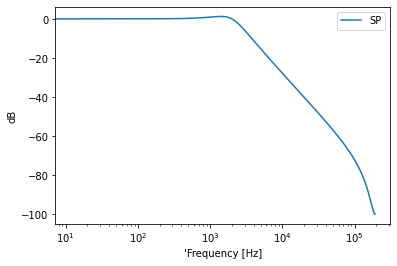

In [14]:
import matplotlib.pyplot as plt
lowPass = IIRFilter('LowPass', [1000, 0, 1000])
f, s, phi = lowPass.FreqResponse()
print(f)
print(f.size)
print(s.size)
print(phi.size)

plt.plot(f, s, label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

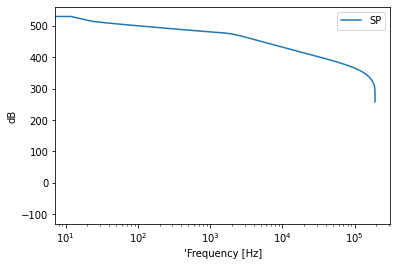

[ 2.63397204e-04  5.26794409e-04  2.63397204e-04  8.18123083e+21
 -1.99999997e+00 -8.18123083e+21]


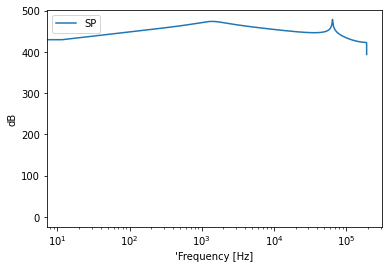

In [15]:
import matplotlib.pyplot as plt
lowPass = IIRFilter('LowPass', [1000, 0, 1000])
highPass = IIRFilter('Peaking', [1000, 5, 100])
f, s1, phi1 = lowPass.FreqResponse()
_, s2, phi2 = highPass.FreqResponse()

plt.plot(f, s1+s2, label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

numerator = np.concatenate((lowPass.numerator,highPass.numerator),axis=0)
denominator = np.concatenate((lowPass.denominator,highPass.denominator),axis=0)
# numerator = np.vstack((lowPass.numerator,highPass.numerator)).T
# denominator = np.vstack((lowPass.denominator,highPass.denominator)).T
print(numerator)
f = np.linspace(0, 192000, 16384)
w, h = signal.freqz(numerator, denominator, worN=16384, fs=192000)
s = 20*np.log10(np.abs(h)+1e-5)
phi = w*180/np.pi
plt.plot(f, s, label="SP")
plt.legend()
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

In [16]:
#直接I型滤波器
def FilteringI(numerator, denominator, data, zi=None):
    numN = len(numerator)
    numD = len(denominator)
    res = np.zeros(len(data))
    if numN!=0 and numD!=0:
        if denominator[0]!=1:
            numerator /= denominator[0]
            denominator /= denominator[0] 
        if zi is None:
            zi = np.zeros(numN+numD)
        for i in range(len(data)):
            zi[1:numN] = zi[:numN-1] #zi表示延时, 移位表示时间+1
            zi[0] = data[i] 
            zi[numN+1:] = zi[numN:-2]
            zi[numN] = np.dot(zi[:numN], numerator)
            res[i] = np.dot(zi[numN:], denominator)
            zi[numN] = res[i]
    return res, zi

#直接II型滤波器
def FilteringII(numerator, denominator, data, zi=None):
    print(numerator)
    print(denominator)
    numN = len(numerator)
    numD = len(denominator)
    delay_length = max(numN, numD)
    print(delay_length)
    res = np.zeros(len(data))
    if numN!=0 and numD!=0:
        if denominator[0]!=1:
            numerator /= denominator[0]
            denominator /= denominator[0] 
        if zi is None:
            zi = np.zeros(delay_length)
        for i in range(len(data)):
            zi[1:delay_length] = zi[:delay_length-1] #zi表示延时, 移位表示时间+1
            zi[0] = data[i] + np.dot(zi[1:numD], denominator[1:numD])
            res[i] = np.dot(zi[:numN], numerator)
    return res, zi
        
class FilterSet(object):    
    def __init__(self):
        self.biquadSet = []
        self.biquadSum = 0
        self.gainDB = 0
    def AddBiquad(self, biquad):
        self.biquadSet.append(biquad)
        self.biquadSum += 1
    def DelBiquad(self, index):
        if self.biquadSum>index:
            self.biquadSum.pop(index-1)
            self.biquadSum -= 1
    def Filtering(self, filterData):
        afterFilterData = np.zeros(len(filterData))
        afterFilterData = filterData
        if self.biquadSum!=0:
            for sub in self.biquadSet:
                afterFilterData = signal.lfilter(sub.numerator, sub.denominator, afterFilterData)
        return afterFilterData
    def FilteringI(self, filterData, delay=None):
        afterFilterData = np.zeros(len(filterData))
        afterFilterData = filterData
        if delay is None:
            delay = []
            for i in range(self.biquadSum):
                delay.append(None)
        for i in range(self.biquadSum):
            afterFilterData, delay[i] = FilteringII(self.biquadSet[i].numerator, self.biquadSet[i].denominator, afterFilterData, delay[i]) 
        #每次只滤波一个数据
#         for i in range(len(filterData)):
#             for j in range(self.biquadSum):
#                 afterFilterData[i], delay[j] = FilteringI(self.biquadSet[j].numerator, self.biquadSet[j].denominator, [afterFilterData[i]], delay[j])         
        return afterFilterData, delay
    def FilteringII(self, filterData, delay=None):
        afterFilterData = np.zeros(len(filterData))
        afterFilterData = filterData
        if delay==None:
            delay = []
            for i in range(self.biquadSum):
                delay.append(None)
        #每个滤波器一下滤波所有数据, 该方法不可取
#         for i in range(self.biquadSum):
#             afterFilterData, delay[i] = FilteringII(self.biquadSet[i].numerator, self.biquadSet[i].denominator, afterFilterData, delay[i]) 
                #每次只滤波一个数据
        for i in range(len(afterFilterData)):
            for j in range(self.biquadSum):
                afterFilterData[i], delay[j] = FilteringI(self.biquadSet[j].numerator, self.biquadSet[j].denominator, [afterFilterData[i]], delay[j])        
        return afterFilterData, delay
    def SelfPlot(self):
        f = np.linspace(0, 192000, 16384)
        s = np.zeros(16384)
        phi = np.zeros(16384)
        for sub in self.biquadSet:
            w, h = signal.freqz(sub.numerator, sub.denominator, worN=16384, fs=192000)
            s += 20*np.log10(np.abs(h)+1e-5)
#             phi += w*180/np.pi
#         plt.plot(f, s, label="SP")
#         plt.legend()
#         plt.xscale('log')
#         plt.xlabel("'Frequency [Hz]")
#         plt.ylabel("dB")
#         plt.show()
        return f, s
    def gainDB2K(self, gainDB):
        self.gainDB = gainDB
        gainK = pow(10, gainDB/20)
        daltaK = gainK/self.biquadSum
        for sub in self.biquadSet:
            sub.numerator *= daltaK
    
#         plt.plot(f, s, label="SP")
#         plt.legend()
#         plt.xscale('log')
#         plt.xlabel("'Frequency [Hz]")
#         plt.ylabel("dB")
#         plt.show()

In [17]:
filter1 = IIRFilter('LowShelf', [1000, 10, 1000])
filter2 = IIRFilter('LowShelf', [1000, 5, 2000])
FF = FilterSet()
FF.AddBiquad(filter1)
FF.AddBiquad(filter2)
FF.gainDB2K(20)
FF.SelfPlot()

(array([0.00000000e+00, 1.17194653e+01, 2.34389306e+01, ...,
        1.91976561e+05, 1.91988281e+05, 1.92000000e+05]),
 array([42.95881544, 42.95914896, 42.96014948, ..., 27.95883492,
        27.95883492, 27.95883492]))

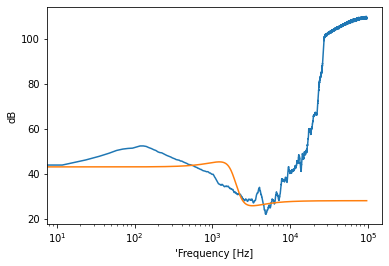

In [18]:
#FF simulation
def FFSimulation(FF, PP_RefData, PP_ErrData, spModel):
    antiFF = FF.Filtering(PP_RefData)
    anti = signal.lfilter(spModel, [1], antiFF)
    res = PP_ErrData + anti
    f, _, res =  signal.spectrogram(res, fs=sample_rate, window=signal.get_window('hamming', 16384),nperseg=16384, \
                                    noverlap=3/4*16384, mode='complex')
    Res = 20*np.log10(np.mean(np.abs(res), 1))
    return f, Res

def FFSimulationI(FF, PP_RefData, PP_ErrData, spModel):
    antiFF, _ = FF.FilteringI(PP_RefData, None)
#     anti, _ = FilteringI(spModel, [1], antiFF, None)
    anti = signal.lfilter(spModel, [1], antiFF)
    res = PP_ErrData + anti
    res = anti
    f, _, res =  signal.spectrogram(res, fs=sample_rate, window=signal.get_window('hamming', 16384),nperseg=16384, \
                                    noverlap=3/4*16384, mode='complex')
    Res = 20*np.log10(np.mean(np.abs(res), 1))
    return f, Res

def FFSimulationII(FF, PP_RefData, PP_ErrData, spModel):
    antiFF, _ = FF.FilteringII(PP_RefData, None)
    anti = signal.lfilter(spModel, [1], antiFF)
#     anti, _ = FilteringII(spModel, [1], antiFF, None)
    res = PP_ErrData + anti
    res = anti
    f, _, res =  signal.spectrogram(res, fs=sample_rate, window=signal.get_window('hamming', 16384),nperseg=16384, \
                                    noverlap=3/4*16384, mode='complex')
    Res = 20*np.log10(np.mean(np.abs(res), 1))
    return f, Res

def FFSimulation(FF, PP_RefData, PP_ErrData, spModel):
    antiFF = FF.Filtering(PP_RefData)
    anti = signal.lfilter(spModel, [1], antiFF)
    res = PP_ErrData + anti
    f, _, res =  signal.spectrogram(res, fs=sample_rate, window=signal.get_window('hamming', 16384),nperseg=16384, \
                                    noverlap=3/4*16384, mode='complex')
    Res = 20*np.log10(np.mean(np.abs(res), 1))
    return f, Res

f, FF_Freqz = FF.SelfPlot()

length = min(len(f), len(PPSP))
fig, ax = plt.subplots(1, 1)
ax.plot(f[:length], PPSP[:length])
ax.plot(f[:length], FF_Freqz[:length])
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

[ 5.04877429 -9.87260273  4.83323527]
[ 1.         -1.97516376  0.9757587 ]
3
[ 5.01250577 -9.92412107  4.91870539]
[ 1.         -1.98513452  0.98593193]
3
[nan nan nan ... nan nan nan]
[-216.251655   -219.67942698 -231.43895368 ... -140.97285713 -136.91104831
 -135.76802219]


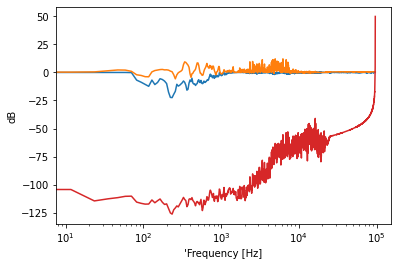

In [19]:
f, resFF = FFSimulation(FF, PP_RefData[:numFrames*frameLength-1], PP_ErrData[:numFrames*frameLength-1], spModel)
_, resFFI = FFSimulationI(FF, PP_RefData[:numFrames*frameLength-1], PP_ErrData[:numFrames*frameLength-1], spModel)
_, resFFII = FFSimulationII(FF, PP_RefData[:numFrames*frameLength-1], PP_ErrData[:numFrames*frameLength-1], spModel)
_, _, Err =  signal.spectrogram(PP_ErrData[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),nperseg=16384, \
                                  noverlap=3/4*16384, mode='complex')
print(resFFI)
print(resFFII)
Err = 20*np.log10(np.mean(np.abs(Err), 1))
length = min(len(f), len(Cxx))
length = min(len(Err), length)
fig, ax = plt.subplots(1, 1)
ax.plot(f[:length], Cxx[:length])
ax.plot(f[:length], resFF[:length]-Err[:length])
ax.plot(f[:length], resFFI[:length]-Err[:length])
ax.plot(f[:length], resFFII[:length]-Err[:length])
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()

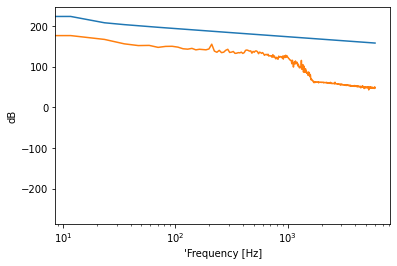

In [20]:
#FB Simulation
filter2 = IIRFilter('Peaking', [1000, 5, 100])
filter1 = IIRFilter('LowPass', [1000, 0, 1000])
FB = FilterSet()
FB.AddBiquad(filter1)
FB.AddBiquad(filter2)
FB.gainDB2K(-200)
f, FB_Freqz = FB.SelfPlot()

_, h = signal.freqz(spModel, 1) #求FIR的频响
sSP = 20*np.log10(np.abs(h))
length = min(len(f), len(sSP))
fig, ax = plt.subplots(1, 1)
ax.plot(f[:length], FB_Freqz[:length])
ax.plot(f[:length], sSP[:length]+FB_Freqz[:length])
plt.xscale('log')
plt.xlabel("'Frequency [Hz]")
plt.ylabel("dB")
plt.show()




In [21]:
# def FBSimulation(FB, PP_ErrData, spModel):
#     res = np.zeros(len(PP_ErrData)+1)
#     for i in range(len(PP_ErrData)):
#         antiFBi = FB.Filtering(res[[i]])
#         antii = signal.lfilter(spModel, [1], antiFBi)
#         res[i+1] = PP_ErrData[i] + antii[0] 
#         if i%19200 == 1:
#             print("loop:{:d}".format(i))
#             print("antiFBi:{:.8f}, antii:{:.8f}, PPErr:{:.8f}".format(antiFBi[0], antii[0], PP_ErrData[i]))
#     return res[1:]

# antiFB = FBSimulation(FB, PP_ErrData, spModel)
# f, _, resFB =  signal.spectrogram(antiFB[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),nperseg=16384, \
#                                     noverlap=3/4*16384, mode='complex')
# FBRes = 20*np.log10(np.mean(np.abs(resFB), 1))

# _, _, Err =  signal.spectrogram(PP_ErrData[:numFrames*frameLength-1], fs=sample_rate, window=signal.get_window('hamming', 16384),nperseg=16384, \
#                                    noverlap=3/4*16384, mode='complex')
# Err = 20*np.log10(np.mean(np.abs(Err), 1))
# print(FBRes)
# print(Err)
# length = min(len(Err), len(resFB))
# fig, ax = plt.subplots(1, 1)
# ax.plot(f[:length], FBRes[:length]-Err[:length])
# plt.xscale('log')
# plt.xlabel("'Frequency [Hz]")
# plt.ylabel("dB")
# plt.show()

## minimum phase systems
　　如果控制系统开环传函的所有极点和零点均位于s左半平面上，则称该系统为最小相位系统。
  
　　一个系统被称为最小相位系统，当且仅当这个系统是因果稳定的，有一个有理形式的系统函数，并且存在着一个因果稳定的逆函数。
编辑本段

特点1:如果两个系统有相同的幅频特性，那么对于大于零的任何频率，最小相位系统的相角总小于非最小相位系统；

特点2:最小相位系统的幅频特性和相频特性直接关联，也就是说，一个幅频特性只能有一个相频特性与之对应，一个相频特性只能有一个幅频特性与之对应。对于最小相位系统，只要根据对数幅频曲线就能写出系统的传递函数。

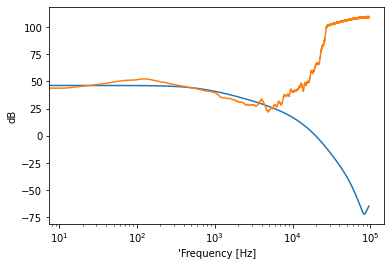

GA Process:0/10000, Loss:0.17761521
GA Process:1/10000, Loss:0.15037312
GA Process:2/10000, Loss:0.15037312
GA Process:3/10000, Loss:0.14737370
GA Process:4/10000, Loss:0.13365216
GA Process:5/10000, Loss:0.12717860
GA Process:6/10000, Loss:0.12717860
GA Process:7/10000, Loss:0.12357258
GA Process:8/10000, Loss:0.12357258
GA Process:9/10000, Loss:0.12357258
GA Process:10/10000, Loss:0.12357258
GA Process:11/10000, Loss:0.12238802
GA Process:12/10000, Loss:0.12238802
GA Process:13/10000, Loss:0.12238802
GA Process:14/10000, Loss:0.11881287
GA Process:15/10000, Loss:0.09015055
GA Process:16/10000, Loss:0.09015055
GA Process:17/10000, Loss:0.09015055
GA Process:18/10000, Loss:0.09015055
GA Process:19/10000, Loss:0.09013063
GA Process:20/10000, Loss:0.09013063
GA Process:21/10000, Loss:0.09013063
GA Process:22/10000, Loss:0.09013063
GA Process:23/10000, Loss:0.09013063
GA Process:24/10000, Loss:0.09013063
GA Process:25/10000, Loss:0.09012960
GA Process:26/10000, Loss:0.09012960
GA Process:

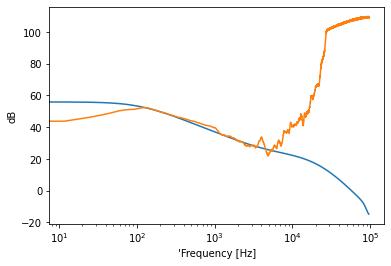

GA Process:100/10000, Loss:0.07838173
GA Process:101/10000, Loss:0.07838173
GA Process:102/10000, Loss:0.07837902
GA Process:103/10000, Loss:0.07825830
GA Process:104/10000, Loss:0.07825830
GA Process:105/10000, Loss:0.07825830
GA Process:106/10000, Loss:0.07825830
GA Process:107/10000, Loss:0.07825830
GA Process:108/10000, Loss:0.07825830
GA Process:109/10000, Loss:0.07825820
GA Process:110/10000, Loss:0.07825820
GA Process:111/10000, Loss:0.07825820
GA Process:112/10000, Loss:0.07825820
GA Process:113/10000, Loss:0.07825669
GA Process:114/10000, Loss:0.07825669
GA Process:115/10000, Loss:0.07825669
GA Process:116/10000, Loss:0.07825669
GA Process:117/10000, Loss:0.07825669
GA Process:118/10000, Loss:0.07825669
GA Process:119/10000, Loss:0.07825669
GA Process:120/10000, Loss:0.07825669
GA Process:121/10000, Loss:0.07825019
GA Process:122/10000, Loss:0.07825019
GA Process:123/10000, Loss:0.07825019
GA Process:124/10000, Loss:0.07825019
GA Process:125/10000, Loss:0.07825019
GA Process:1

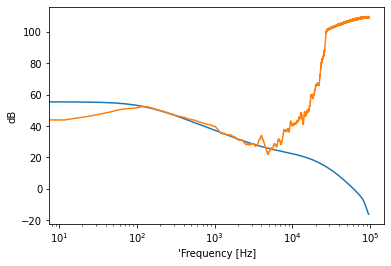

GA Process:200/10000, Loss:0.07809798
GA Process:201/10000, Loss:0.07809798
GA Process:202/10000, Loss:0.07809798
GA Process:203/10000, Loss:0.07807893
GA Process:204/10000, Loss:0.07807893
GA Process:205/10000, Loss:0.07807893
GA Process:206/10000, Loss:0.07807893
GA Process:207/10000, Loss:0.07807775
GA Process:208/10000, Loss:0.07807775
GA Process:209/10000, Loss:0.07807775
GA Process:210/10000, Loss:0.07807775
GA Process:211/10000, Loss:0.07807718
GA Process:212/10000, Loss:0.07807718
GA Process:213/10000, Loss:0.07807718
GA Process:214/10000, Loss:0.07807718
GA Process:215/10000, Loss:0.07807718
GA Process:216/10000, Loss:0.07807718
GA Process:217/10000, Loss:0.07807718
GA Process:218/10000, Loss:0.07807718
GA Process:219/10000, Loss:0.07807718
GA Process:220/10000, Loss:0.07807718
GA Process:221/10000, Loss:0.07807718
GA Process:222/10000, Loss:0.07807718
GA Process:223/10000, Loss:0.07807718
GA Process:224/10000, Loss:0.07807718
GA Process:225/10000, Loss:0.07807718
GA Process:2

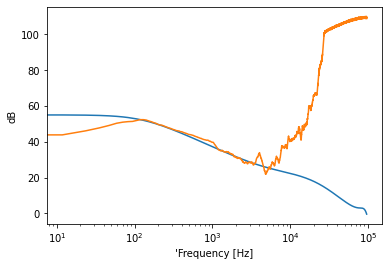

GA Process:300/10000, Loss:0.07806583
GA Process:301/10000, Loss:0.07806583
GA Process:302/10000, Loss:0.07806583
GA Process:303/10000, Loss:0.07806583
GA Process:304/10000, Loss:0.07806583
GA Process:305/10000, Loss:0.07806583
GA Process:306/10000, Loss:0.07806583
GA Process:307/10000, Loss:0.07806583
GA Process:308/10000, Loss:0.07806583
GA Process:309/10000, Loss:0.07806583
GA Process:310/10000, Loss:0.07806583
GA Process:311/10000, Loss:0.07806583
GA Process:312/10000, Loss:0.07806583
GA Process:313/10000, Loss:0.07806583
GA Process:314/10000, Loss:0.07806583
GA Process:315/10000, Loss:0.07806583
GA Process:316/10000, Loss:0.07806583
GA Process:317/10000, Loss:0.07806583
GA Process:318/10000, Loss:0.07806583
GA Process:319/10000, Loss:0.07806583
GA Process:320/10000, Loss:0.07806583
GA Process:321/10000, Loss:0.07806583
GA Process:322/10000, Loss:0.07806583
GA Process:323/10000, Loss:0.07806583
GA Process:324/10000, Loss:0.07806583
GA Process:325/10000, Loss:0.07806583
GA Process:3

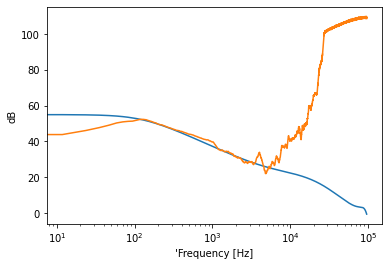

GA Process:400/10000, Loss:0.07805609
GA Process:401/10000, Loss:0.07805609
GA Process:402/10000, Loss:0.07805609
GA Process:403/10000, Loss:0.07805609
GA Process:404/10000, Loss:0.07805609
GA Process:405/10000, Loss:0.07805609
GA Process:406/10000, Loss:0.07805609
GA Process:407/10000, Loss:0.07805609
GA Process:408/10000, Loss:0.07805609
GA Process:409/10000, Loss:0.07805609
GA Process:410/10000, Loss:0.07805577
GA Process:411/10000, Loss:0.07805577
GA Process:412/10000, Loss:0.07805577
GA Process:413/10000, Loss:0.07805577
GA Process:414/10000, Loss:0.07805577
GA Process:415/10000, Loss:0.07805577
GA Process:416/10000, Loss:0.07805577
GA Process:417/10000, Loss:0.07805577
GA Process:418/10000, Loss:0.07805577
GA Process:419/10000, Loss:0.07805577
GA Process:420/10000, Loss:0.07805577
GA Process:421/10000, Loss:0.07805510
GA Process:422/10000, Loss:0.07805510
GA Process:423/10000, Loss:0.07805494
GA Process:424/10000, Loss:0.07805494
GA Process:425/10000, Loss:0.07805494
GA Process:4

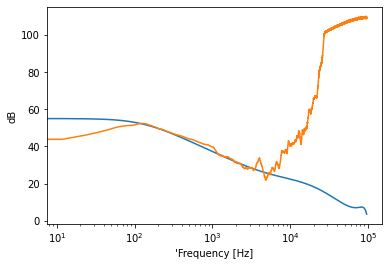

GA Process:500/10000, Loss:0.07804551
GA Process:501/10000, Loss:0.07804551
GA Process:502/10000, Loss:0.07804551
GA Process:503/10000, Loss:0.07804551
GA Process:504/10000, Loss:0.07804551
GA Process:505/10000, Loss:0.07804551
GA Process:506/10000, Loss:0.07804551
GA Process:507/10000, Loss:0.07804551
GA Process:508/10000, Loss:0.07804551
GA Process:509/10000, Loss:0.07804551
GA Process:510/10000, Loss:0.07804551
GA Process:511/10000, Loss:0.07804551
GA Process:512/10000, Loss:0.07804551
GA Process:513/10000, Loss:0.07804551
GA Process:514/10000, Loss:0.07804551
GA Process:515/10000, Loss:0.07804534
GA Process:516/10000, Loss:0.07804501
GA Process:517/10000, Loss:0.07804501
GA Process:518/10000, Loss:0.07804501
GA Process:519/10000, Loss:0.07804446
GA Process:520/10000, Loss:0.07804433
GA Process:521/10000, Loss:0.07804433
GA Process:522/10000, Loss:0.07804433
GA Process:523/10000, Loss:0.07804387
GA Process:524/10000, Loss:0.07804354
GA Process:525/10000, Loss:0.07804354
GA Process:5

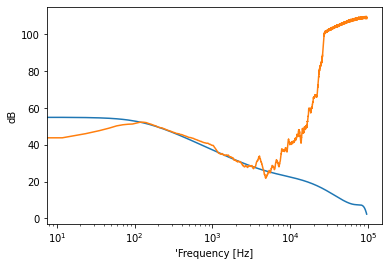

GA Process:600/10000, Loss:0.07802960
GA Process:601/10000, Loss:0.07802960
GA Process:602/10000, Loss:0.07802960
GA Process:603/10000, Loss:0.07802960
GA Process:604/10000, Loss:0.07802960
GA Process:605/10000, Loss:0.07802960
GA Process:606/10000, Loss:0.07802699
GA Process:607/10000, Loss:0.07802699
GA Process:608/10000, Loss:0.07802699
GA Process:609/10000, Loss:0.07802699
GA Process:610/10000, Loss:0.07802699
GA Process:611/10000, Loss:0.07802660
GA Process:612/10000, Loss:0.07802660
GA Process:613/10000, Loss:0.07802660
GA Process:614/10000, Loss:0.07802537
GA Process:615/10000, Loss:0.07802537
GA Process:616/10000, Loss:0.07802537
GA Process:617/10000, Loss:0.07802537
GA Process:618/10000, Loss:0.07802537
GA Process:619/10000, Loss:0.07802537
GA Process:620/10000, Loss:0.07802537
GA Process:621/10000, Loss:0.07802493
GA Process:622/10000, Loss:0.07802493
GA Process:623/10000, Loss:0.07802493
GA Process:624/10000, Loss:0.07802493
GA Process:625/10000, Loss:0.07802493
GA Process:6

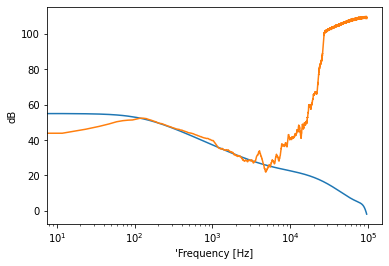

GA Process:700/10000, Loss:0.07801133
GA Process:701/10000, Loss:0.07801133
GA Process:702/10000, Loss:0.07801133
GA Process:703/10000, Loss:0.07801133
GA Process:704/10000, Loss:0.07801133
GA Process:705/10000, Loss:0.07801133
GA Process:706/10000, Loss:0.07801133
GA Process:707/10000, Loss:0.07801133
GA Process:708/10000, Loss:0.07801133
GA Process:709/10000, Loss:0.07801133
GA Process:710/10000, Loss:0.07801133
GA Process:711/10000, Loss:0.07801133
GA Process:712/10000, Loss:0.07801133
GA Process:713/10000, Loss:0.07801133
GA Process:714/10000, Loss:0.07801133
GA Process:715/10000, Loss:0.07801133
GA Process:716/10000, Loss:0.07801133
GA Process:717/10000, Loss:0.07801133
GA Process:718/10000, Loss:0.07801133
GA Process:719/10000, Loss:0.07801133
GA Process:720/10000, Loss:0.07800829
GA Process:721/10000, Loss:0.07800829
GA Process:722/10000, Loss:0.07800829
GA Process:723/10000, Loss:0.07800829
GA Process:724/10000, Loss:0.07800731
GA Process:725/10000, Loss:0.07800731
GA Process:7

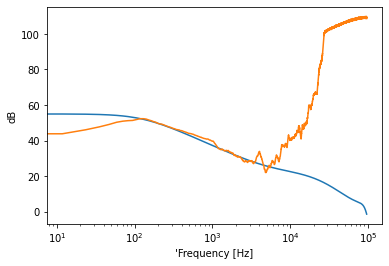

GA Process:800/10000, Loss:0.07800381
GA Process:801/10000, Loss:0.07800381
GA Process:802/10000, Loss:0.07800381
GA Process:803/10000, Loss:0.07800381
GA Process:804/10000, Loss:0.07800381
GA Process:805/10000, Loss:0.07800381
GA Process:806/10000, Loss:0.07800381
GA Process:807/10000, Loss:0.07800381
GA Process:808/10000, Loss:0.07800381
GA Process:809/10000, Loss:0.07800381
GA Process:810/10000, Loss:0.07800381
GA Process:811/10000, Loss:0.07800381
GA Process:812/10000, Loss:0.07800381
GA Process:813/10000, Loss:0.07800381
GA Process:814/10000, Loss:0.07800381
GA Process:815/10000, Loss:0.07800381
GA Process:816/10000, Loss:0.07800381
GA Process:817/10000, Loss:0.07800381
GA Process:818/10000, Loss:0.07800381
GA Process:819/10000, Loss:0.07800043
GA Process:820/10000, Loss:0.07800043
GA Process:821/10000, Loss:0.07800043
GA Process:822/10000, Loss:0.07800043
GA Process:823/10000, Loss:0.07800043
GA Process:824/10000, Loss:0.07800043
GA Process:825/10000, Loss:0.07800043
GA Process:8

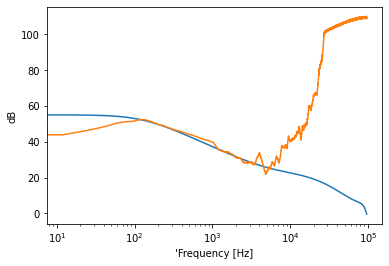

GA Process:900/10000, Loss:0.07798859
GA Process:901/10000, Loss:0.07798859
GA Process:902/10000, Loss:0.07798859
GA Process:903/10000, Loss:0.07798859
GA Process:904/10000, Loss:0.07798859
GA Process:905/10000, Loss:0.07798859
GA Process:906/10000, Loss:0.07798859
GA Process:907/10000, Loss:0.07798859
GA Process:908/10000, Loss:0.07798859
GA Process:909/10000, Loss:0.07798859
GA Process:910/10000, Loss:0.07798859
GA Process:911/10000, Loss:0.07798859
GA Process:912/10000, Loss:0.07798859
GA Process:913/10000, Loss:0.07798859
GA Process:914/10000, Loss:0.07798859
GA Process:915/10000, Loss:0.07798859
GA Process:916/10000, Loss:0.07798859
GA Process:917/10000, Loss:0.07798859
GA Process:918/10000, Loss:0.07798859
GA Process:919/10000, Loss:0.07798859
GA Process:920/10000, Loss:0.07798859
GA Process:921/10000, Loss:0.07798859
GA Process:922/10000, Loss:0.07798859
GA Process:923/10000, Loss:0.07798859
GA Process:924/10000, Loss:0.07798859
GA Process:925/10000, Loss:0.07798859
GA Process:9

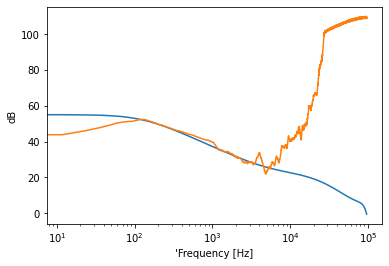

GA Process:1000/10000, Loss:0.07798412
GA Process:1001/10000, Loss:0.07798409
GA Process:1002/10000, Loss:0.07798409
GA Process:1003/10000, Loss:0.07798409
GA Process:1004/10000, Loss:0.07798409
GA Process:1005/10000, Loss:0.07798409
GA Process:1006/10000, Loss:0.07798409
GA Process:1007/10000, Loss:0.07798409
GA Process:1008/10000, Loss:0.07798409
GA Process:1009/10000, Loss:0.07798282
GA Process:1010/10000, Loss:0.07798282
GA Process:1011/10000, Loss:0.07798282
GA Process:1012/10000, Loss:0.07798282
GA Process:1013/10000, Loss:0.07798282
GA Process:1014/10000, Loss:0.07798282
GA Process:1015/10000, Loss:0.07798282
GA Process:1016/10000, Loss:0.07798282
GA Process:1017/10000, Loss:0.07798282
GA Process:1018/10000, Loss:0.07798282
GA Process:1019/10000, Loss:0.07798282
GA Process:1020/10000, Loss:0.07798282
GA Process:1021/10000, Loss:0.07798282
GA Process:1022/10000, Loss:0.07798282
GA Process:1023/10000, Loss:0.07798282
GA Process:1024/10000, Loss:0.07798282
GA Process:1025/10000, Lo

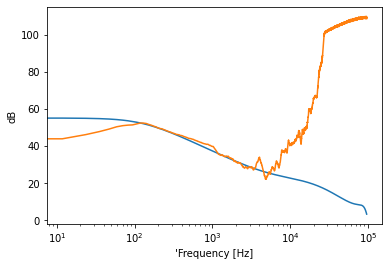

GA Process:1100/10000, Loss:0.07798140
GA Process:1101/10000, Loss:0.07798140
GA Process:1102/10000, Loss:0.07798140
GA Process:1103/10000, Loss:0.07798113
GA Process:1104/10000, Loss:0.07798113
GA Process:1105/10000, Loss:0.07798113
GA Process:1106/10000, Loss:0.07798113
GA Process:1107/10000, Loss:0.07798113
GA Process:1108/10000, Loss:0.07798113
GA Process:1109/10000, Loss:0.07798113
GA Process:1110/10000, Loss:0.07798110
GA Process:1111/10000, Loss:0.07798110
GA Process:1112/10000, Loss:0.07798110
GA Process:1113/10000, Loss:0.07798110
GA Process:1114/10000, Loss:0.07798110
GA Process:1115/10000, Loss:0.07798110
GA Process:1116/10000, Loss:0.07798110
GA Process:1117/10000, Loss:0.07798110
GA Process:1118/10000, Loss:0.07798110
GA Process:1119/10000, Loss:0.07798110
GA Process:1120/10000, Loss:0.07798110
GA Process:1121/10000, Loss:0.07798108
GA Process:1122/10000, Loss:0.07798108
GA Process:1123/10000, Loss:0.07798108
GA Process:1124/10000, Loss:0.07798108
GA Process:1125/10000, Lo

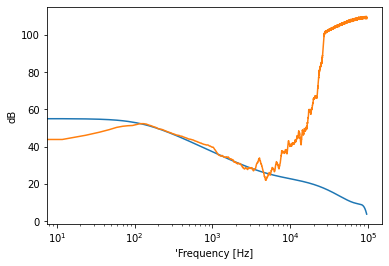

GA Process:1200/10000, Loss:0.07797947
GA Process:1201/10000, Loss:0.07797823
GA Process:1202/10000, Loss:0.07797823
GA Process:1203/10000, Loss:0.07797823
GA Process:1204/10000, Loss:0.07797823
GA Process:1205/10000, Loss:0.07797823
GA Process:1206/10000, Loss:0.07797823
GA Process:1207/10000, Loss:0.07797823
GA Process:1208/10000, Loss:0.07797823
GA Process:1209/10000, Loss:0.07797823
GA Process:1210/10000, Loss:0.07797823
GA Process:1211/10000, Loss:0.07797823
GA Process:1212/10000, Loss:0.07797823
GA Process:1213/10000, Loss:0.07797823
GA Process:1214/10000, Loss:0.07797823
GA Process:1215/10000, Loss:0.07797823
GA Process:1216/10000, Loss:0.07797823
GA Process:1217/10000, Loss:0.07797784
GA Process:1218/10000, Loss:0.07797784
GA Process:1219/10000, Loss:0.07797784
GA Process:1220/10000, Loss:0.07797784
GA Process:1221/10000, Loss:0.07797784
GA Process:1222/10000, Loss:0.07797784
GA Process:1223/10000, Loss:0.07797784
GA Process:1224/10000, Loss:0.07797784
GA Process:1225/10000, Lo

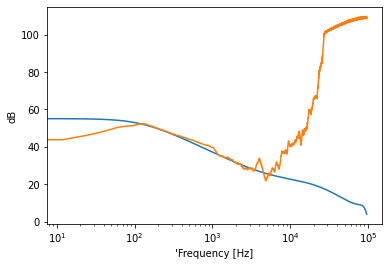

GA Process:1300/10000, Loss:0.07797279
GA Process:1301/10000, Loss:0.07797279
GA Process:1302/10000, Loss:0.07797279
GA Process:1303/10000, Loss:0.07797279
GA Process:1304/10000, Loss:0.07797278
GA Process:1305/10000, Loss:0.07797278
GA Process:1306/10000, Loss:0.07797278
GA Process:1307/10000, Loss:0.07797278
GA Process:1308/10000, Loss:0.07797278
GA Process:1309/10000, Loss:0.07797278
GA Process:1310/10000, Loss:0.07797278
GA Process:1311/10000, Loss:0.07797278
GA Process:1312/10000, Loss:0.07797278
GA Process:1313/10000, Loss:0.07797265
GA Process:1314/10000, Loss:0.07797265
GA Process:1315/10000, Loss:0.07797265
GA Process:1316/10000, Loss:0.07797265
GA Process:1317/10000, Loss:0.07797171
GA Process:1318/10000, Loss:0.07797171
GA Process:1319/10000, Loss:0.07797171
GA Process:1320/10000, Loss:0.07797171
GA Process:1321/10000, Loss:0.07797171
GA Process:1322/10000, Loss:0.07797171
GA Process:1323/10000, Loss:0.07797171
GA Process:1324/10000, Loss:0.07797171
GA Process:1325/10000, Lo

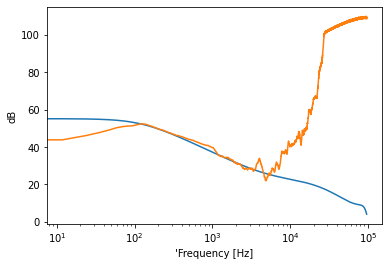

GA Process:1400/10000, Loss:0.07797119
GA Process:1401/10000, Loss:0.07797119
GA Process:1402/10000, Loss:0.07797119
GA Process:1403/10000, Loss:0.07797119
GA Process:1404/10000, Loss:0.07797119
GA Process:1405/10000, Loss:0.07797102
GA Process:1406/10000, Loss:0.07797102
GA Process:1407/10000, Loss:0.07797102
GA Process:1408/10000, Loss:0.07797102
GA Process:1409/10000, Loss:0.07797102
GA Process:1410/10000, Loss:0.07797100
GA Process:1411/10000, Loss:0.07797100
GA Process:1412/10000, Loss:0.07797100
GA Process:1413/10000, Loss:0.07797100
GA Process:1414/10000, Loss:0.07797100
GA Process:1415/10000, Loss:0.07797100
GA Process:1416/10000, Loss:0.07797100
GA Process:1417/10000, Loss:0.07797100
GA Process:1418/10000, Loss:0.07797100
GA Process:1419/10000, Loss:0.07797100
GA Process:1420/10000, Loss:0.07797100
GA Process:1421/10000, Loss:0.07797100
GA Process:1422/10000, Loss:0.07797100
GA Process:1423/10000, Loss:0.07797100
GA Process:1424/10000, Loss:0.07797100
GA Process:1425/10000, Lo

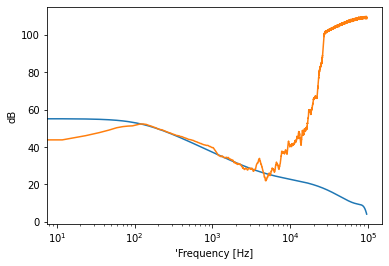

GA Process:1500/10000, Loss:0.07796998
GA Process:1501/10000, Loss:0.07796998
GA Process:1502/10000, Loss:0.07796998
GA Process:1503/10000, Loss:0.07796998
GA Process:1504/10000, Loss:0.07796998
GA Process:1505/10000, Loss:0.07796998
GA Process:1506/10000, Loss:0.07796998
GA Process:1507/10000, Loss:0.07796998
GA Process:1508/10000, Loss:0.07796998
GA Process:1509/10000, Loss:0.07796998
GA Process:1510/10000, Loss:0.07796998
GA Process:1511/10000, Loss:0.07796998
GA Process:1512/10000, Loss:0.07796998
GA Process:1513/10000, Loss:0.07796998
GA Process:1514/10000, Loss:0.07796998
GA Process:1515/10000, Loss:0.07796998
GA Process:1516/10000, Loss:0.07796998
GA Process:1517/10000, Loss:0.07796998
GA Process:1518/10000, Loss:0.07796998
GA Process:1519/10000, Loss:0.07796998
GA Process:1520/10000, Loss:0.07796998
GA Process:1521/10000, Loss:0.07796998
GA Process:1522/10000, Loss:0.07796998
GA Process:1523/10000, Loss:0.07796998
GA Process:1524/10000, Loss:0.07796998
GA Process:1525/10000, Lo

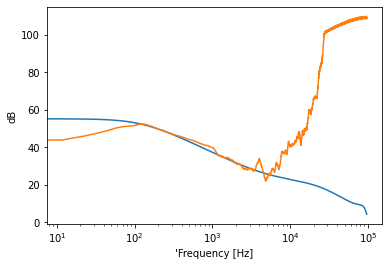

GA Process:1600/10000, Loss:0.07796788
GA Process:1601/10000, Loss:0.07796788
GA Process:1602/10000, Loss:0.07796788
GA Process:1603/10000, Loss:0.07796788
GA Process:1604/10000, Loss:0.07796788
GA Process:1605/10000, Loss:0.07796787
GA Process:1606/10000, Loss:0.07796787
GA Process:1607/10000, Loss:0.07796787
GA Process:1608/10000, Loss:0.07796787
GA Process:1609/10000, Loss:0.07796787
GA Process:1610/10000, Loss:0.07796787
GA Process:1611/10000, Loss:0.07796787
GA Process:1612/10000, Loss:0.07796787
GA Process:1613/10000, Loss:0.07796787
GA Process:1614/10000, Loss:0.07796787
GA Process:1615/10000, Loss:0.07796787
GA Process:1616/10000, Loss:0.07796776
GA Process:1617/10000, Loss:0.07796776
GA Process:1618/10000, Loss:0.07796776
GA Process:1619/10000, Loss:0.07796776
GA Process:1620/10000, Loss:0.07796763
GA Process:1621/10000, Loss:0.07796763
GA Process:1622/10000, Loss:0.07796763
GA Process:1623/10000, Loss:0.07796763
GA Process:1624/10000, Loss:0.07796763
GA Process:1625/10000, Lo

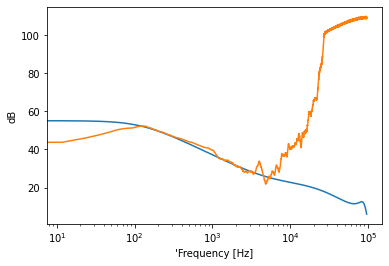

GA Process:1700/10000, Loss:0.07796689
GA Process:1701/10000, Loss:0.07796689
GA Process:1702/10000, Loss:0.07796689
GA Process:1703/10000, Loss:0.07796689
GA Process:1704/10000, Loss:0.07796665
GA Process:1705/10000, Loss:0.07796665
GA Process:1706/10000, Loss:0.07796665
GA Process:1707/10000, Loss:0.07796665
GA Process:1708/10000, Loss:0.07796665
GA Process:1709/10000, Loss:0.07796665
GA Process:1710/10000, Loss:0.07796665
GA Process:1711/10000, Loss:0.07796664
GA Process:1712/10000, Loss:0.07796664
GA Process:1713/10000, Loss:0.07796664
GA Process:1714/10000, Loss:0.07796664
GA Process:1715/10000, Loss:0.07796660
GA Process:1716/10000, Loss:0.07796660
GA Process:1717/10000, Loss:0.07796660
GA Process:1718/10000, Loss:0.07796660
GA Process:1719/10000, Loss:0.07796660
GA Process:1720/10000, Loss:0.07796660
GA Process:1721/10000, Loss:0.07796660
GA Process:1722/10000, Loss:0.07796660
GA Process:1723/10000, Loss:0.07796660
GA Process:1724/10000, Loss:0.07796660
GA Process:1725/10000, Lo

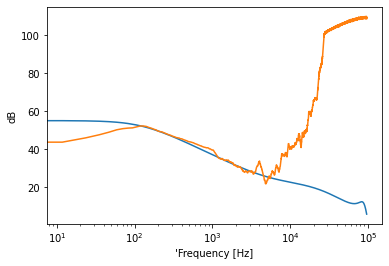

GA Process:1800/10000, Loss:0.07796660
GA Process:1801/10000, Loss:0.07796660
GA Process:1802/10000, Loss:0.07796660
GA Process:1803/10000, Loss:0.07796660
GA Process:1804/10000, Loss:0.07796660
GA Process:1805/10000, Loss:0.07796660
GA Process:1806/10000, Loss:0.07796660
GA Process:1807/10000, Loss:0.07796660
GA Process:1808/10000, Loss:0.07796660
GA Process:1809/10000, Loss:0.07796660
GA Process:1810/10000, Loss:0.07796660
GA Process:1811/10000, Loss:0.07796660
GA Process:1812/10000, Loss:0.07796660
GA Process:1813/10000, Loss:0.07796660
GA Process:1814/10000, Loss:0.07796660
GA Process:1815/10000, Loss:0.07796660
GA Process:1816/10000, Loss:0.07796660
GA Process:1817/10000, Loss:0.07796660
GA Process:1818/10000, Loss:0.07796660
GA Process:1819/10000, Loss:0.07796660
GA Process:1820/10000, Loss:0.07796660
GA Process:1821/10000, Loss:0.07796660
GA Process:1822/10000, Loss:0.07796660
GA Process:1823/10000, Loss:0.07796660
GA Process:1824/10000, Loss:0.07796660
GA Process:1825/10000, Lo

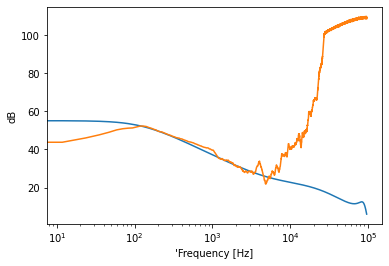

GA Process:1900/10000, Loss:0.07796657
GA Process:1901/10000, Loss:0.07796657
GA Process:1902/10000, Loss:0.07796657
GA Process:1903/10000, Loss:0.07796657
GA Process:1904/10000, Loss:0.07796657
GA Process:1905/10000, Loss:0.07796657
GA Process:1906/10000, Loss:0.07796657
GA Process:1907/10000, Loss:0.07796657
GA Process:1908/10000, Loss:0.07796657
GA Process:1909/10000, Loss:0.07796657
GA Process:1910/10000, Loss:0.07796657
GA Process:1911/10000, Loss:0.07796657
GA Process:1912/10000, Loss:0.07796657
GA Process:1913/10000, Loss:0.07796657
GA Process:1914/10000, Loss:0.07796657
GA Process:1915/10000, Loss:0.07796657
GA Process:1916/10000, Loss:0.07796657
GA Process:1917/10000, Loss:0.07796657
GA Process:1918/10000, Loss:0.07796657
GA Process:1919/10000, Loss:0.07796657
GA Process:1920/10000, Loss:0.07796657
GA Process:1921/10000, Loss:0.07796657
GA Process:1922/10000, Loss:0.07796657
GA Process:1923/10000, Loss:0.07796657
GA Process:1924/10000, Loss:0.07796657
GA Process:1925/10000, Lo

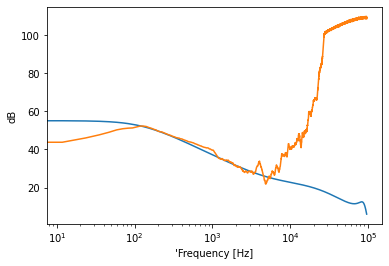

GA Process:2000/10000, Loss:0.07796657
GA Process:2001/10000, Loss:0.07796657
GA Process:2002/10000, Loss:0.07796657
GA Process:2003/10000, Loss:0.07796657
GA Process:2004/10000, Loss:0.07796657
GA Process:2005/10000, Loss:0.07796657
GA Process:2006/10000, Loss:0.07796656
GA Process:2007/10000, Loss:0.07796656
GA Process:2008/10000, Loss:0.07796656
GA Process:2009/10000, Loss:0.07796656
GA Process:2010/10000, Loss:0.07796656
GA Process:2011/10000, Loss:0.07796656
GA Process:2012/10000, Loss:0.07796656
GA Process:2013/10000, Loss:0.07796656
GA Process:2014/10000, Loss:0.07796656
GA Process:2015/10000, Loss:0.07796656
GA Process:2016/10000, Loss:0.07796656
GA Process:2017/10000, Loss:0.07796656
GA Process:2018/10000, Loss:0.07796656
GA Process:2019/10000, Loss:0.07796656
GA Process:2020/10000, Loss:0.07796656
GA Process:2021/10000, Loss:0.07796656
GA Process:2022/10000, Loss:0.07796656
GA Process:2023/10000, Loss:0.07796656
GA Process:2024/10000, Loss:0.07796656
GA Process:2025/10000, Lo

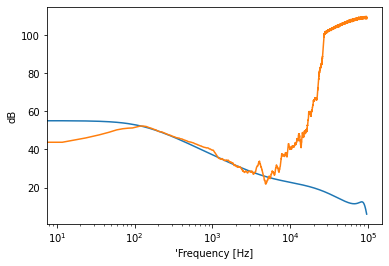

GA Process:2100/10000, Loss:0.07796656
GA Process:2101/10000, Loss:0.07796656
GA Process:2102/10000, Loss:0.07796656
GA Process:2103/10000, Loss:0.07796656
GA Process:2104/10000, Loss:0.07796656
GA Process:2105/10000, Loss:0.07796656
GA Process:2106/10000, Loss:0.07796656
GA Process:2107/10000, Loss:0.07796656
GA Process:2108/10000, Loss:0.07796656
GA Process:2109/10000, Loss:0.07796656
GA Process:2110/10000, Loss:0.07796656
GA Process:2111/10000, Loss:0.07796656
GA Process:2112/10000, Loss:0.07796656
GA Process:2113/10000, Loss:0.07796656
GA Process:2114/10000, Loss:0.07796656
GA Process:2115/10000, Loss:0.07796656
GA Process:2116/10000, Loss:0.07796656
GA Process:2117/10000, Loss:0.07796656
GA Process:2118/10000, Loss:0.07796656
GA Process:2119/10000, Loss:0.07796656
GA Process:2120/10000, Loss:0.07796656
GA Process:2121/10000, Loss:0.07796656
GA Process:2122/10000, Loss:0.07796656
GA Process:2123/10000, Loss:0.07796656
GA Process:2124/10000, Loss:0.07796656
GA Process:2125/10000, Lo

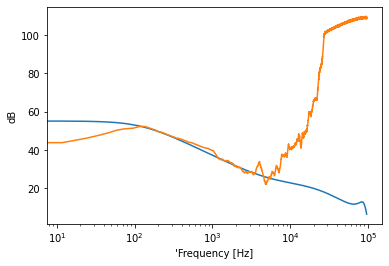

GA Process:2200/10000, Loss:0.07796654
GA Process:2201/10000, Loss:0.07796654
GA Process:2202/10000, Loss:0.07796654
GA Process:2203/10000, Loss:0.07796654
GA Process:2204/10000, Loss:0.07796654
GA Process:2205/10000, Loss:0.07796654
GA Process:2206/10000, Loss:0.07796654
GA Process:2207/10000, Loss:0.07796654
GA Process:2208/10000, Loss:0.07796654
GA Process:2209/10000, Loss:0.07796654
GA Process:2210/10000, Loss:0.07796654
GA Process:2211/10000, Loss:0.07796654
GA Process:2212/10000, Loss:0.07796654
GA Process:2213/10000, Loss:0.07796654
GA Process:2214/10000, Loss:0.07796654
GA Process:2215/10000, Loss:0.07796654
GA Process:2216/10000, Loss:0.07796654
GA Process:2217/10000, Loss:0.07796654
GA Process:2218/10000, Loss:0.07796654
GA Process:2219/10000, Loss:0.07796654
GA Process:2220/10000, Loss:0.07796654
GA Process:2221/10000, Loss:0.07796654
GA Process:2222/10000, Loss:0.07796654
GA Process:2223/10000, Loss:0.07796654
GA Process:2224/10000, Loss:0.07796654
GA Process:2225/10000, Lo

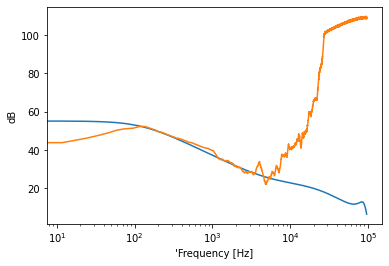

GA Process:2300/10000, Loss:0.07796654
GA Process:2301/10000, Loss:0.07796654
GA Process:2302/10000, Loss:0.07796654
GA Process:2303/10000, Loss:0.07796654
GA Process:2304/10000, Loss:0.07796654
GA Process:2305/10000, Loss:0.07796654
GA Process:2306/10000, Loss:0.07796654
GA Process:2307/10000, Loss:0.07796654
GA Process:2308/10000, Loss:0.07796654
GA Process:2309/10000, Loss:0.07796654
GA Process:2310/10000, Loss:0.07796654
GA Process:2311/10000, Loss:0.07796654
GA Process:2312/10000, Loss:0.07796654
GA Process:2313/10000, Loss:0.07796654
GA Process:2314/10000, Loss:0.07796654
GA Process:2315/10000, Loss:0.07796654
GA Process:2316/10000, Loss:0.07796654
GA Process:2317/10000, Loss:0.07796654
GA Process:2318/10000, Loss:0.07796654
GA Process:2319/10000, Loss:0.07796654
GA Process:2320/10000, Loss:0.07796654
GA Process:2321/10000, Loss:0.07796654
GA Process:2322/10000, Loss:0.07796654
GA Process:2323/10000, Loss:0.07796654
GA Process:2324/10000, Loss:0.07796654
GA Process:2325/10000, Lo

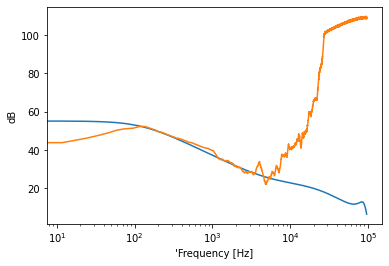

GA Process:2400/10000, Loss:0.07796654
GA Process:2401/10000, Loss:0.07796654
GA Process:2402/10000, Loss:0.07796654
GA Process:2403/10000, Loss:0.07796654
GA Process:2404/10000, Loss:0.07796654
GA Process:2405/10000, Loss:0.07796654
GA Process:2406/10000, Loss:0.07796654
GA Process:2407/10000, Loss:0.07796654
GA Process:2408/10000, Loss:0.07796654
GA Process:2409/10000, Loss:0.07796654
GA Process:2410/10000, Loss:0.07796654
GA Process:2411/10000, Loss:0.07796654
GA Process:2412/10000, Loss:0.07796654
GA Process:2413/10000, Loss:0.07796654
GA Process:2414/10000, Loss:0.07796654
GA Process:2415/10000, Loss:0.07796654
GA Process:2416/10000, Loss:0.07796654
GA Process:2417/10000, Loss:0.07796654
GA Process:2418/10000, Loss:0.07796654
GA Process:2419/10000, Loss:0.07796654
GA Process:2420/10000, Loss:0.07796654
GA Process:2421/10000, Loss:0.07796654
GA Process:2422/10000, Loss:0.07796654
GA Process:2423/10000, Loss:0.07796654
GA Process:2424/10000, Loss:0.07796654
GA Process:2425/10000, Lo

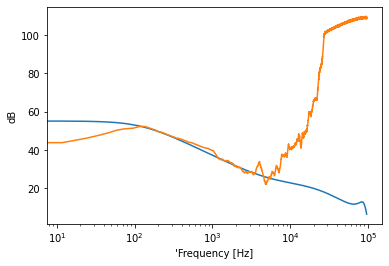

GA Process:2500/10000, Loss:0.07796654
GA Process:2501/10000, Loss:0.07796654
GA Process:2502/10000, Loss:0.07796654
GA Process:2503/10000, Loss:0.07796654
GA Process:2504/10000, Loss:0.07796654
GA Process:2505/10000, Loss:0.07796654
GA Process:2506/10000, Loss:0.07796654
GA Process:2507/10000, Loss:0.07796654
GA Process:2508/10000, Loss:0.07796654
GA Process:2509/10000, Loss:0.07796654
GA Process:2510/10000, Loss:0.07796654
GA Process:2511/10000, Loss:0.07796654
GA Process:2512/10000, Loss:0.07796654
GA Process:2513/10000, Loss:0.07796654
GA Process:2514/10000, Loss:0.07796654
GA Process:2515/10000, Loss:0.07796654
GA Process:2516/10000, Loss:0.07796654
GA Process:2517/10000, Loss:0.07796654
GA Process:2518/10000, Loss:0.07796654
GA Process:2519/10000, Loss:0.07796654
GA Process:2520/10000, Loss:0.07796654
GA Process:2521/10000, Loss:0.07796654
GA Process:2522/10000, Loss:0.07796654
GA Process:2523/10000, Loss:0.07796654
GA Process:2524/10000, Loss:0.07796654
GA Process:2525/10000, Lo

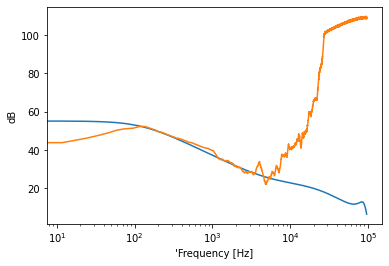

GA Process:2600/10000, Loss:0.07796654
GA Process:2601/10000, Loss:0.07796654
GA Process:2602/10000, Loss:0.07796654
GA Process:2603/10000, Loss:0.07796654
GA Process:2604/10000, Loss:0.07796654
GA Process:2605/10000, Loss:0.07796654
GA Process:2606/10000, Loss:0.07796654
GA Process:2607/10000, Loss:0.07796654
GA Process:2608/10000, Loss:0.07796654
GA Process:2609/10000, Loss:0.07796654
GA Process:2610/10000, Loss:0.07796654
GA Process:2611/10000, Loss:0.07796654
GA Process:2612/10000, Loss:0.07796654
GA Process:2613/10000, Loss:0.07796654
GA Process:2614/10000, Loss:0.07796654
GA Process:2615/10000, Loss:0.07796654
GA Process:2616/10000, Loss:0.07796654
GA Process:2617/10000, Loss:0.07796654
GA Process:2618/10000, Loss:0.07796654
GA Process:2619/10000, Loss:0.07796654
GA Process:2620/10000, Loss:0.07796654
GA Process:2621/10000, Loss:0.07796654
GA Process:2622/10000, Loss:0.07796654
GA Process:2623/10000, Loss:0.07796654
GA Process:2624/10000, Loss:0.07796654
GA Process:2625/10000, Lo

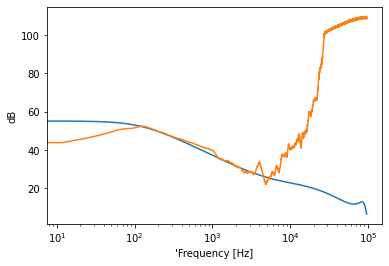

GA Process:2700/10000, Loss:0.07796654
GA Process:2701/10000, Loss:0.07796654
GA Process:2702/10000, Loss:0.07796654
GA Process:2703/10000, Loss:0.07796654
GA Process:2704/10000, Loss:0.07796654
GA Process:2705/10000, Loss:0.07796654
GA Process:2706/10000, Loss:0.07796654
GA Process:2707/10000, Loss:0.07796654
GA Process:2708/10000, Loss:0.07796654
GA Process:2709/10000, Loss:0.07796654
GA Process:2710/10000, Loss:0.07796654
GA Process:2711/10000, Loss:0.07796654
GA Process:2712/10000, Loss:0.07796654
GA Process:2713/10000, Loss:0.07796654
GA Process:2714/10000, Loss:0.07796654
GA Process:2715/10000, Loss:0.07796654
GA Process:2716/10000, Loss:0.07796654
GA Process:2717/10000, Loss:0.07796654
GA Process:2718/10000, Loss:0.07796654
GA Process:2719/10000, Loss:0.07796654
GA Process:2720/10000, Loss:0.07796654
GA Process:2721/10000, Loss:0.07796654
GA Process:2722/10000, Loss:0.07796654
GA Process:2723/10000, Loss:0.07796654
GA Process:2724/10000, Loss:0.07796654
GA Process:2725/10000, Lo

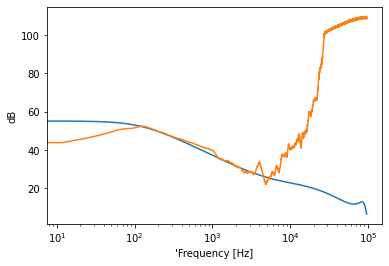

GA Process:2800/10000, Loss:0.07796654
GA Process:2801/10000, Loss:0.07796654
GA Process:2802/10000, Loss:0.07796654
GA Process:2803/10000, Loss:0.07796654
GA Process:2804/10000, Loss:0.07796654
GA Process:2805/10000, Loss:0.07796654
GA Process:2806/10000, Loss:0.07796654
GA Process:2807/10000, Loss:0.07796654
GA Process:2808/10000, Loss:0.07796654
GA Process:2809/10000, Loss:0.07796654
GA Process:2810/10000, Loss:0.07796654
GA Process:2811/10000, Loss:0.07796654
GA Process:2812/10000, Loss:0.07796654
GA Process:2813/10000, Loss:0.07796654
GA Process:2814/10000, Loss:0.07796654
GA Process:2815/10000, Loss:0.07796654
GA Process:2816/10000, Loss:0.07796654
GA Process:2817/10000, Loss:0.07796654
GA Process:2818/10000, Loss:0.07796654
GA Process:2819/10000, Loss:0.07796654
GA Process:2820/10000, Loss:0.07796654
GA Process:2821/10000, Loss:0.07796654
GA Process:2822/10000, Loss:0.07796654
GA Process:2823/10000, Loss:0.07796654
GA Process:2824/10000, Loss:0.07796654
GA Process:2825/10000, Lo

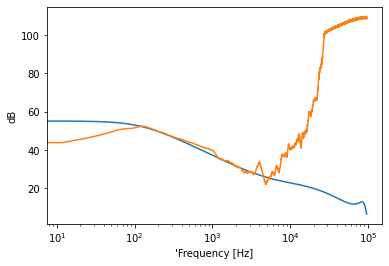

GA Process:2900/10000, Loss:0.07796654
GA Process:2901/10000, Loss:0.07796654
GA Process:2902/10000, Loss:0.07796654
GA Process:2903/10000, Loss:0.07796654
GA Process:2904/10000, Loss:0.07796654
GA Process:2905/10000, Loss:0.07796654
GA Process:2906/10000, Loss:0.07796654
GA Process:2907/10000, Loss:0.07796654
GA Process:2908/10000, Loss:0.07796654
GA Process:2909/10000, Loss:0.07796654
GA Process:2910/10000, Loss:0.07796654
GA Process:2911/10000, Loss:0.07796654
GA Process:2912/10000, Loss:0.07796654
GA Process:2913/10000, Loss:0.07796654
GA Process:2914/10000, Loss:0.07796654
GA Process:2915/10000, Loss:0.07796654
GA Process:2916/10000, Loss:0.07796654
GA Process:2917/10000, Loss:0.07796654
GA Process:2918/10000, Loss:0.07796654
GA Process:2919/10000, Loss:0.07796654
GA Process:2920/10000, Loss:0.07796654
GA Process:2921/10000, Loss:0.07796654
GA Process:2922/10000, Loss:0.07796654
GA Process:2923/10000, Loss:0.07796654
GA Process:2924/10000, Loss:0.07796654
GA Process:2925/10000, Lo

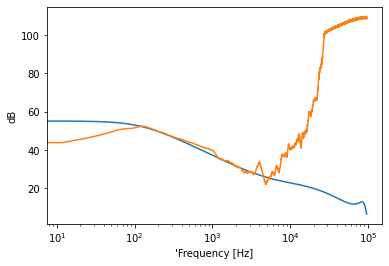

GA Process:3000/10000, Loss:0.07796654
GA Process:3001/10000, Loss:0.07796654
GA Process:3002/10000, Loss:0.07796654
GA Process:3003/10000, Loss:0.07796654
GA Process:3004/10000, Loss:0.07796654
GA Process:3005/10000, Loss:0.07796654
GA Process:3006/10000, Loss:0.07796654
GA Process:3007/10000, Loss:0.07796654
GA Process:3008/10000, Loss:0.07796654
GA Process:3009/10000, Loss:0.07796654
GA Process:3010/10000, Loss:0.07796654
GA Process:3011/10000, Loss:0.07796654
GA Process:3012/10000, Loss:0.07796654
GA Process:3013/10000, Loss:0.07796654
GA Process:3014/10000, Loss:0.07796654
GA Process:3015/10000, Loss:0.07796654
GA Process:3016/10000, Loss:0.07796654
GA Process:3017/10000, Loss:0.07796654
GA Process:3018/10000, Loss:0.07796654
GA Process:3019/10000, Loss:0.07796654
GA Process:3020/10000, Loss:0.07796654
GA Process:3021/10000, Loss:0.07796654
GA Process:3022/10000, Loss:0.07796654
GA Process:3023/10000, Loss:0.07796654
GA Process:3024/10000, Loss:0.07796654
GA Process:3025/10000, Lo

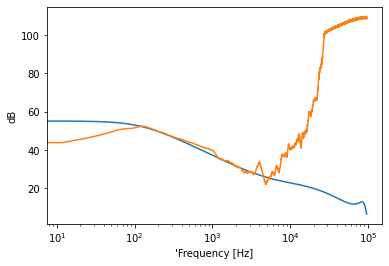

GA Process:3100/10000, Loss:0.07796654
GA Process:3101/10000, Loss:0.07796654
GA Process:3102/10000, Loss:0.07796654
GA Process:3103/10000, Loss:0.07796654
GA Process:3104/10000, Loss:0.07796654
GA Process:3105/10000, Loss:0.07796654
GA Process:3106/10000, Loss:0.07796654
GA Process:3107/10000, Loss:0.07796654
GA Process:3108/10000, Loss:0.07796654
GA Process:3109/10000, Loss:0.07796654
GA Process:3110/10000, Loss:0.07796654
GA Process:3111/10000, Loss:0.07796654
GA Process:3112/10000, Loss:0.07796654
GA Process:3113/10000, Loss:0.07796654
GA Process:3114/10000, Loss:0.07796654
GA Process:3115/10000, Loss:0.07796654
GA Process:3116/10000, Loss:0.07796654
GA Process:3117/10000, Loss:0.07796654
GA Process:3118/10000, Loss:0.07796654
GA Process:3119/10000, Loss:0.07796654
GA Process:3120/10000, Loss:0.07796654
GA Process:3121/10000, Loss:0.07796654
GA Process:3122/10000, Loss:0.07796654
GA Process:3123/10000, Loss:0.07796654
GA Process:3124/10000, Loss:0.07796654
GA Process:3125/10000, Lo

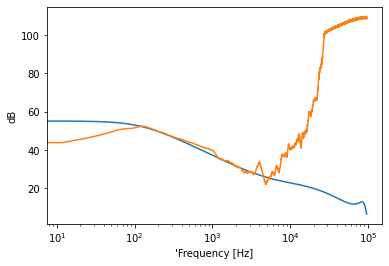

GA Process:3200/10000, Loss:0.07796654
GA Process:3201/10000, Loss:0.07796654
GA Process:3202/10000, Loss:0.07796654
GA Process:3203/10000, Loss:0.07796654
GA Process:3204/10000, Loss:0.07796654
GA Process:3205/10000, Loss:0.07796654
GA Process:3206/10000, Loss:0.07796654
GA Process:3207/10000, Loss:0.07796654
GA Process:3208/10000, Loss:0.07796654
GA Process:3209/10000, Loss:0.07796654
GA Process:3210/10000, Loss:0.07796654
GA Process:3211/10000, Loss:0.07796654
GA Process:3212/10000, Loss:0.07796654
GA Process:3213/10000, Loss:0.07796654
GA Process:3214/10000, Loss:0.07796654
GA Process:3215/10000, Loss:0.07796654
GA Process:3216/10000, Loss:0.07796654
GA Process:3217/10000, Loss:0.07796654
GA Process:3218/10000, Loss:0.07796654
GA Process:3219/10000, Loss:0.07796654
GA Process:3220/10000, Loss:0.07796654
GA Process:3221/10000, Loss:0.07796654
GA Process:3222/10000, Loss:0.07796654
GA Process:3223/10000, Loss:0.07796654
GA Process:3224/10000, Loss:0.07796654
GA Process:3225/10000, Lo

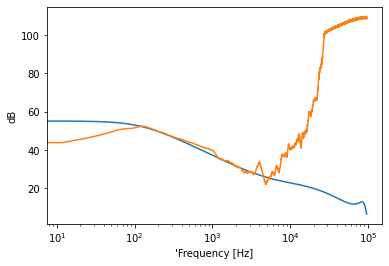

GA Process:3300/10000, Loss:0.07796654
GA Process:3301/10000, Loss:0.07796654
GA Process:3302/10000, Loss:0.07796654
GA Process:3303/10000, Loss:0.07796654
GA Process:3304/10000, Loss:0.07796654
GA Process:3305/10000, Loss:0.07796654
GA Process:3306/10000, Loss:0.07796654
GA Process:3307/10000, Loss:0.07796654
GA Process:3308/10000, Loss:0.07796654
GA Process:3309/10000, Loss:0.07796654
GA Process:3310/10000, Loss:0.07796654
GA Process:3311/10000, Loss:0.07796654
GA Process:3312/10000, Loss:0.07796654
GA Process:3313/10000, Loss:0.07796654
GA Process:3314/10000, Loss:0.07796654
GA Process:3315/10000, Loss:0.07796654
GA Process:3316/10000, Loss:0.07796654
GA Process:3317/10000, Loss:0.07796654
GA Process:3318/10000, Loss:0.07796654
GA Process:3319/10000, Loss:0.07796654
GA Process:3320/10000, Loss:0.07796654
GA Process:3321/10000, Loss:0.07796654
GA Process:3322/10000, Loss:0.07796654
GA Process:3323/10000, Loss:0.07796654
GA Process:3324/10000, Loss:0.07796654
GA Process:3325/10000, Lo

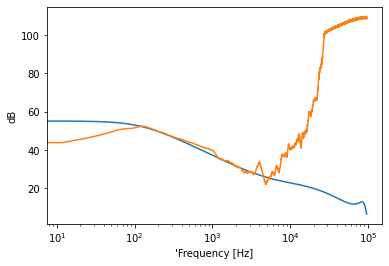

GA Process:3400/10000, Loss:0.07796654
GA Process:3401/10000, Loss:0.07796654
GA Process:3402/10000, Loss:0.07796654
GA Process:3403/10000, Loss:0.07796654
GA Process:3404/10000, Loss:0.07796654
GA Process:3405/10000, Loss:0.07796654
GA Process:3406/10000, Loss:0.07796654
GA Process:3407/10000, Loss:0.07796654
GA Process:3408/10000, Loss:0.07796654
GA Process:3409/10000, Loss:0.07796654
GA Process:3410/10000, Loss:0.07796654
GA Process:3411/10000, Loss:0.07796654
GA Process:3412/10000, Loss:0.07796654
GA Process:3413/10000, Loss:0.07796654
GA Process:3414/10000, Loss:0.07796654
GA Process:3415/10000, Loss:0.07796654
GA Process:3416/10000, Loss:0.07796654
GA Process:3417/10000, Loss:0.07796654
GA Process:3418/10000, Loss:0.07796654
GA Process:3419/10000, Loss:0.07796654
GA Process:3420/10000, Loss:0.07796654
GA Process:3421/10000, Loss:0.07796654
GA Process:3422/10000, Loss:0.07796654
GA Process:3423/10000, Loss:0.07796654
GA Process:3424/10000, Loss:0.07796654
GA Process:3425/10000, Lo

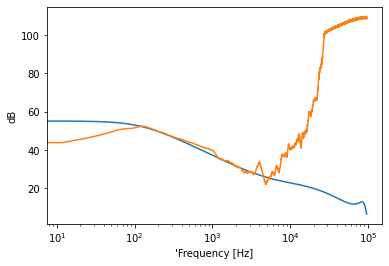

GA Process:3500/10000, Loss:0.07796654
GA Process:3501/10000, Loss:0.07796654
GA Process:3502/10000, Loss:0.07796654
GA Process:3503/10000, Loss:0.07796654
GA Process:3504/10000, Loss:0.07796654
GA Process:3505/10000, Loss:0.07796654
GA Process:3506/10000, Loss:0.07796654
GA Process:3507/10000, Loss:0.07796654
GA Process:3508/10000, Loss:0.07796654
GA Process:3509/10000, Loss:0.07796654
GA Process:3510/10000, Loss:0.07796654
GA Process:3511/10000, Loss:0.07796654
GA Process:3512/10000, Loss:0.07796654
GA Process:3513/10000, Loss:0.07796654
GA Process:3514/10000, Loss:0.07796654
GA Process:3515/10000, Loss:0.07796654
GA Process:3516/10000, Loss:0.07796654
GA Process:3517/10000, Loss:0.07796654
GA Process:3518/10000, Loss:0.07796654
GA Process:3519/10000, Loss:0.07796654
GA Process:3520/10000, Loss:0.07796654
GA Process:3521/10000, Loss:0.07796654
GA Process:3522/10000, Loss:0.07796654
GA Process:3523/10000, Loss:0.07796654
GA Process:3524/10000, Loss:0.07796654
GA Process:3525/10000, Lo

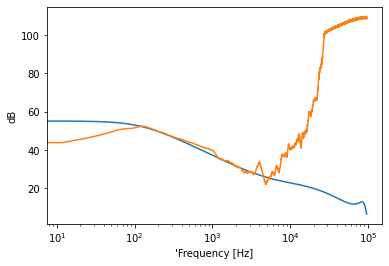

GA Process:3600/10000, Loss:0.07796654
GA Process:3601/10000, Loss:0.07796654
GA Process:3602/10000, Loss:0.07796654
GA Process:3603/10000, Loss:0.07796654
GA Process:3604/10000, Loss:0.07796654
GA Process:3605/10000, Loss:0.07796654
GA Process:3606/10000, Loss:0.07796654
GA Process:3607/10000, Loss:0.07796654
GA Process:3608/10000, Loss:0.07796654
GA Process:3609/10000, Loss:0.07796654
GA Process:3610/10000, Loss:0.07796654
GA Process:3611/10000, Loss:0.07796654
GA Process:3612/10000, Loss:0.07796654
GA Process:3613/10000, Loss:0.07796654
GA Process:3614/10000, Loss:0.07796654
GA Process:3615/10000, Loss:0.07796654
GA Process:3616/10000, Loss:0.07796654
GA Process:3617/10000, Loss:0.07796654
GA Process:3618/10000, Loss:0.07796654
GA Process:3619/10000, Loss:0.07796654
GA Process:3620/10000, Loss:0.07796654
GA Process:3621/10000, Loss:0.07796654
GA Process:3622/10000, Loss:0.07796654
GA Process:3623/10000, Loss:0.07796654
GA Process:3624/10000, Loss:0.07796654
GA Process:3625/10000, Lo

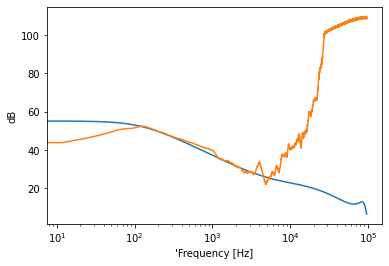

GA Process:3700/10000, Loss:0.07796654
GA Process:3701/10000, Loss:0.07796654
GA Process:3702/10000, Loss:0.07796654
GA Process:3703/10000, Loss:0.07796654
GA Process:3704/10000, Loss:0.07796654
GA Process:3705/10000, Loss:0.07796654
GA Process:3706/10000, Loss:0.07796654
GA Process:3707/10000, Loss:0.07796654
GA Process:3708/10000, Loss:0.07796654
GA Process:3709/10000, Loss:0.07796654
GA Process:3710/10000, Loss:0.07796654
GA Process:3711/10000, Loss:0.07796654
GA Process:3712/10000, Loss:0.07796654
GA Process:3713/10000, Loss:0.07796654
GA Process:3714/10000, Loss:0.07796654
GA Process:3715/10000, Loss:0.07796654
GA Process:3716/10000, Loss:0.07796654
GA Process:3717/10000, Loss:0.07796654
GA Process:3718/10000, Loss:0.07796654
GA Process:3719/10000, Loss:0.07796654
GA Process:3720/10000, Loss:0.07796654
GA Process:3721/10000, Loss:0.07796654
GA Process:3722/10000, Loss:0.07796654
GA Process:3723/10000, Loss:0.07796654
GA Process:3724/10000, Loss:0.07796654
GA Process:3725/10000, Lo

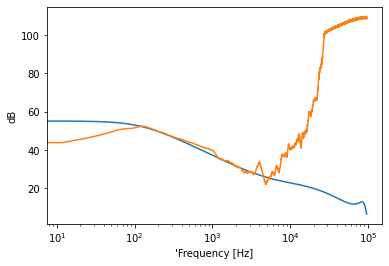

GA Process:3800/10000, Loss:0.07796654
GA Process:3801/10000, Loss:0.07796654
GA Process:3802/10000, Loss:0.07796654
GA Process:3803/10000, Loss:0.07796654
GA Process:3804/10000, Loss:0.07796654
GA Process:3805/10000, Loss:0.07796654
GA Process:3806/10000, Loss:0.07796654
GA Process:3807/10000, Loss:0.07796654
GA Process:3808/10000, Loss:0.07796654
GA Process:3809/10000, Loss:0.07796654
GA Process:3810/10000, Loss:0.07796654
GA Process:3811/10000, Loss:0.07796654
GA Process:3812/10000, Loss:0.07796654
GA Process:3813/10000, Loss:0.07796654
GA Process:3814/10000, Loss:0.07796654
GA Process:3815/10000, Loss:0.07796654
GA Process:3816/10000, Loss:0.07796654
GA Process:3817/10000, Loss:0.07796654
GA Process:3818/10000, Loss:0.07796654
GA Process:3819/10000, Loss:0.07796654
GA Process:3820/10000, Loss:0.07796654
GA Process:3821/10000, Loss:0.07796654
GA Process:3822/10000, Loss:0.07796654
GA Process:3823/10000, Loss:0.07796654
GA Process:3824/10000, Loss:0.07796654
GA Process:3825/10000, Lo

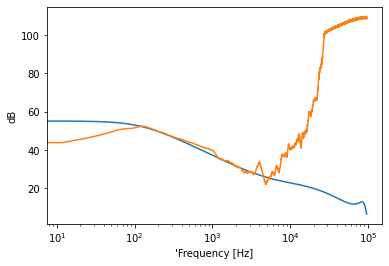

GA Process:3900/10000, Loss:0.07796654
GA Process:3901/10000, Loss:0.07796654
GA Process:3902/10000, Loss:0.07796654
GA Process:3903/10000, Loss:0.07796654
GA Process:3904/10000, Loss:0.07796654
GA Process:3905/10000, Loss:0.07796654
GA Process:3906/10000, Loss:0.07796654
GA Process:3907/10000, Loss:0.07796654
GA Process:3908/10000, Loss:0.07796654
GA Process:3909/10000, Loss:0.07796654
GA Process:3910/10000, Loss:0.07796654
GA Process:3911/10000, Loss:0.07796654
GA Process:3912/10000, Loss:0.07796654
GA Process:3913/10000, Loss:0.07796654
GA Process:3914/10000, Loss:0.07796654
GA Process:3915/10000, Loss:0.07796654
GA Process:3916/10000, Loss:0.07796654
GA Process:3917/10000, Loss:0.07796654
GA Process:3918/10000, Loss:0.07796654
GA Process:3919/10000, Loss:0.07796654
GA Process:3920/10000, Loss:0.07796654
GA Process:3921/10000, Loss:0.07796654
GA Process:3922/10000, Loss:0.07796654
GA Process:3923/10000, Loss:0.07796654
GA Process:3924/10000, Loss:0.07796654
GA Process:3925/10000, Lo

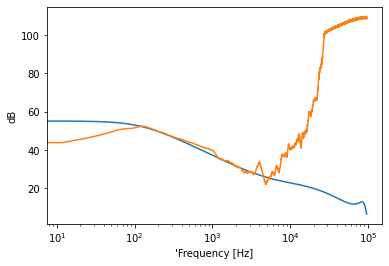

GA Process:4000/10000, Loss:0.07796654
GA Process:4001/10000, Loss:0.07796654
GA Process:4002/10000, Loss:0.07796654
GA Process:4003/10000, Loss:0.07796654
GA Process:4004/10000, Loss:0.07796654
GA Process:4005/10000, Loss:0.07796654
GA Process:4006/10000, Loss:0.07796654
GA Process:4007/10000, Loss:0.07796654
GA Process:4008/10000, Loss:0.07796654
GA Process:4009/10000, Loss:0.07796654
GA Process:4010/10000, Loss:0.07796654
GA Process:4011/10000, Loss:0.07796654
GA Process:4012/10000, Loss:0.07796654
GA Process:4013/10000, Loss:0.07796654
GA Process:4014/10000, Loss:0.07796654
GA Process:4015/10000, Loss:0.07796654
GA Process:4016/10000, Loss:0.07796654
GA Process:4017/10000, Loss:0.07796654
GA Process:4018/10000, Loss:0.07796654
GA Process:4019/10000, Loss:0.07796654
GA Process:4020/10000, Loss:0.07796654
GA Process:4021/10000, Loss:0.07796654
GA Process:4022/10000, Loss:0.07796654
GA Process:4023/10000, Loss:0.07796654
GA Process:4024/10000, Loss:0.07796654
GA Process:4025/10000, Lo

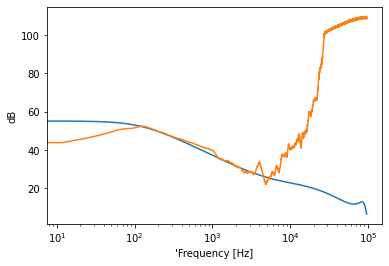

GA Process:4100/10000, Loss:0.07796654
GA Process:4101/10000, Loss:0.07796654
GA Process:4102/10000, Loss:0.07796654
GA Process:4103/10000, Loss:0.07796654
GA Process:4104/10000, Loss:0.07796654
GA Process:4105/10000, Loss:0.07796654
GA Process:4106/10000, Loss:0.07796654
GA Process:4107/10000, Loss:0.07796654
GA Process:4108/10000, Loss:0.07796654
GA Process:4109/10000, Loss:0.07796654
GA Process:4110/10000, Loss:0.07796654
GA Process:4111/10000, Loss:0.07796654
GA Process:4112/10000, Loss:0.07796654
GA Process:4113/10000, Loss:0.07796654
GA Process:4114/10000, Loss:0.07796654
GA Process:4115/10000, Loss:0.07796654
GA Process:4116/10000, Loss:0.07796654
GA Process:4117/10000, Loss:0.07796654
GA Process:4118/10000, Loss:0.07796654
GA Process:4119/10000, Loss:0.07796654
GA Process:4120/10000, Loss:0.07796654
GA Process:4121/10000, Loss:0.07796654
GA Process:4122/10000, Loss:0.07796654
GA Process:4123/10000, Loss:0.07796654
GA Process:4124/10000, Loss:0.07796654
GA Process:4125/10000, Lo

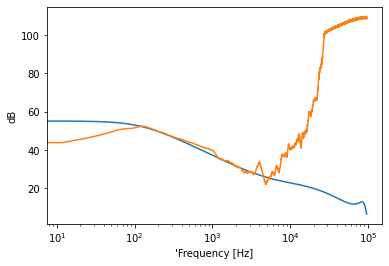

GA Process:4200/10000, Loss:0.07796654
GA Process:4201/10000, Loss:0.07796654
GA Process:4202/10000, Loss:0.07796654
GA Process:4203/10000, Loss:0.07796654
GA Process:4204/10000, Loss:0.07796654
GA Process:4205/10000, Loss:0.07796654
GA Process:4206/10000, Loss:0.07796654
GA Process:4207/10000, Loss:0.07796654
GA Process:4208/10000, Loss:0.07796654
GA Process:4209/10000, Loss:0.07796654
GA Process:4210/10000, Loss:0.07796654
GA Process:4211/10000, Loss:0.07796654
GA Process:4212/10000, Loss:0.07796654
GA Process:4213/10000, Loss:0.07796654
GA Process:4214/10000, Loss:0.07796654
GA Process:4215/10000, Loss:0.07796654
GA Process:4216/10000, Loss:0.07796654
GA Process:4217/10000, Loss:0.07796654
GA Process:4218/10000, Loss:0.07796654
GA Process:4219/10000, Loss:0.07796654
GA Process:4220/10000, Loss:0.07796654
GA Process:4221/10000, Loss:0.07796654
GA Process:4222/10000, Loss:0.07796654
GA Process:4223/10000, Loss:0.07796654
GA Process:4224/10000, Loss:0.07796654
GA Process:4225/10000, Lo

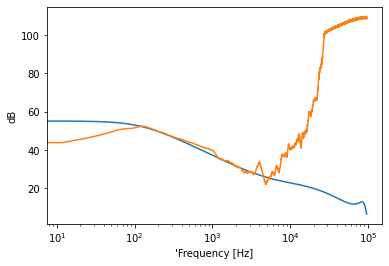

GA Process:4300/10000, Loss:0.07796654
GA Process:4301/10000, Loss:0.07796654
GA Process:4302/10000, Loss:0.07796654
GA Process:4303/10000, Loss:0.07796654
GA Process:4304/10000, Loss:0.07796654
GA Process:4305/10000, Loss:0.07796654
GA Process:4306/10000, Loss:0.07796654
GA Process:4307/10000, Loss:0.07796654
GA Process:4308/10000, Loss:0.07796654
GA Process:4309/10000, Loss:0.07796654
GA Process:4310/10000, Loss:0.07796654
GA Process:4311/10000, Loss:0.07796654
GA Process:4312/10000, Loss:0.07796654
GA Process:4313/10000, Loss:0.07796654
GA Process:4314/10000, Loss:0.07796654
GA Process:4315/10000, Loss:0.07796654
GA Process:4316/10000, Loss:0.07796654
GA Process:4317/10000, Loss:0.07796654
GA Process:4318/10000, Loss:0.07796654
GA Process:4319/10000, Loss:0.07796654
GA Process:4320/10000, Loss:0.07796654
GA Process:4321/10000, Loss:0.07796654
GA Process:4322/10000, Loss:0.07796654
GA Process:4323/10000, Loss:0.07796654
GA Process:4324/10000, Loss:0.07796654
GA Process:4325/10000, Lo

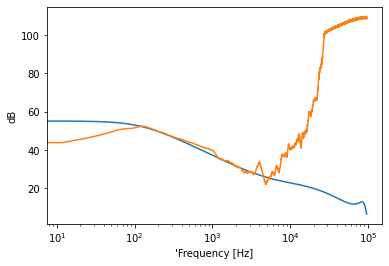

GA Process:4400/10000, Loss:0.07796654
GA Process:4401/10000, Loss:0.07796654
GA Process:4402/10000, Loss:0.07796654
GA Process:4403/10000, Loss:0.07796654
GA Process:4404/10000, Loss:0.07796654
GA Process:4405/10000, Loss:0.07796654
GA Process:4406/10000, Loss:0.07796654
GA Process:4407/10000, Loss:0.07796654
GA Process:4408/10000, Loss:0.07796654
GA Process:4409/10000, Loss:0.07796654
GA Process:4410/10000, Loss:0.07796654
GA Process:4411/10000, Loss:0.07796654
GA Process:4412/10000, Loss:0.07796654
GA Process:4413/10000, Loss:0.07796654
GA Process:4414/10000, Loss:0.07796654
GA Process:4415/10000, Loss:0.07796654
GA Process:4416/10000, Loss:0.07796654
GA Process:4417/10000, Loss:0.07796654
GA Process:4418/10000, Loss:0.07796654
GA Process:4419/10000, Loss:0.07796654
GA Process:4420/10000, Loss:0.07796654
GA Process:4421/10000, Loss:0.07796654
GA Process:4422/10000, Loss:0.07796654
GA Process:4423/10000, Loss:0.07796654
GA Process:4424/10000, Loss:0.07796654
GA Process:4425/10000, Lo

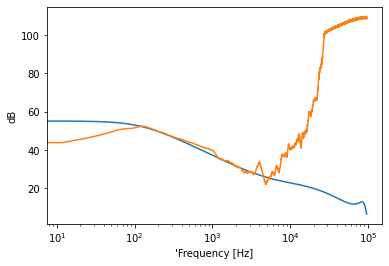

GA Process:4500/10000, Loss:0.07796654
GA Process:4501/10000, Loss:0.07796654
GA Process:4502/10000, Loss:0.07796654
GA Process:4503/10000, Loss:0.07796654
GA Process:4504/10000, Loss:0.07796654
GA Process:4505/10000, Loss:0.07796654
GA Process:4506/10000, Loss:0.07796654
GA Process:4507/10000, Loss:0.07796654
GA Process:4508/10000, Loss:0.07796654
GA Process:4509/10000, Loss:0.07796654
GA Process:4510/10000, Loss:0.07796654
GA Process:4511/10000, Loss:0.07796654
GA Process:4512/10000, Loss:0.07796654
GA Process:4513/10000, Loss:0.07796654
GA Process:4514/10000, Loss:0.07796654
GA Process:4515/10000, Loss:0.07796654
GA Process:4516/10000, Loss:0.07796654
GA Process:4517/10000, Loss:0.07796654
GA Process:4518/10000, Loss:0.07796654
GA Process:4519/10000, Loss:0.07796654
GA Process:4520/10000, Loss:0.07796654
GA Process:4521/10000, Loss:0.07796654
GA Process:4522/10000, Loss:0.07796654
GA Process:4523/10000, Loss:0.07796654
GA Process:4524/10000, Loss:0.07796654
GA Process:4525/10000, Lo

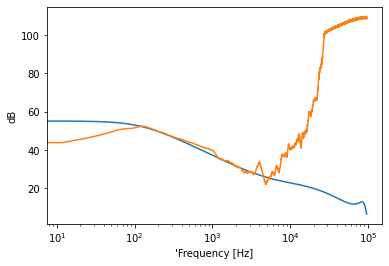

GA Process:4600/10000, Loss:0.07796654
GA Process:4601/10000, Loss:0.07796654
GA Process:4602/10000, Loss:0.07796654
GA Process:4603/10000, Loss:0.07796654
GA Process:4604/10000, Loss:0.07796654
GA Process:4605/10000, Loss:0.07796654
GA Process:4606/10000, Loss:0.07796654
GA Process:4607/10000, Loss:0.07796654
GA Process:4608/10000, Loss:0.07796654
GA Process:4609/10000, Loss:0.07796654
GA Process:4610/10000, Loss:0.07796654
GA Process:4611/10000, Loss:0.07796654
GA Process:4612/10000, Loss:0.07796654
GA Process:4613/10000, Loss:0.07796654
GA Process:4614/10000, Loss:0.07796654
GA Process:4615/10000, Loss:0.07796654
GA Process:4616/10000, Loss:0.07796654
GA Process:4617/10000, Loss:0.07796654
GA Process:4618/10000, Loss:0.07796654
GA Process:4619/10000, Loss:0.07796654
GA Process:4620/10000, Loss:0.07796654
GA Process:4621/10000, Loss:0.07796654
GA Process:4622/10000, Loss:0.07796654
GA Process:4623/10000, Loss:0.07796654
GA Process:4624/10000, Loss:0.07796654
GA Process:4625/10000, Lo

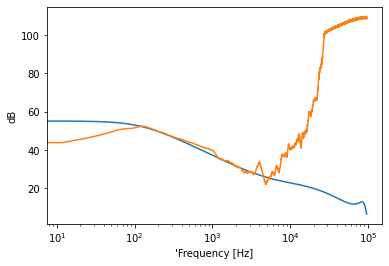

GA Process:4700/10000, Loss:0.07796654
GA Process:4701/10000, Loss:0.07796654
GA Process:4702/10000, Loss:0.07796654
GA Process:4703/10000, Loss:0.07796654
GA Process:4704/10000, Loss:0.07796654
GA Process:4705/10000, Loss:0.07796654
GA Process:4706/10000, Loss:0.07796654
GA Process:4707/10000, Loss:0.07796654
GA Process:4708/10000, Loss:0.07796654
GA Process:4709/10000, Loss:0.07796654
GA Process:4710/10000, Loss:0.07796654
GA Process:4711/10000, Loss:0.07796654
GA Process:4712/10000, Loss:0.07796654
GA Process:4713/10000, Loss:0.07796654
GA Process:4714/10000, Loss:0.07796654
GA Process:4715/10000, Loss:0.07796654
GA Process:4716/10000, Loss:0.07796654
GA Process:4717/10000, Loss:0.07796654
GA Process:4718/10000, Loss:0.07796654
GA Process:4719/10000, Loss:0.07796654
GA Process:4720/10000, Loss:0.07796654
GA Process:4721/10000, Loss:0.07796654
GA Process:4722/10000, Loss:0.07796654
GA Process:4723/10000, Loss:0.07796654
GA Process:4724/10000, Loss:0.07796654
GA Process:4725/10000, Lo

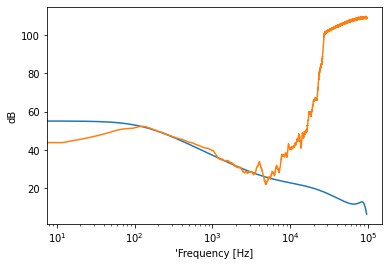

GA Process:4800/10000, Loss:0.07796653
GA Process:4801/10000, Loss:0.07796653
GA Process:4802/10000, Loss:0.07796653
GA Process:4803/10000, Loss:0.07796653
GA Process:4804/10000, Loss:0.07796653
GA Process:4805/10000, Loss:0.07796653
GA Process:4806/10000, Loss:0.07796653
GA Process:4807/10000, Loss:0.07796653
GA Process:4808/10000, Loss:0.07796653
GA Process:4809/10000, Loss:0.07796653
GA Process:4810/10000, Loss:0.07796653
GA Process:4811/10000, Loss:0.07796653
GA Process:4812/10000, Loss:0.07796653
GA Process:4813/10000, Loss:0.07796653
GA Process:4814/10000, Loss:0.07796653
GA Process:4815/10000, Loss:0.07796653
GA Process:4816/10000, Loss:0.07796653
GA Process:4817/10000, Loss:0.07796653
GA Process:4818/10000, Loss:0.07796653
GA Process:4819/10000, Loss:0.07796653
GA Process:4820/10000, Loss:0.07796653
GA Process:4821/10000, Loss:0.07796653
GA Process:4822/10000, Loss:0.07796653
GA Process:4823/10000, Loss:0.07796653
GA Process:4824/10000, Loss:0.07796653
GA Process:4825/10000, Lo

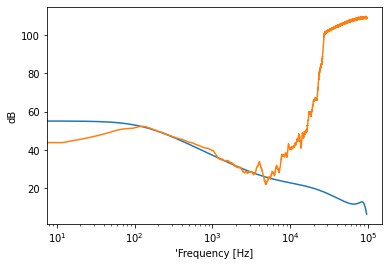

GA Process:4900/10000, Loss:0.07796653
GA Process:4901/10000, Loss:0.07796653
GA Process:4902/10000, Loss:0.07796653
GA Process:4903/10000, Loss:0.07796653
GA Process:4904/10000, Loss:0.07796653
GA Process:4905/10000, Loss:0.07796653
GA Process:4906/10000, Loss:0.07796653
GA Process:4907/10000, Loss:0.07796653
GA Process:4908/10000, Loss:0.07796653
GA Process:4909/10000, Loss:0.07796653
GA Process:4910/10000, Loss:0.07796653
GA Process:4911/10000, Loss:0.07796653
GA Process:4912/10000, Loss:0.07796653
GA Process:4913/10000, Loss:0.07796653
GA Process:4914/10000, Loss:0.07796653
GA Process:4915/10000, Loss:0.07796653
GA Process:4916/10000, Loss:0.07796653
GA Process:4917/10000, Loss:0.07796653
GA Process:4918/10000, Loss:0.07796653
GA Process:4919/10000, Loss:0.07796653
GA Process:4920/10000, Loss:0.07796653
GA Process:4921/10000, Loss:0.07796653
GA Process:4922/10000, Loss:0.07796653
GA Process:4923/10000, Loss:0.07796653
GA Process:4924/10000, Loss:0.07796653
GA Process:4925/10000, Lo

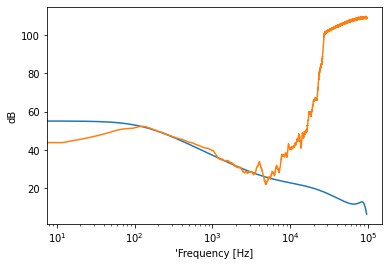

GA Process:5000/10000, Loss:0.07796653
GA Process:5001/10000, Loss:0.07796653
GA Process:5002/10000, Loss:0.07796653
GA Process:5003/10000, Loss:0.07796653
GA Process:5004/10000, Loss:0.07796653
GA Process:5005/10000, Loss:0.07796653
GA Process:5006/10000, Loss:0.07796653
GA Process:5007/10000, Loss:0.07796653
GA Process:5008/10000, Loss:0.07796653
GA Process:5009/10000, Loss:0.07796653
GA Process:5010/10000, Loss:0.07796653
GA Process:5011/10000, Loss:0.07796653
GA Process:5012/10000, Loss:0.07796653
GA Process:5013/10000, Loss:0.07796653
GA Process:5014/10000, Loss:0.07796653
GA Process:5015/10000, Loss:0.07796653
GA Process:5016/10000, Loss:0.07796653
GA Process:5017/10000, Loss:0.07796653
GA Process:5018/10000, Loss:0.07796653
GA Process:5019/10000, Loss:0.07796653
GA Process:5020/10000, Loss:0.07796653
GA Process:5021/10000, Loss:0.07796653
GA Process:5022/10000, Loss:0.07796653
GA Process:5023/10000, Loss:0.07796653
GA Process:5024/10000, Loss:0.07796653
GA Process:5025/10000, Lo

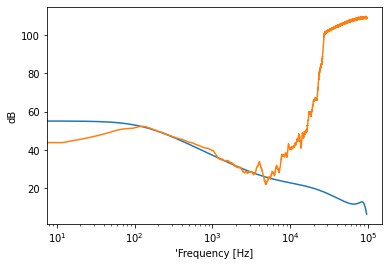

GA Process:5100/10000, Loss:0.07796653
GA Process:5101/10000, Loss:0.07796653
GA Process:5102/10000, Loss:0.07796653
GA Process:5103/10000, Loss:0.07796653
GA Process:5104/10000, Loss:0.07796653
GA Process:5105/10000, Loss:0.07796653
GA Process:5106/10000, Loss:0.07796653
GA Process:5107/10000, Loss:0.07796653
GA Process:5108/10000, Loss:0.07796653
GA Process:5109/10000, Loss:0.07796653
GA Process:5110/10000, Loss:0.07796653
GA Process:5111/10000, Loss:0.07796653
GA Process:5112/10000, Loss:0.07796653
GA Process:5113/10000, Loss:0.07796653
GA Process:5114/10000, Loss:0.07796653
GA Process:5115/10000, Loss:0.07796653
GA Process:5116/10000, Loss:0.07796653
GA Process:5117/10000, Loss:0.07796653
GA Process:5118/10000, Loss:0.07796653
GA Process:5119/10000, Loss:0.07796653
GA Process:5120/10000, Loss:0.07796653
GA Process:5121/10000, Loss:0.07796653
GA Process:5122/10000, Loss:0.07796653
GA Process:5123/10000, Loss:0.07796653
GA Process:5124/10000, Loss:0.07796653
GA Process:5125/10000, Lo

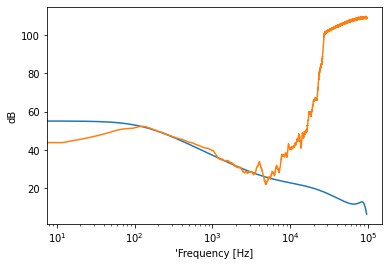

GA Process:5200/10000, Loss:0.07796653
GA Process:5201/10000, Loss:0.07796653
GA Process:5202/10000, Loss:0.07796653
GA Process:5203/10000, Loss:0.07796653
GA Process:5204/10000, Loss:0.07796653
GA Process:5205/10000, Loss:0.07796653
GA Process:5206/10000, Loss:0.07796653
GA Process:5207/10000, Loss:0.07796653
GA Process:5208/10000, Loss:0.07796653
GA Process:5209/10000, Loss:0.07796653
GA Process:5210/10000, Loss:0.07796653
GA Process:5211/10000, Loss:0.07796653
GA Process:5212/10000, Loss:0.07796653
GA Process:5213/10000, Loss:0.07796653
GA Process:5214/10000, Loss:0.07796653
GA Process:5215/10000, Loss:0.07796653
GA Process:5216/10000, Loss:0.07796653
GA Process:5217/10000, Loss:0.07796653
GA Process:5218/10000, Loss:0.07796653
GA Process:5219/10000, Loss:0.07796653
GA Process:5220/10000, Loss:0.07796653
GA Process:5221/10000, Loss:0.07796653
GA Process:5222/10000, Loss:0.07796653
GA Process:5223/10000, Loss:0.07796653
GA Process:5224/10000, Loss:0.07796653
GA Process:5225/10000, Lo

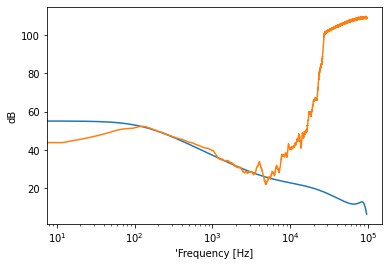

GA Process:5300/10000, Loss:0.07796653
GA Process:5301/10000, Loss:0.07796653
GA Process:5302/10000, Loss:0.07796653
GA Process:5303/10000, Loss:0.07796653
GA Process:5304/10000, Loss:0.07796653
GA Process:5305/10000, Loss:0.07796653
GA Process:5306/10000, Loss:0.07796653
GA Process:5307/10000, Loss:0.07796653
GA Process:5308/10000, Loss:0.07796653
GA Process:5309/10000, Loss:0.07796653
GA Process:5310/10000, Loss:0.07796653
GA Process:5311/10000, Loss:0.07796653
GA Process:5312/10000, Loss:0.07796653
GA Process:5313/10000, Loss:0.07796653
GA Process:5314/10000, Loss:0.07796653
GA Process:5315/10000, Loss:0.07796653
GA Process:5316/10000, Loss:0.07796653
GA Process:5317/10000, Loss:0.07796653
GA Process:5318/10000, Loss:0.07796653
GA Process:5319/10000, Loss:0.07796653
GA Process:5320/10000, Loss:0.07796653
GA Process:5321/10000, Loss:0.07796653
GA Process:5322/10000, Loss:0.07796653
GA Process:5323/10000, Loss:0.07796653
GA Process:5324/10000, Loss:0.07796653
GA Process:5325/10000, Lo

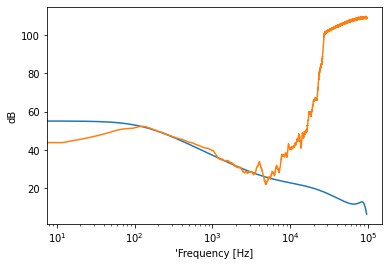

GA Process:5400/10000, Loss:0.07796653
GA Process:5401/10000, Loss:0.07796653
GA Process:5402/10000, Loss:0.07796653
GA Process:5403/10000, Loss:0.07796653
GA Process:5404/10000, Loss:0.07796653
GA Process:5405/10000, Loss:0.07796653
GA Process:5406/10000, Loss:0.07796653
GA Process:5407/10000, Loss:0.07796653
GA Process:5408/10000, Loss:0.07796653
GA Process:5409/10000, Loss:0.07796653
GA Process:5410/10000, Loss:0.07796653
GA Process:5411/10000, Loss:0.07796653
GA Process:5412/10000, Loss:0.07796653
GA Process:5413/10000, Loss:0.07796653
GA Process:5414/10000, Loss:0.07796653
GA Process:5415/10000, Loss:0.07796653
GA Process:5416/10000, Loss:0.07796653
GA Process:5417/10000, Loss:0.07796653
GA Process:5418/10000, Loss:0.07796653
GA Process:5419/10000, Loss:0.07796653
GA Process:5420/10000, Loss:0.07796653
GA Process:5421/10000, Loss:0.07796653
GA Process:5422/10000, Loss:0.07796653
GA Process:5423/10000, Loss:0.07796653
GA Process:5424/10000, Loss:0.07796653
GA Process:5425/10000, Lo

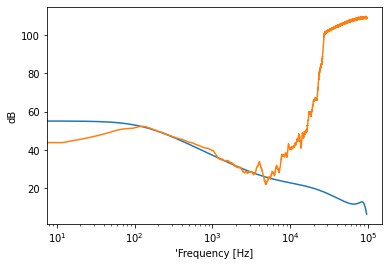

GA Process:5500/10000, Loss:0.07796653
GA Process:5501/10000, Loss:0.07796653
GA Process:5502/10000, Loss:0.07796653
GA Process:5503/10000, Loss:0.07796653
GA Process:5504/10000, Loss:0.07796653
GA Process:5505/10000, Loss:0.07796653
GA Process:5506/10000, Loss:0.07796653
GA Process:5507/10000, Loss:0.07796653
GA Process:5508/10000, Loss:0.07796653
GA Process:5509/10000, Loss:0.07796653
GA Process:5510/10000, Loss:0.07796653
GA Process:5511/10000, Loss:0.07796653
GA Process:5512/10000, Loss:0.07796653
GA Process:5513/10000, Loss:0.07796653
GA Process:5514/10000, Loss:0.07796653
GA Process:5515/10000, Loss:0.07796653
GA Process:5516/10000, Loss:0.07796653
GA Process:5517/10000, Loss:0.07796653
GA Process:5518/10000, Loss:0.07796653
GA Process:5519/10000, Loss:0.07796653
GA Process:5520/10000, Loss:0.07796653
GA Process:5521/10000, Loss:0.07796653
GA Process:5522/10000, Loss:0.07796653
GA Process:5523/10000, Loss:0.07796653
GA Process:5524/10000, Loss:0.07796653
GA Process:5525/10000, Lo

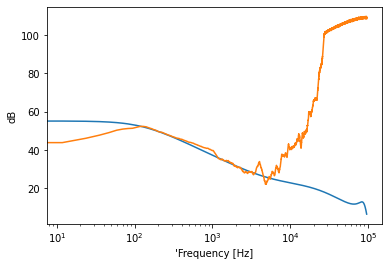

GA Process:5600/10000, Loss:0.07796653
GA Process:5601/10000, Loss:0.07796653
GA Process:5602/10000, Loss:0.07796653
GA Process:5603/10000, Loss:0.07796653
GA Process:5604/10000, Loss:0.07796653
GA Process:5605/10000, Loss:0.07796653
GA Process:5606/10000, Loss:0.07796653
GA Process:5607/10000, Loss:0.07796653
GA Process:5608/10000, Loss:0.07796653
GA Process:5609/10000, Loss:0.07796653
GA Process:5610/10000, Loss:0.07796653
GA Process:5611/10000, Loss:0.07796653
GA Process:5612/10000, Loss:0.07796653
GA Process:5613/10000, Loss:0.07796653
GA Process:5614/10000, Loss:0.07796653
GA Process:5615/10000, Loss:0.07796653
GA Process:5616/10000, Loss:0.07796653
GA Process:5617/10000, Loss:0.07796653
GA Process:5618/10000, Loss:0.07796653
GA Process:5619/10000, Loss:0.07796653
GA Process:5620/10000, Loss:0.07796653
GA Process:5621/10000, Loss:0.07796653
GA Process:5622/10000, Loss:0.07796653
GA Process:5623/10000, Loss:0.07796653
GA Process:5624/10000, Loss:0.07796653
GA Process:5625/10000, Lo

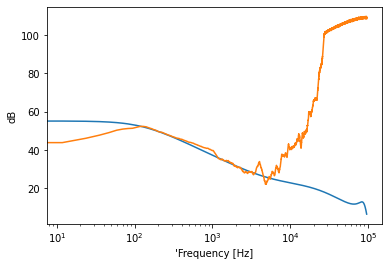

GA Process:5700/10000, Loss:0.07796653
GA Process:5701/10000, Loss:0.07796653
GA Process:5702/10000, Loss:0.07796653
GA Process:5703/10000, Loss:0.07796653
GA Process:5704/10000, Loss:0.07796653
GA Process:5705/10000, Loss:0.07796653
GA Process:5706/10000, Loss:0.07796653
GA Process:5707/10000, Loss:0.07796653
GA Process:5708/10000, Loss:0.07796653
GA Process:5709/10000, Loss:0.07796653
GA Process:5710/10000, Loss:0.07796653
GA Process:5711/10000, Loss:0.07796653
GA Process:5712/10000, Loss:0.07796653
GA Process:5713/10000, Loss:0.07796653
GA Process:5714/10000, Loss:0.07796653
GA Process:5715/10000, Loss:0.07796653
GA Process:5716/10000, Loss:0.07796653
GA Process:5717/10000, Loss:0.07796653
GA Process:5718/10000, Loss:0.07796653
GA Process:5719/10000, Loss:0.07796653
GA Process:5720/10000, Loss:0.07796653
GA Process:5721/10000, Loss:0.07796653
GA Process:5722/10000, Loss:0.07796653
GA Process:5723/10000, Loss:0.07796653
GA Process:5724/10000, Loss:0.07796653
GA Process:5725/10000, Lo

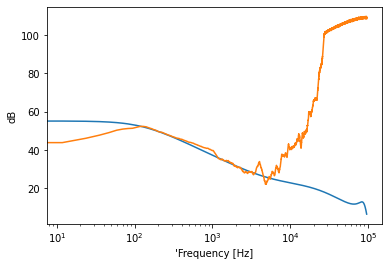

GA Process:5800/10000, Loss:0.07796653
GA Process:5801/10000, Loss:0.07796653
GA Process:5802/10000, Loss:0.07796653
GA Process:5803/10000, Loss:0.07796653
GA Process:5804/10000, Loss:0.07796653
GA Process:5805/10000, Loss:0.07796653
GA Process:5806/10000, Loss:0.07796653
GA Process:5807/10000, Loss:0.07796653
GA Process:5808/10000, Loss:0.07796653
GA Process:5809/10000, Loss:0.07796653
GA Process:5810/10000, Loss:0.07796653
GA Process:5811/10000, Loss:0.07796653
GA Process:5812/10000, Loss:0.07796653
GA Process:5813/10000, Loss:0.07796653
GA Process:5814/10000, Loss:0.07796653
GA Process:5815/10000, Loss:0.07796653
GA Process:5816/10000, Loss:0.07796653
GA Process:5817/10000, Loss:0.07796653
GA Process:5818/10000, Loss:0.07796653
GA Process:5819/10000, Loss:0.07796653
GA Process:5820/10000, Loss:0.07796653
GA Process:5821/10000, Loss:0.07796653
GA Process:5822/10000, Loss:0.07796653
GA Process:5823/10000, Loss:0.07796653
GA Process:5824/10000, Loss:0.07796653
GA Process:5825/10000, Lo

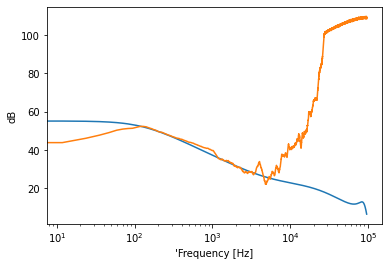

GA Process:5900/10000, Loss:0.07796653
GA Process:5901/10000, Loss:0.07796653
GA Process:5902/10000, Loss:0.07796653
GA Process:5903/10000, Loss:0.07796653
GA Process:5904/10000, Loss:0.07796653
GA Process:5905/10000, Loss:0.07796653
GA Process:5906/10000, Loss:0.07796653
GA Process:5907/10000, Loss:0.07796653
GA Process:5908/10000, Loss:0.07796653
GA Process:5909/10000, Loss:0.07796653
GA Process:5910/10000, Loss:0.07796653
GA Process:5911/10000, Loss:0.07796653
GA Process:5912/10000, Loss:0.07796653
GA Process:5913/10000, Loss:0.07796653
GA Process:5914/10000, Loss:0.07796653
GA Process:5915/10000, Loss:0.07796653
GA Process:5916/10000, Loss:0.07796653
GA Process:5917/10000, Loss:0.07796653
GA Process:5918/10000, Loss:0.07796653
GA Process:5919/10000, Loss:0.07796653
GA Process:5920/10000, Loss:0.07796653
GA Process:5921/10000, Loss:0.07796653
GA Process:5922/10000, Loss:0.07796653
GA Process:5923/10000, Loss:0.07796653
GA Process:5924/10000, Loss:0.07796653
GA Process:5925/10000, Lo

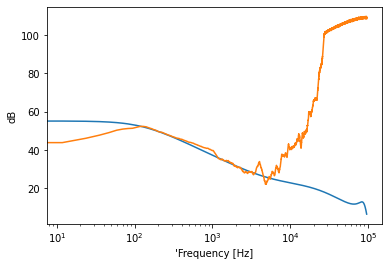

GA Process:6000/10000, Loss:0.07796653
GA Process:6001/10000, Loss:0.07796653
GA Process:6002/10000, Loss:0.07796653
GA Process:6003/10000, Loss:0.07796653
GA Process:6004/10000, Loss:0.07796653
GA Process:6005/10000, Loss:0.07796653
GA Process:6006/10000, Loss:0.07796653
GA Process:6007/10000, Loss:0.07796653
GA Process:6008/10000, Loss:0.07796653
GA Process:6009/10000, Loss:0.07796653
GA Process:6010/10000, Loss:0.07796653
GA Process:6011/10000, Loss:0.07796653
GA Process:6012/10000, Loss:0.07796653
GA Process:6013/10000, Loss:0.07796653
GA Process:6014/10000, Loss:0.07796653
GA Process:6015/10000, Loss:0.07796653
GA Process:6016/10000, Loss:0.07796653
GA Process:6017/10000, Loss:0.07796653
GA Process:6018/10000, Loss:0.07796653
GA Process:6019/10000, Loss:0.07796653
GA Process:6020/10000, Loss:0.07796653
GA Process:6021/10000, Loss:0.07796653
GA Process:6022/10000, Loss:0.07796653
GA Process:6023/10000, Loss:0.07796653
GA Process:6024/10000, Loss:0.07796653
GA Process:6025/10000, Lo

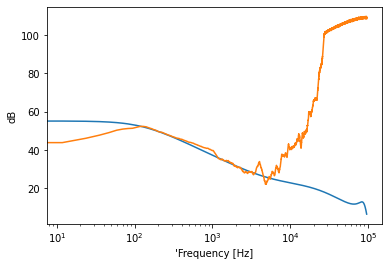

GA Process:6100/10000, Loss:0.07796653
GA Process:6101/10000, Loss:0.07796653
GA Process:6102/10000, Loss:0.07796653
GA Process:6103/10000, Loss:0.07796653
GA Process:6104/10000, Loss:0.07796653
GA Process:6105/10000, Loss:0.07796653
GA Process:6106/10000, Loss:0.07796653
GA Process:6107/10000, Loss:0.07796653
GA Process:6108/10000, Loss:0.07796653
GA Process:6109/10000, Loss:0.07796653
GA Process:6110/10000, Loss:0.07796653
GA Process:6111/10000, Loss:0.07796653
GA Process:6112/10000, Loss:0.07796653
GA Process:6113/10000, Loss:0.07796653
GA Process:6114/10000, Loss:0.07796653
GA Process:6115/10000, Loss:0.07796653
GA Process:6116/10000, Loss:0.07796653
GA Process:6117/10000, Loss:0.07796653
GA Process:6118/10000, Loss:0.07796653
GA Process:6119/10000, Loss:0.07796653
GA Process:6120/10000, Loss:0.07796653
GA Process:6121/10000, Loss:0.07796653
GA Process:6122/10000, Loss:0.07796653
GA Process:6123/10000, Loss:0.07796653
GA Process:6124/10000, Loss:0.07796653
GA Process:6125/10000, Lo

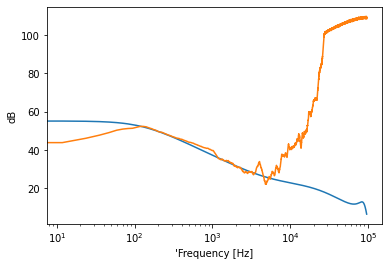

GA Process:6200/10000, Loss:0.07796653
GA Process:6201/10000, Loss:0.07796653
GA Process:6202/10000, Loss:0.07796653
GA Process:6203/10000, Loss:0.07796653
GA Process:6204/10000, Loss:0.07796653
GA Process:6205/10000, Loss:0.07796653
GA Process:6206/10000, Loss:0.07796653
GA Process:6207/10000, Loss:0.07796653
GA Process:6208/10000, Loss:0.07796653
GA Process:6209/10000, Loss:0.07796653
GA Process:6210/10000, Loss:0.07796653
GA Process:6211/10000, Loss:0.07796653
GA Process:6212/10000, Loss:0.07796653
GA Process:6213/10000, Loss:0.07796653
GA Process:6214/10000, Loss:0.07796653
GA Process:6215/10000, Loss:0.07796653
GA Process:6216/10000, Loss:0.07796653
GA Process:6217/10000, Loss:0.07796653
GA Process:6218/10000, Loss:0.07796653
GA Process:6219/10000, Loss:0.07796653
GA Process:6220/10000, Loss:0.07796653
GA Process:6221/10000, Loss:0.07796653
GA Process:6222/10000, Loss:0.07796653
GA Process:6223/10000, Loss:0.07796653
GA Process:6224/10000, Loss:0.07796653
GA Process:6225/10000, Lo

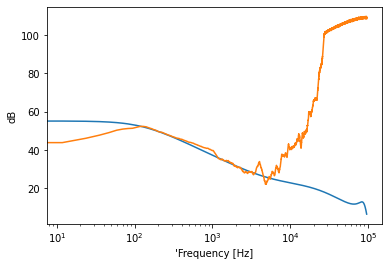

GA Process:6300/10000, Loss:0.07796653
GA Process:6301/10000, Loss:0.07796653
GA Process:6302/10000, Loss:0.07796653
GA Process:6303/10000, Loss:0.07796653
GA Process:6304/10000, Loss:0.07796653
GA Process:6305/10000, Loss:0.07796653
GA Process:6306/10000, Loss:0.07796653
GA Process:6307/10000, Loss:0.07796653
GA Process:6308/10000, Loss:0.07796653
GA Process:6309/10000, Loss:0.07796653
GA Process:6310/10000, Loss:0.07796653
GA Process:6311/10000, Loss:0.07796653
GA Process:6312/10000, Loss:0.07796653
GA Process:6313/10000, Loss:0.07796653
GA Process:6314/10000, Loss:0.07796653
GA Process:6315/10000, Loss:0.07796653
GA Process:6316/10000, Loss:0.07796653
GA Process:6317/10000, Loss:0.07796653
GA Process:6318/10000, Loss:0.07796653
GA Process:6319/10000, Loss:0.07796653
GA Process:6320/10000, Loss:0.07796653
GA Process:6321/10000, Loss:0.07796653
GA Process:6322/10000, Loss:0.07796653
GA Process:6323/10000, Loss:0.07796653
GA Process:6324/10000, Loss:0.07796653
GA Process:6325/10000, Lo

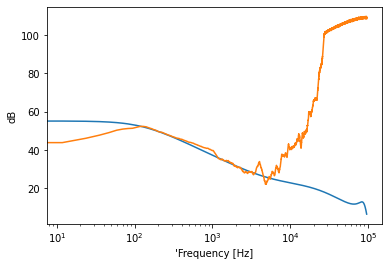

GA Process:6400/10000, Loss:0.07796653
GA Process:6401/10000, Loss:0.07796653
GA Process:6402/10000, Loss:0.07796653
GA Process:6403/10000, Loss:0.07796653
GA Process:6404/10000, Loss:0.07796653
GA Process:6405/10000, Loss:0.07796653
GA Process:6406/10000, Loss:0.07796653
GA Process:6407/10000, Loss:0.07796653
GA Process:6408/10000, Loss:0.07796653
GA Process:6409/10000, Loss:0.07796653
GA Process:6410/10000, Loss:0.07796653
GA Process:6411/10000, Loss:0.07796653
GA Process:6412/10000, Loss:0.07796653
GA Process:6413/10000, Loss:0.07796653
GA Process:6414/10000, Loss:0.07796653
GA Process:6415/10000, Loss:0.07796653
GA Process:6416/10000, Loss:0.07796653
GA Process:6417/10000, Loss:0.07796653
GA Process:6418/10000, Loss:0.07796653
GA Process:6419/10000, Loss:0.07796653
GA Process:6420/10000, Loss:0.07796653
GA Process:6421/10000, Loss:0.07796653
GA Process:6422/10000, Loss:0.07796653
GA Process:6423/10000, Loss:0.07796653
GA Process:6424/10000, Loss:0.07796653
GA Process:6425/10000, Lo

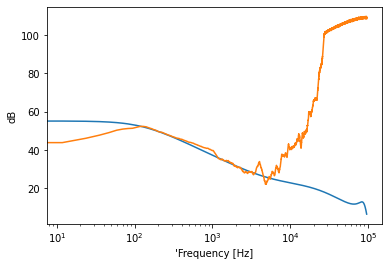

GA Process:6500/10000, Loss:0.07796653
GA Process:6501/10000, Loss:0.07796653
GA Process:6502/10000, Loss:0.07796653
GA Process:6503/10000, Loss:0.07796653
GA Process:6504/10000, Loss:0.07796653
GA Process:6505/10000, Loss:0.07796653
GA Process:6506/10000, Loss:0.07796653
GA Process:6507/10000, Loss:0.07796653
GA Process:6508/10000, Loss:0.07796653
GA Process:6509/10000, Loss:0.07796653
GA Process:6510/10000, Loss:0.07796653
GA Process:6511/10000, Loss:0.07796653
GA Process:6512/10000, Loss:0.07796653
GA Process:6513/10000, Loss:0.07796653
GA Process:6514/10000, Loss:0.07796653
GA Process:6515/10000, Loss:0.07796653
GA Process:6516/10000, Loss:0.07796653
GA Process:6517/10000, Loss:0.07796653
GA Process:6518/10000, Loss:0.07796653
GA Process:6519/10000, Loss:0.07796653
GA Process:6520/10000, Loss:0.07796653
GA Process:6521/10000, Loss:0.07796653
GA Process:6522/10000, Loss:0.07796653
GA Process:6523/10000, Loss:0.07796653
GA Process:6524/10000, Loss:0.07796653
GA Process:6525/10000, Lo

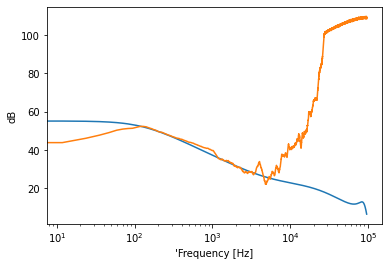

GA Process:6600/10000, Loss:0.07796653
GA Process:6601/10000, Loss:0.07796653
GA Process:6602/10000, Loss:0.07796653
GA Process:6603/10000, Loss:0.07796653
GA Process:6604/10000, Loss:0.07796653
GA Process:6605/10000, Loss:0.07796653
GA Process:6606/10000, Loss:0.07796653
GA Process:6607/10000, Loss:0.07796653
GA Process:6608/10000, Loss:0.07796653
GA Process:6609/10000, Loss:0.07796653
GA Process:6610/10000, Loss:0.07796653
GA Process:6611/10000, Loss:0.07796653
GA Process:6612/10000, Loss:0.07796653
GA Process:6613/10000, Loss:0.07796653
GA Process:6614/10000, Loss:0.07796653
GA Process:6615/10000, Loss:0.07796653
GA Process:6616/10000, Loss:0.07796653
GA Process:6617/10000, Loss:0.07796653
GA Process:6618/10000, Loss:0.07796653
GA Process:6619/10000, Loss:0.07796653
GA Process:6620/10000, Loss:0.07796653
GA Process:6621/10000, Loss:0.07796653
GA Process:6622/10000, Loss:0.07796653
GA Process:6623/10000, Loss:0.07796653
GA Process:6624/10000, Loss:0.07796653
GA Process:6625/10000, Lo

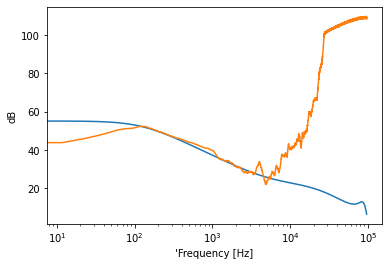

GA Process:6700/10000, Loss:0.07796653
GA Process:6701/10000, Loss:0.07796653
GA Process:6702/10000, Loss:0.07796653
GA Process:6703/10000, Loss:0.07796653
GA Process:6704/10000, Loss:0.07796653
GA Process:6705/10000, Loss:0.07796653
GA Process:6706/10000, Loss:0.07796653
GA Process:6707/10000, Loss:0.07796653
GA Process:6708/10000, Loss:0.07796653
GA Process:6709/10000, Loss:0.07796653
GA Process:6710/10000, Loss:0.07796653
GA Process:6711/10000, Loss:0.07796653
GA Process:6712/10000, Loss:0.07796653
GA Process:6713/10000, Loss:0.07796653
GA Process:6714/10000, Loss:0.07796653
GA Process:6715/10000, Loss:0.07796653
GA Process:6716/10000, Loss:0.07796653
GA Process:6717/10000, Loss:0.07796653
GA Process:6718/10000, Loss:0.07796653
GA Process:6719/10000, Loss:0.07796653
GA Process:6720/10000, Loss:0.07796653
GA Process:6721/10000, Loss:0.07796653
GA Process:6722/10000, Loss:0.07796653
GA Process:6723/10000, Loss:0.07796653
GA Process:6724/10000, Loss:0.07796653
GA Process:6725/10000, Lo

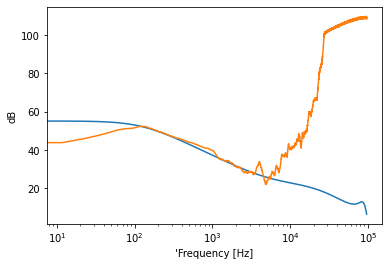

GA Process:6800/10000, Loss:0.07796653
GA Process:6801/10000, Loss:0.07796653
GA Process:6802/10000, Loss:0.07796653
GA Process:6803/10000, Loss:0.07796653
GA Process:6804/10000, Loss:0.07796653
GA Process:6805/10000, Loss:0.07796653
GA Process:6806/10000, Loss:0.07796653
GA Process:6807/10000, Loss:0.07796653
GA Process:6808/10000, Loss:0.07796653
GA Process:6809/10000, Loss:0.07796653
GA Process:6810/10000, Loss:0.07796653
GA Process:6811/10000, Loss:0.07796653
GA Process:6812/10000, Loss:0.07796653
GA Process:6813/10000, Loss:0.07796653
GA Process:6814/10000, Loss:0.07796653
GA Process:6815/10000, Loss:0.07796653
GA Process:6816/10000, Loss:0.07796653
GA Process:6817/10000, Loss:0.07796653
GA Process:6818/10000, Loss:0.07796653
GA Process:6819/10000, Loss:0.07796653
GA Process:6820/10000, Loss:0.07796653
GA Process:6821/10000, Loss:0.07796653
GA Process:6822/10000, Loss:0.07796653
GA Process:6823/10000, Loss:0.07796653
GA Process:6824/10000, Loss:0.07796653
GA Process:6825/10000, Lo

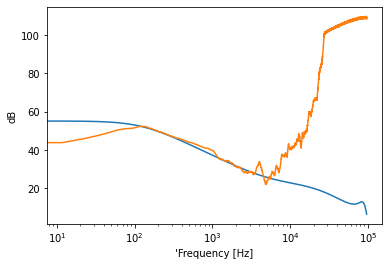

GA Process:6900/10000, Loss:0.07796653
GA Process:6901/10000, Loss:0.07796653
GA Process:6902/10000, Loss:0.07796653
GA Process:6903/10000, Loss:0.07796653
GA Process:6904/10000, Loss:0.07796653
GA Process:6905/10000, Loss:0.07796653
GA Process:6906/10000, Loss:0.07796653
GA Process:6907/10000, Loss:0.07796653
GA Process:6908/10000, Loss:0.07796653
GA Process:6909/10000, Loss:0.07796653
GA Process:6910/10000, Loss:0.07796653
GA Process:6911/10000, Loss:0.07796653
GA Process:6912/10000, Loss:0.07796653
GA Process:6913/10000, Loss:0.07796653
GA Process:6914/10000, Loss:0.07796653
GA Process:6915/10000, Loss:0.07796653
GA Process:6916/10000, Loss:0.07796653
GA Process:6917/10000, Loss:0.07796653
GA Process:6918/10000, Loss:0.07796653
GA Process:6919/10000, Loss:0.07796653
GA Process:6920/10000, Loss:0.07796653
GA Process:6921/10000, Loss:0.07796653
GA Process:6922/10000, Loss:0.07796653
GA Process:6923/10000, Loss:0.07796653
GA Process:6924/10000, Loss:0.07796653
GA Process:6925/10000, Lo

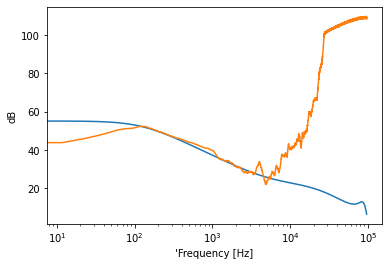

GA Process:7000/10000, Loss:0.07796653
GA Process:7001/10000, Loss:0.07796653
GA Process:7002/10000, Loss:0.07796653
GA Process:7003/10000, Loss:0.07796653
GA Process:7004/10000, Loss:0.07796653
GA Process:7005/10000, Loss:0.07796653
GA Process:7006/10000, Loss:0.07796653
GA Process:7007/10000, Loss:0.07796653
GA Process:7008/10000, Loss:0.07796653
GA Process:7009/10000, Loss:0.07796653
GA Process:7010/10000, Loss:0.07796653
GA Process:7011/10000, Loss:0.07796653
GA Process:7012/10000, Loss:0.07796653
GA Process:7013/10000, Loss:0.07796653
GA Process:7014/10000, Loss:0.07796653
GA Process:7015/10000, Loss:0.07796653
GA Process:7016/10000, Loss:0.07796653
GA Process:7017/10000, Loss:0.07796653
GA Process:7018/10000, Loss:0.07796653
GA Process:7019/10000, Loss:0.07796653
GA Process:7020/10000, Loss:0.07796653
GA Process:7021/10000, Loss:0.07796653
GA Process:7022/10000, Loss:0.07796653
GA Process:7023/10000, Loss:0.07796653
GA Process:7024/10000, Loss:0.07796653
GA Process:7025/10000, Lo

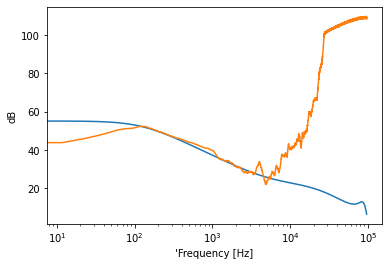

GA Process:7100/10000, Loss:0.07796653
GA Process:7101/10000, Loss:0.07796653
GA Process:7102/10000, Loss:0.07796653
GA Process:7103/10000, Loss:0.07796653
GA Process:7104/10000, Loss:0.07796653
GA Process:7105/10000, Loss:0.07796653
GA Process:7106/10000, Loss:0.07796653
GA Process:7107/10000, Loss:0.07796653
GA Process:7108/10000, Loss:0.07796653
GA Process:7109/10000, Loss:0.07796653
GA Process:7110/10000, Loss:0.07796653
GA Process:7111/10000, Loss:0.07796653
GA Process:7112/10000, Loss:0.07796653
GA Process:7113/10000, Loss:0.07796653
GA Process:7114/10000, Loss:0.07796653
GA Process:7115/10000, Loss:0.07796653
GA Process:7116/10000, Loss:0.07796653
GA Process:7117/10000, Loss:0.07796653
GA Process:7118/10000, Loss:0.07796653
GA Process:7119/10000, Loss:0.07796653
GA Process:7120/10000, Loss:0.07796653
GA Process:7121/10000, Loss:0.07796653
GA Process:7122/10000, Loss:0.07796653
GA Process:7123/10000, Loss:0.07796653
GA Process:7124/10000, Loss:0.07796653
GA Process:7125/10000, Lo

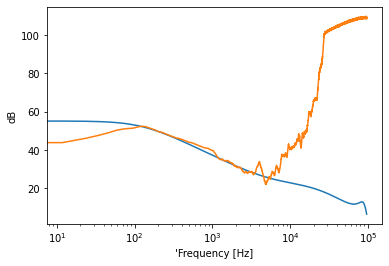

GA Process:7200/10000, Loss:0.07796653
GA Process:7201/10000, Loss:0.07796653
GA Process:7202/10000, Loss:0.07796653
GA Process:7203/10000, Loss:0.07796653
GA Process:7204/10000, Loss:0.07796653
GA Process:7205/10000, Loss:0.07796653
GA Process:7206/10000, Loss:0.07796653
GA Process:7207/10000, Loss:0.07796653
GA Process:7208/10000, Loss:0.07796653
GA Process:7209/10000, Loss:0.07796653
GA Process:7210/10000, Loss:0.07796653
GA Process:7211/10000, Loss:0.07796653
GA Process:7212/10000, Loss:0.07796653
GA Process:7213/10000, Loss:0.07796653
GA Process:7214/10000, Loss:0.07796653
GA Process:7215/10000, Loss:0.07796653
GA Process:7216/10000, Loss:0.07796653
GA Process:7217/10000, Loss:0.07796653
GA Process:7218/10000, Loss:0.07796653
GA Process:7219/10000, Loss:0.07796653
GA Process:7220/10000, Loss:0.07796653
GA Process:7221/10000, Loss:0.07796653
GA Process:7222/10000, Loss:0.07796653
GA Process:7223/10000, Loss:0.07796653
GA Process:7224/10000, Loss:0.07796653
GA Process:7225/10000, Lo

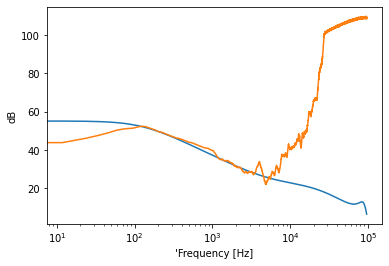

GA Process:7300/10000, Loss:0.07796653
GA Process:7301/10000, Loss:0.07796653
GA Process:7302/10000, Loss:0.07796653
GA Process:7303/10000, Loss:0.07796653
GA Process:7304/10000, Loss:0.07796653
GA Process:7305/10000, Loss:0.07796653
GA Process:7306/10000, Loss:0.07796653
GA Process:7307/10000, Loss:0.07796653
GA Process:7308/10000, Loss:0.07796653
GA Process:7309/10000, Loss:0.07796653
GA Process:7310/10000, Loss:0.07796653
GA Process:7311/10000, Loss:0.07796653
GA Process:7312/10000, Loss:0.07796653
GA Process:7313/10000, Loss:0.07796653
GA Process:7314/10000, Loss:0.07796653
GA Process:7315/10000, Loss:0.07796653
GA Process:7316/10000, Loss:0.07796653
GA Process:7317/10000, Loss:0.07796653
GA Process:7318/10000, Loss:0.07796653
GA Process:7319/10000, Loss:0.07796653
GA Process:7320/10000, Loss:0.07796653
GA Process:7321/10000, Loss:0.07796653
GA Process:7322/10000, Loss:0.07796653
GA Process:7323/10000, Loss:0.07796653
GA Process:7324/10000, Loss:0.07796653
GA Process:7325/10000, Lo

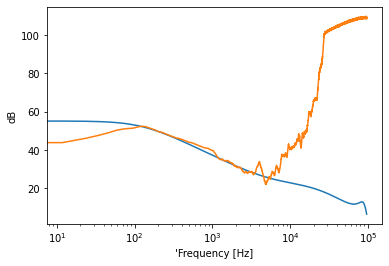

GA Process:7400/10000, Loss:0.07796653
GA Process:7401/10000, Loss:0.07796653
GA Process:7402/10000, Loss:0.07796653
GA Process:7403/10000, Loss:0.07796653
GA Process:7404/10000, Loss:0.07796653
GA Process:7405/10000, Loss:0.07796653
GA Process:7406/10000, Loss:0.07796653
GA Process:7407/10000, Loss:0.07796653
GA Process:7408/10000, Loss:0.07796653
GA Process:7409/10000, Loss:0.07796653
GA Process:7410/10000, Loss:0.07796653
GA Process:7411/10000, Loss:0.07796653
GA Process:7412/10000, Loss:0.07796653
GA Process:7413/10000, Loss:0.07796653
GA Process:7414/10000, Loss:0.07796653
GA Process:7415/10000, Loss:0.07796653
GA Process:7416/10000, Loss:0.07796653
GA Process:7417/10000, Loss:0.07796653
GA Process:7418/10000, Loss:0.07796653
GA Process:7419/10000, Loss:0.07796653
GA Process:7420/10000, Loss:0.07796653
GA Process:7421/10000, Loss:0.07796653
GA Process:7422/10000, Loss:0.07796653
GA Process:7423/10000, Loss:0.07796653
GA Process:7424/10000, Loss:0.07796653
GA Process:7425/10000, Lo

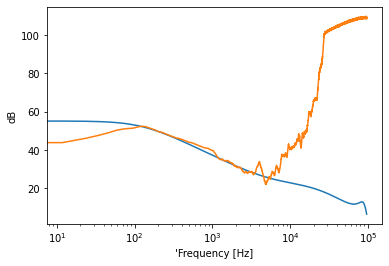

GA Process:7500/10000, Loss:0.07796653
GA Process:7501/10000, Loss:0.07796653
GA Process:7502/10000, Loss:0.07796653
GA Process:7503/10000, Loss:0.07796653
GA Process:7504/10000, Loss:0.07796653
GA Process:7505/10000, Loss:0.07796653
GA Process:7506/10000, Loss:0.07796653
GA Process:7507/10000, Loss:0.07796653
GA Process:7508/10000, Loss:0.07796653
GA Process:7509/10000, Loss:0.07796653
GA Process:7510/10000, Loss:0.07796653
GA Process:7511/10000, Loss:0.07796653
GA Process:7512/10000, Loss:0.07796653
GA Process:7513/10000, Loss:0.07796653
GA Process:7514/10000, Loss:0.07796653
GA Process:7515/10000, Loss:0.07796653
GA Process:7516/10000, Loss:0.07796653
GA Process:7517/10000, Loss:0.07796653
GA Process:7518/10000, Loss:0.07796653
GA Process:7519/10000, Loss:0.07796653
GA Process:7520/10000, Loss:0.07796653
GA Process:7521/10000, Loss:0.07796653
GA Process:7522/10000, Loss:0.07796653
GA Process:7523/10000, Loss:0.07796653
GA Process:7524/10000, Loss:0.07796653
GA Process:7525/10000, Lo

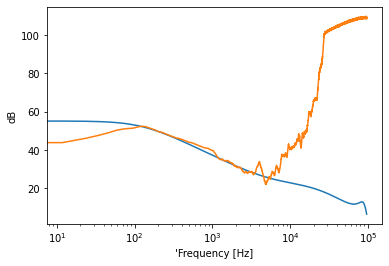

GA Process:7600/10000, Loss:0.07796653
GA Process:7601/10000, Loss:0.07796653
GA Process:7602/10000, Loss:0.07796653
GA Process:7603/10000, Loss:0.07796653
GA Process:7604/10000, Loss:0.07796653
GA Process:7605/10000, Loss:0.07796653
GA Process:7606/10000, Loss:0.07796653
GA Process:7607/10000, Loss:0.07796653
GA Process:7608/10000, Loss:0.07796653
GA Process:7609/10000, Loss:0.07796653
GA Process:7610/10000, Loss:0.07796653
GA Process:7611/10000, Loss:0.07796653
GA Process:7612/10000, Loss:0.07796653
GA Process:7613/10000, Loss:0.07796653
GA Process:7614/10000, Loss:0.07796653
GA Process:7615/10000, Loss:0.07796653
GA Process:7616/10000, Loss:0.07796653
GA Process:7617/10000, Loss:0.07796653
GA Process:7618/10000, Loss:0.07796653
GA Process:7619/10000, Loss:0.07796653
GA Process:7620/10000, Loss:0.07796653
GA Process:7621/10000, Loss:0.07796653
GA Process:7622/10000, Loss:0.07796653
GA Process:7623/10000, Loss:0.07796653
GA Process:7624/10000, Loss:0.07796653
GA Process:7625/10000, Lo

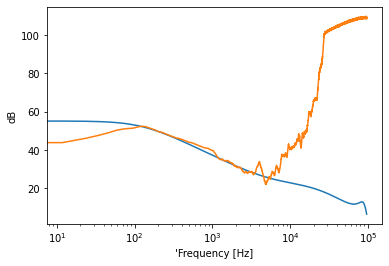

GA Process:7700/10000, Loss:0.07796653
GA Process:7701/10000, Loss:0.07796653
GA Process:7702/10000, Loss:0.07796653
GA Process:7703/10000, Loss:0.07796653
GA Process:7704/10000, Loss:0.07796653
GA Process:7705/10000, Loss:0.07796653
GA Process:7706/10000, Loss:0.07796653
GA Process:7707/10000, Loss:0.07796653
GA Process:7708/10000, Loss:0.07796653
GA Process:7709/10000, Loss:0.07796653
GA Process:7710/10000, Loss:0.07796653
GA Process:7711/10000, Loss:0.07796653
GA Process:7712/10000, Loss:0.07796653
GA Process:7713/10000, Loss:0.07796653
GA Process:7714/10000, Loss:0.07796653
GA Process:7715/10000, Loss:0.07796653
GA Process:7716/10000, Loss:0.07796653
GA Process:7717/10000, Loss:0.07796653
GA Process:7718/10000, Loss:0.07796653
GA Process:7719/10000, Loss:0.07796653
GA Process:7720/10000, Loss:0.07796653
GA Process:7721/10000, Loss:0.07796653
GA Process:7722/10000, Loss:0.07796653
GA Process:7723/10000, Loss:0.07796653
GA Process:7724/10000, Loss:0.07796653
GA Process:7725/10000, Lo

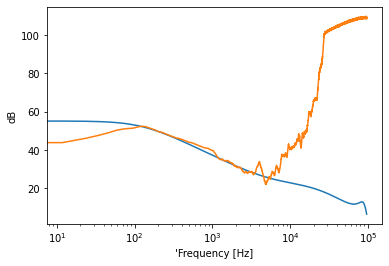

GA Process:7800/10000, Loss:0.07796653
GA Process:7801/10000, Loss:0.07796653
GA Process:7802/10000, Loss:0.07796653
GA Process:7803/10000, Loss:0.07796653
GA Process:7804/10000, Loss:0.07796653
GA Process:7805/10000, Loss:0.07796653
GA Process:7806/10000, Loss:0.07796653
GA Process:7807/10000, Loss:0.07796653
GA Process:7808/10000, Loss:0.07796653
GA Process:7809/10000, Loss:0.07796653
GA Process:7810/10000, Loss:0.07796653
GA Process:7811/10000, Loss:0.07796653
GA Process:7812/10000, Loss:0.07796653
GA Process:7813/10000, Loss:0.07796653
GA Process:7814/10000, Loss:0.07796653
GA Process:7815/10000, Loss:0.07796653
GA Process:7816/10000, Loss:0.07796653
GA Process:7817/10000, Loss:0.07796653
GA Process:7818/10000, Loss:0.07796653
GA Process:7819/10000, Loss:0.07796653
GA Process:7820/10000, Loss:0.07796653
GA Process:7821/10000, Loss:0.07796653
GA Process:7822/10000, Loss:0.07796653
GA Process:7823/10000, Loss:0.07796653
GA Process:7824/10000, Loss:0.07796653
GA Process:7825/10000, Lo

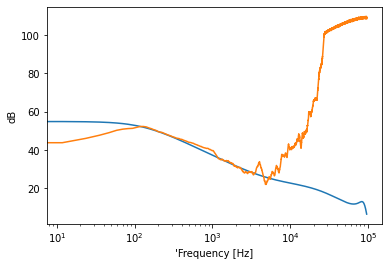

GA Process:7900/10000, Loss:0.07795804
GA Process:7901/10000, Loss:0.07795804
GA Process:7902/10000, Loss:0.07795804
GA Process:7903/10000, Loss:0.07795804
GA Process:7904/10000, Loss:0.07795804
GA Process:7905/10000, Loss:0.07795804
GA Process:7906/10000, Loss:0.07795804
GA Process:7907/10000, Loss:0.07795804
GA Process:7908/10000, Loss:0.07795793
GA Process:7909/10000, Loss:0.07795793
GA Process:7910/10000, Loss:0.07795793
GA Process:7911/10000, Loss:0.07795793
GA Process:7912/10000, Loss:0.07795793
GA Process:7913/10000, Loss:0.07795793
GA Process:7914/10000, Loss:0.07795793
GA Process:7915/10000, Loss:0.07795786
GA Process:7916/10000, Loss:0.07795786
GA Process:7917/10000, Loss:0.07795786
GA Process:7918/10000, Loss:0.07795786
GA Process:7919/10000, Loss:0.07795786
GA Process:7920/10000, Loss:0.07795786
GA Process:7921/10000, Loss:0.07795786
GA Process:7922/10000, Loss:0.07795786
GA Process:7923/10000, Loss:0.07795786
GA Process:7924/10000, Loss:0.07795786
GA Process:7925/10000, Lo

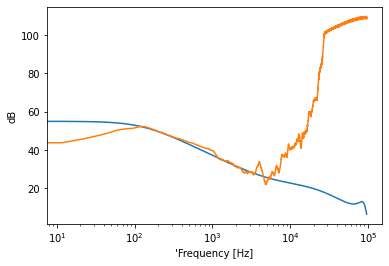

GA Process:8000/10000, Loss:0.07795074
GA Process:8001/10000, Loss:0.07795074
GA Process:8002/10000, Loss:0.07795074
GA Process:8003/10000, Loss:0.07795074
GA Process:8004/10000, Loss:0.07795074
GA Process:8005/10000, Loss:0.07795062
GA Process:8006/10000, Loss:0.07795062
GA Process:8007/10000, Loss:0.07795062
GA Process:8008/10000, Loss:0.07795062
GA Process:8009/10000, Loss:0.07795062
GA Process:8010/10000, Loss:0.07795062
GA Process:8011/10000, Loss:0.07795062
GA Process:8012/10000, Loss:0.07795062
GA Process:8013/10000, Loss:0.07795062
GA Process:8014/10000, Loss:0.07795062
GA Process:8015/10000, Loss:0.07795062
GA Process:8016/10000, Loss:0.07795062
GA Process:8017/10000, Loss:0.07795062
GA Process:8018/10000, Loss:0.07795062
GA Process:8019/10000, Loss:0.07795062
GA Process:8020/10000, Loss:0.07795062
GA Process:8021/10000, Loss:0.07795062
GA Process:8022/10000, Loss:0.07795062
GA Process:8023/10000, Loss:0.07795062
GA Process:8024/10000, Loss:0.07795062
GA Process:8025/10000, Lo

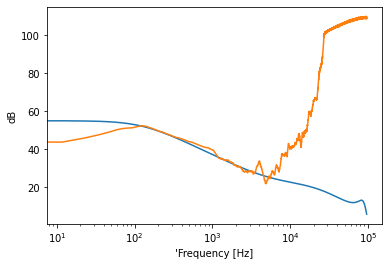

GA Process:8100/10000, Loss:0.07795061
GA Process:8101/10000, Loss:0.07795061
GA Process:8102/10000, Loss:0.07795061
GA Process:8103/10000, Loss:0.07795061
GA Process:8104/10000, Loss:0.07795061
GA Process:8105/10000, Loss:0.07795061
GA Process:8106/10000, Loss:0.07795061
GA Process:8107/10000, Loss:0.07795061
GA Process:8108/10000, Loss:0.07795061
GA Process:8109/10000, Loss:0.07795061
GA Process:8110/10000, Loss:0.07795061
GA Process:8111/10000, Loss:0.07795061
GA Process:8112/10000, Loss:0.07795061
GA Process:8113/10000, Loss:0.07795061
GA Process:8114/10000, Loss:0.07795061
GA Process:8115/10000, Loss:0.07795061
GA Process:8116/10000, Loss:0.07795061
GA Process:8117/10000, Loss:0.07795061
GA Process:8118/10000, Loss:0.07795061
GA Process:8119/10000, Loss:0.07795061
GA Process:8120/10000, Loss:0.07795061
GA Process:8121/10000, Loss:0.07795061
GA Process:8122/10000, Loss:0.07795061
GA Process:8123/10000, Loss:0.07795061
GA Process:8124/10000, Loss:0.07795061
GA Process:8125/10000, Lo

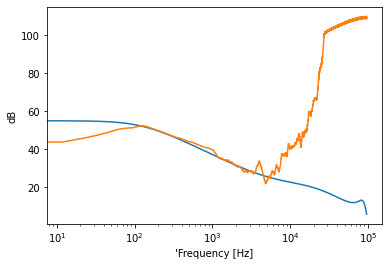

GA Process:8200/10000, Loss:0.07795061
GA Process:8201/10000, Loss:0.07795061
GA Process:8202/10000, Loss:0.07795061
GA Process:8203/10000, Loss:0.07795061
GA Process:8204/10000, Loss:0.07795061
GA Process:8205/10000, Loss:0.07795061
GA Process:8206/10000, Loss:0.07795061
GA Process:8207/10000, Loss:0.07795061
GA Process:8208/10000, Loss:0.07795061
GA Process:8209/10000, Loss:0.07795061
GA Process:8210/10000, Loss:0.07795061
GA Process:8211/10000, Loss:0.07795061
GA Process:8212/10000, Loss:0.07795061
GA Process:8213/10000, Loss:0.07795061
GA Process:8214/10000, Loss:0.07795061
GA Process:8215/10000, Loss:0.07795061
GA Process:8216/10000, Loss:0.07795061
GA Process:8217/10000, Loss:0.07795061
GA Process:8218/10000, Loss:0.07795061
GA Process:8219/10000, Loss:0.07795061
GA Process:8220/10000, Loss:0.07795061
GA Process:8221/10000, Loss:0.07795061
GA Process:8222/10000, Loss:0.07795061
GA Process:8223/10000, Loss:0.07795061
GA Process:8224/10000, Loss:0.07795061
GA Process:8225/10000, Lo

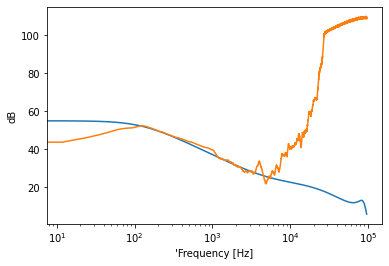

GA Process:8300/10000, Loss:0.07795058
GA Process:8301/10000, Loss:0.07795058
GA Process:8302/10000, Loss:0.07795058
GA Process:8303/10000, Loss:0.07795058
GA Process:8304/10000, Loss:0.07795058
GA Process:8305/10000, Loss:0.07795058
GA Process:8306/10000, Loss:0.07795058
GA Process:8307/10000, Loss:0.07795058
GA Process:8308/10000, Loss:0.07795058
GA Process:8309/10000, Loss:0.07795058
GA Process:8310/10000, Loss:0.07795058
GA Process:8311/10000, Loss:0.07795058
GA Process:8312/10000, Loss:0.07795058
GA Process:8313/10000, Loss:0.07795058
GA Process:8314/10000, Loss:0.07795058
GA Process:8315/10000, Loss:0.07795058
GA Process:8316/10000, Loss:0.07795058
GA Process:8317/10000, Loss:0.07795058
GA Process:8318/10000, Loss:0.07795058
GA Process:8319/10000, Loss:0.07795058
GA Process:8320/10000, Loss:0.07795058
GA Process:8321/10000, Loss:0.07795058
GA Process:8322/10000, Loss:0.07795058
GA Process:8323/10000, Loss:0.07795058
GA Process:8324/10000, Loss:0.07795058
GA Process:8325/10000, Lo

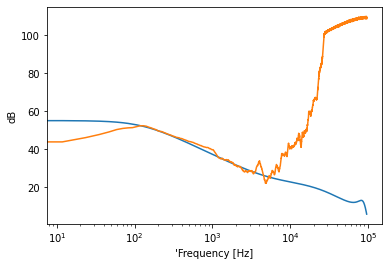

GA Process:8400/10000, Loss:0.07795055
GA Process:8401/10000, Loss:0.07795055
GA Process:8402/10000, Loss:0.07795055
GA Process:8403/10000, Loss:0.07795055
GA Process:8404/10000, Loss:0.07795055
GA Process:8405/10000, Loss:0.07795055
GA Process:8406/10000, Loss:0.07795055
GA Process:8407/10000, Loss:0.07795055
GA Process:8408/10000, Loss:0.07795055
GA Process:8409/10000, Loss:0.07795055
GA Process:8410/10000, Loss:0.07795055
GA Process:8411/10000, Loss:0.07795055
GA Process:8412/10000, Loss:0.07795055
GA Process:8413/10000, Loss:0.07795055
GA Process:8414/10000, Loss:0.07795055
GA Process:8415/10000, Loss:0.07795055
GA Process:8416/10000, Loss:0.07795055
GA Process:8417/10000, Loss:0.07795055
GA Process:8418/10000, Loss:0.07795055
GA Process:8419/10000, Loss:0.07795055
GA Process:8420/10000, Loss:0.07795055
GA Process:8421/10000, Loss:0.07795055
GA Process:8422/10000, Loss:0.07795055
GA Process:8423/10000, Loss:0.07795055
GA Process:8424/10000, Loss:0.07795055
GA Process:8425/10000, Lo

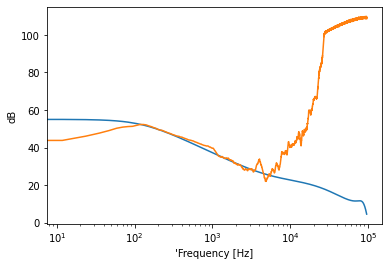

GA Process:8500/10000, Loss:0.07795048
GA Process:8501/10000, Loss:0.07795048
GA Process:8502/10000, Loss:0.07795048
GA Process:8503/10000, Loss:0.07795048
GA Process:8504/10000, Loss:0.07795048
GA Process:8505/10000, Loss:0.07795048
GA Process:8506/10000, Loss:0.07795048
GA Process:8507/10000, Loss:0.07795048
GA Process:8508/10000, Loss:0.07795048
GA Process:8509/10000, Loss:0.07795048
GA Process:8510/10000, Loss:0.07795048
GA Process:8511/10000, Loss:0.07795048
GA Process:8512/10000, Loss:0.07795048
GA Process:8513/10000, Loss:0.07795048
GA Process:8514/10000, Loss:0.07795048
GA Process:8515/10000, Loss:0.07795048
GA Process:8516/10000, Loss:0.07795048
GA Process:8517/10000, Loss:0.07795048
GA Process:8518/10000, Loss:0.07795048
GA Process:8519/10000, Loss:0.07795048
GA Process:8520/10000, Loss:0.07795048
GA Process:8521/10000, Loss:0.07795048
GA Process:8522/10000, Loss:0.07795048
GA Process:8523/10000, Loss:0.07795048
GA Process:8524/10000, Loss:0.07795048
GA Process:8525/10000, Lo

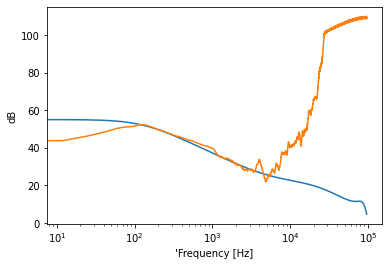

GA Process:8600/10000, Loss:0.07795039
GA Process:8601/10000, Loss:0.07795039
GA Process:8602/10000, Loss:0.07795039
GA Process:8603/10000, Loss:0.07795039
GA Process:8604/10000, Loss:0.07795039
GA Process:8605/10000, Loss:0.07795039
GA Process:8606/10000, Loss:0.07795039
GA Process:8607/10000, Loss:0.07795039
GA Process:8608/10000, Loss:0.07795039
GA Process:8609/10000, Loss:0.07795039
GA Process:8610/10000, Loss:0.07795039
GA Process:8611/10000, Loss:0.07795039
GA Process:8612/10000, Loss:0.07795039
GA Process:8613/10000, Loss:0.07795039
GA Process:8614/10000, Loss:0.07795039
GA Process:8615/10000, Loss:0.07795039
GA Process:8616/10000, Loss:0.07795039
GA Process:8617/10000, Loss:0.07795039
GA Process:8618/10000, Loss:0.07795039
GA Process:8619/10000, Loss:0.07795039
GA Process:8620/10000, Loss:0.07795039
GA Process:8621/10000, Loss:0.07795039
GA Process:8622/10000, Loss:0.07795039
GA Process:8623/10000, Loss:0.07795039
GA Process:8624/10000, Loss:0.07795039
GA Process:8625/10000, Lo

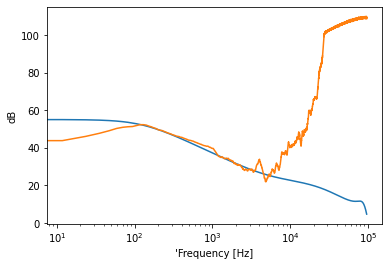

GA Process:8700/10000, Loss:0.07795036
GA Process:8701/10000, Loss:0.07795036
GA Process:8702/10000, Loss:0.07795036
GA Process:8703/10000, Loss:0.07795036
GA Process:8704/10000, Loss:0.07795036
GA Process:8705/10000, Loss:0.07795036
GA Process:8706/10000, Loss:0.07795036
GA Process:8707/10000, Loss:0.07795036
GA Process:8708/10000, Loss:0.07795036
GA Process:8709/10000, Loss:0.07795036
GA Process:8710/10000, Loss:0.07795036
GA Process:8711/10000, Loss:0.07795035
GA Process:8712/10000, Loss:0.07795035
GA Process:8713/10000, Loss:0.07795035
GA Process:8714/10000, Loss:0.07795035
GA Process:8715/10000, Loss:0.07795035
GA Process:8716/10000, Loss:0.07795035
GA Process:8717/10000, Loss:0.07795035
GA Process:8718/10000, Loss:0.07795035
GA Process:8719/10000, Loss:0.07795035
GA Process:8720/10000, Loss:0.07795035
GA Process:8721/10000, Loss:0.07795035
GA Process:8722/10000, Loss:0.07795035
GA Process:8723/10000, Loss:0.07795035
GA Process:8724/10000, Loss:0.07795035
GA Process:8725/10000, Lo

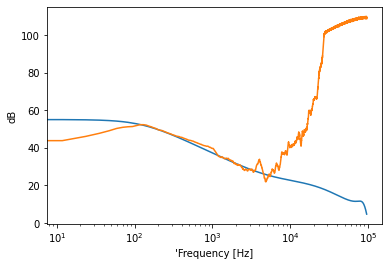

GA Process:8800/10000, Loss:0.07795033
GA Process:8801/10000, Loss:0.07795033
GA Process:8802/10000, Loss:0.07795033
GA Process:8803/10000, Loss:0.07795033
GA Process:8804/10000, Loss:0.07795033
GA Process:8805/10000, Loss:0.07795033
GA Process:8806/10000, Loss:0.07795033
GA Process:8807/10000, Loss:0.07795033
GA Process:8808/10000, Loss:0.07794913
GA Process:8809/10000, Loss:0.07794913
GA Process:8810/10000, Loss:0.07794913
GA Process:8811/10000, Loss:0.07794913
GA Process:8812/10000, Loss:0.07794913
GA Process:8813/10000, Loss:0.07794913
GA Process:8814/10000, Loss:0.07794913
GA Process:8815/10000, Loss:0.07794913
GA Process:8816/10000, Loss:0.07794913
GA Process:8817/10000, Loss:0.07794913
GA Process:8818/10000, Loss:0.07794913
GA Process:8819/10000, Loss:0.07794913
GA Process:8820/10000, Loss:0.07794913
GA Process:8821/10000, Loss:0.07794913
GA Process:8822/10000, Loss:0.07794913
GA Process:8823/10000, Loss:0.07794913
GA Process:8824/10000, Loss:0.07794913
GA Process:8825/10000, Lo

In [ ]:
# polystab finds the roots of the polynomial and maps those roots found outside the unit circle to the inside of the unit circle:
def PolyStab(a):
    v = np.roots(a)
    sign = 0.5*(np.sign(np.abs(v)-1)+1) #判断根是否在单位圆内，在0，不在1
    v = (1-sign)*v + sign/np.conj(v)
    new_a = a[0]*np.poly(v)
#     print(v)
    return new_a
#GA算法测试，直接写脚本
#带约束的单目标优化问题
import time
import numpy as np 
import geatpy as ea
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self, PPSP, biquadNums, NIND, MAXGEN, targetDim=1):
        name = 'MyGA' # 初始化name（函数名称，可以随意设置）
        M = targetDim # 初始化M（目标维数）
        maxormins = np.array([1] * M) # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = biquadNums*5 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [-2] * Dim # 决策变量下界
        ub = [2] * Dim # 决策变量上界
        lbin = [0] * Dim # 决策变量下边界, 1表示包含范围的边界，0表示不包含
        ubin = [0] * Dim # 决策变量上边界, 1表示包含范围的边界，0表示不包含       
        
        Encoding = 'BG'                # 'BG'表示采用二进制/格雷编码
        codes = [0] * Dim                    # 变量的编码方式，2个变量均使用格雷编码
        precisions =[4] * Dim                # 变量的编码精度
        scales = [0] * Dim                   # 采用算术刻度
        ranges = np.array([lb, ub])       # 生成自变量的范围矩阵
        borders = np.array([lbin, ubin])      # 生成自变量的边界矩阵

#         """=========================遗传算法参数设置========================="""
#         print(varTypes)
#         print(codes)
#         print(precisions)
#         print(scales)
#         print(ranges)
#         print(borders)
        FieldD = ea.crtfld(Encoding,varTypes,ranges,borders,precisions,codes,scales) # 调用函数创建区域描述器
#         print(FieldD[0, :])
        Lind = int(np.sum(FieldD[0, :]))          # 计算编码后的染色体长度
        pc = 0.9
        pm = 1/Lind
        obj_trace = np.zeros((MAXGEN, 2))         # 定义目标函数值记录器
        var_trace = np.zeros((MAXGEN, Lind))      # 定义染色体记录器，记录每一代最优个体的染色体
        
        
#"""=========================开始遗传算法进化========================"""
        start_time = time.time()                             # 开始计时
        Chrom = ea.crtpc(Encoding, NIND, FieldD)                         # 生成种群染色体矩阵
        variable = ea.bs2ri(Chrom, FieldD)                 # 对初始种群进行解码
        variable = self.PolyCheckAll(variable) #转换为最小相位系统
        Chrom = ea.ri2bs(variable, FieldD)
        ObjV = self.ObjFunc(variable, PPSP)                # 计算初始种群个体的目标函数值
        best_ind = np.argmin(ObjV)                           # 计算当代最优个体的序号
#         print(ObjV)
#         print(ObjV.shape)
        # 开始进化
#         help(ea.mutbin)
        for gen in range(MAXGEN):
            FitnV = ea.ranking(maxormins*ObjV)                        # 根据目标函数大小分配适应度值(由于遵循目标最小化约定，因此最大化问题要对目标函数值乘上-1)
            SelCh = Chrom[ea.selecting('rws', FitnV, NIND-1), :] # 选择，采用'rws'轮盘赌选择
            SelCh = ea.recombin('xovsp', SelCh, 0.7)           # 重组(采用两点交叉方式，交叉概率为0.7)
            SelCh = ea.mutate('mutbin', Encoding, SelCh, pm)                 # 二进制种群变异
            # 把父代精英个体与子代合并
            Chrom = np.vstack([Chrom[best_ind, :], SelCh])
            variable = ea.bs2ri(Chrom, FieldD)             # 对育种种群进行解码(二进制转十进制)
            variable = self.PolyCheckAll(variable) #转换为最小相位系统
#             Chrom = ea.ri2bs(variable, FieldD)
            ObjV = self.ObjFunc(variable, PPSP)                             # 求育种个体的目标函数值
            # 记录
            best_ind = np.argmin(ObjV)                       # 计算当代最优个体的序号
            obj_trace[gen, 0] = np.sum(ObjV) / NIND          # 记录当代种群的目标函数均值
            obj_trace[gen, 1] = ObjV[best_ind]               # 记录当代种群最优个体目标函数值
            var_trace[gen, :] = Chrom[best_ind, :]           # 记录当代种群最优个体的变量值
            if gen%100==0:
                filterSet = self.GAParam2BiquadSet(variable[best_ind])
                f, s = filterSet.SelfPlot()
                length = min(len(s), len(PPSP))
                fig, ax = plt.subplots(1, 1)
                ax.plot(f[:length], s[:length])
                ax.plot(f[:length], PPSP[:length])
                plt.xscale('log')
                plt.xlabel("'Frequency [Hz]")
                plt.ylabel("dB")
                plt.show()
            print("GA Process:{:d}/{:d}, Loss:{:.8f}".format(gen, MAXGEN, ObjV[best_ind][0]))
        # 进化完成
        end_time = time.time() # 结束计时
        bestVar = variable[best_ind]
        filterSet = self.GAParam2BiquadSet(variable[best_ind])
        f, s = filterSet.SelfPlot()
        length = min(len(s), len(PPSP))
        fig, ax = plt.subplots(1, 1)
        ax.plot(f[:length], s[:length])
        ax.plot(f[:length], PPSP[:length])
        plt.xscale('log')
        plt.xlabel("'Frequency [Hz]")
        plt.ylabel("dB")
        plt.show()
        
        index = range(MAXGEN)
        fig, ax = plt.subplots(1, 1)
        ax.plot(index, obj_trace[:, 0])
        ax.plot(index, obj_trace[:, 1])
        plt.xscale('log')
        plt.xlabel("'Frequency [Hz]")
        plt.ylabel("dB")
        plt.show()
              
#         # 调用父类构造方法完成实例化
#         ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    def GAParam2BiquadSet(self, variable_k):
        filterSet = FilterSet()
        for i in range(int(len(variable_k)//5)):
            numerator = np.array(variable_k[5*i:5*i+3])
            denominator = np.array([1, variable_k[5*i+3], variable_k[5*i+4]])
            param = [numerator, denominator]
            filter1 = IIRFilter('Biquad', param)
            filterSet.AddBiquad(filter1)
        return filterSet
                       
    def ObjFunc(self, variable, PPSP): #以PP/SP曲线作为目标
        ObjV = np.zeros((len(variable), 1))
        for k in range(len(variable)):
            filterSet = self. GAParam2BiquadSet(variable[k])
            f, s = filterSet.SelfPlot()
#             print(PPSP)
#             print(s)
            length = min(len(PPSP), len(s))
            delta =np.array(s[:length] - PPSP[:length])
            N50 = 5
            N300 = 30
            N1k = 100
            N5k = 500
            loss50to300 = np.sum(np.abs(delta[N50:N300])/length)
            loss1kto5k = np.sum(np.abs(delta[N1k:N5k])/length)
            ObjV[k, 0] = 2*loss50to300 + loss1kto5k   
#             print(ObjV)
        return np.array(ObjV)
    
    def PolyCheck(self, variable_i):
        for i in range(len(variable_i)//5):
#             print(variable_i[5*i:5*i+3])
#             print(variable_i[5*i+3:5*i+5])
            variable_i[5*i:5*i+3] = PolyStab(variable_i[5*i:5*i+3])
            variable_i[5*i+3:5*i+5] = PolyStab([1, variable_i[5*i+3], variable_i[5*i+4]])[1:]
        return variable_i
    
    def PolyCheckAll(self, variable):
        for i in range(len(variable)):
            variable[i] = self.PolyCheck(variable[i])
        return variable
        
biquadNums = 8
NIND = 100
MAXGEN = 10000
GAProblem = MyProblem(PPSP, biquadNums, NIND, MAXGEN)

In [ ]:
#使用GA模板
# -*- coding: utf-8 -*-
import numpy as np
import geatpy as ea
"""
问题类定义
"""
class MyProblem(ea.Problem): # 继承Problem父类
    def __init__(self, PPSP, biquadNums, targetDim=1):
        self.PPSP = PPSP
        name = 'MyGA' # 初始化name（函数名称，可以随意设置）
        M = targetDim # 初始化M（目标维数）
        maxormins = [1] * M # 初始化maxormins（目标最小最大化标记列表，1：最小化该目标；-1：最大化该目标）
        Dim = biquadNums*5 # 初始化Dim（决策变量维数）
        varTypes = np.array([0] * Dim) # 初始化varTypes（决策变量的类型，0：实数；1：整数）
        lb = [-2] * Dim # 决策变量下界
        ub = [2] * Dim # 决策变量上界
        lbin = [0] * Dim # 决策变量下边界, 1表示包含范围的边界，0表示不包含
        ubin = [0] * Dim # 决策变量上边界, 1表示包含范围的边界，0表示不包含       
                # 调用父类构造方法完成实例化
        ea.Problem.__init__(self, name, M, maxormins, Dim, varTypes, lb, ub, lbin, ubin)
    def aimFunc(self, pop): # 目标函数
        variable = pop.Phen #获取决策变量矩阵
        pop.ObjV = self.ObjFunc(variable, self.PPSP)
        print('aimFunc: ')
        print(pop.ObjV)
    def GAParam2BiquadSet(self, variable_k):
        filterSet = FilterSet()
        for i in range(int(len(variable_k)//5)):
            numerator = np.array(variable_k[5*i:5*i+3])
            denominator = np.array([1, variable_k[5*i+3], variable_k[5*i+4]])
            param = [numerator, denominator]
            filter1 = IIRFilter('Biquad', param)
            filterSet.AddBiquad(filter1)
        return filterSet
                       
    def ObjFunc(self, variable, PPSP): #以PP/SP曲线作为目标
        ObjV = np.zeros((len(variable), 1))
        for k in range(len(variable)):
            filterSet = self. GAParam2BiquadSet(variable[k])
            f, s = filterSet.SelfPlot()
            length = min(len(PPSP), len(s))
            delta =np.array(s[:length] - PPSP[:length])
            ObjV[k, 0] = (np.sum(np.abs(delta)/length))   
        return np.array(ObjV)
    
    def PolyCheck(self, variable_i):
        for i in range(len(variable_i)//5):
            variable_i[5*i:5*i+3] = PolyStab(variable_i[5*i:5*i+3])
            variable_i[5*i+3:5*i+5] = PolyStab([1, variable_i[5*i+3], variable_i[5*i+4]])[1:]
        return variable_i
    
    def PolyCheckAll(self, variable):
        for i in range(len(variable)):
            variable[i] = self.PolyCheck(variable[i])
        return variable
"""
执行脚本
"""
if __name__ == '__main__':
    try:
        problem = MyProblem(PPSP, 8)  # 生成问题对象
        # 构建算法
        algorithm = ea.moea_NSGA2_templet(problem,
                                      ea.Population(Encoding='RI', NIND=100),
                                      MAXGEN=100,  # 最大进化代数。
                                      logTras=0)  # 表示每隔多少代记录一次日志信息，0表示不记录。
        # 求解
        res = ea.optimize(algorithm, verbose=False, drawing=1, outputMsg=True, drawLog=False, saveFlag=False, dirName='result')
    except Exception as e:
        print(e)


# https://finthon.com/python-pso/

In [ ]:
# PSO算法
import numpy as np
import random

import random
import numpy as np
import matplotlib.pyplot as plt
 
 
class PSO:
    def __init__(self, parameters):
        """
        particle swarm optimization
        parameter: a list type, like [NGEN, pop_size, var_num_min, var_num_max]
        """
        # 初始化
        self.NGEN = parameters[0]    # 迭代的代数
        self.pop_size = parameters[1]    # 种群大小
        self.var_num = len(parameters[2])     # 变量个数
        self.bound = []                 # 变量的约束范围
        self.bound.append(parameters[2])
        self.bound.append(parameters[3])
 
        self.pop_x = np.zeros((self.pop_size, self.var_num))    # 所有粒子的位置
        self.pop_v = np.zeros((self.pop_size, self.var_num))    # 所有粒子的速度

 
        self.p_best = np.zeros((self.pop_size, self.var_num))   # 每个粒子最优的位置
        self.g_best = np.zeros((1, self.var_num))   # 全局最优的位置
 
        # 初始化第0代初始全局最优解
        temp = -1
        for i in range(self.pop_size):
            for j in range(self.var_num):
                self.pop_x[i][j] = random.uniform(self.bound[0][j], self.bound[1][j])
                self.pop_v[i][j] = random.uniform(0, 1)
            self.p_best[i] = self.pop_x[i]      # 储存最优的个体
            fit = self.fitness(self.p_best[i])
            if fit > temp:
                self.g_best = self.p_best[i]
                temp = fit
 
    def fitness(self, ind_var):
        """
        个体适应值计算
        """
        ObjV = np.zeros((len(variable), 1))
        for k in range(len(variable)):
            filterSet = self. GAParam2BiquadSet(variable[k])
            f, s = filterSet.SelfPlot()
#             print(PPSP)
#             print(s)
            length = min(len(PPSP), len(s))
            delta =np.array(s[:length] - PPSP[:length])
            N50 = 5
            N300 = 30
            N1k = 100
            N5k = 500
            loss50to300 = np.sum(np.abs(delta[N50:N300])/length)
            loss1kto5k = np.sum(np.abs(delta[N1k:N5k])/length)
            ObjV[k, 0] = 2*loss50to300 + loss1kto5k   
        return y
 
    def update_operator(self, pop_size):
        """
        更新算子：更新下一时刻的位置和速度
        """
        c1 = 2     # 学习因子，一般为2
        c2 = 2
        w = 0.4    # 自身权重因子
        for i in range(pop_size):
            # 更新速度
            self.pop_v[i] = w * self.pop_v[i] + c1 * random.uniform(0, 1) * (
                        self.p_best[i] - self.pop_x[i]) + c2 * random.uniform(0, 1) * (self.g_best - self.pop_x[i])
            # 更新位置
            self.pop_x[i] = self.pop_x[i] + self.pop_v[i]
            # 越界保护
            for j in range(self.var_num):
                if self.pop_x[i][j] < self.bound[0][j]:
                    self.pop_x[i][j] = self.bound[0][j]
                if self.pop_x[i][j] > self.bound[1][j]:
                    self.pop_x[i][j] = self.bound[1][j]
            # 更新p_best和g_best
            if self.fitness(self.pop_x[i]) > self.fitness(self.p_best[i]):
                self.p_best[i] = self.pop_x[i]
            if self.fitness(self.pop_x[i]) > self.fitness(self.g_best):
                self.g_best = self.pop_x[i]
 
    def main(self):
        popobj = []
        self.ng_best = np.zeros((1, self.var_num))[0]
        for gen in range(self.NGEN):
            self.update_operator(self.pop_size)
            popobj.append(self.fitness(self.g_best))
            print('############ Generation {} ############'.format(str(gen + 1)))
            if self.fitness(self.g_best) > self.fitness(self.ng_best):
                self.ng_best = self.g_best.copy()
            print('最好的位置：{}'.format(self.ng_best))
            print('最大的函数值：{}'.format(self.fitness(self.ng_best)))
        print("---- End of (successful) Searching ----")
 
        plt.figure()
        plt.title("Figure1")
        plt.xlabel("iterators", size=14)
        plt.ylabel("fitness", size=14)
        t = [t for t in range(self.NGEN)]
        plt.plot(t, popobj, color='b', linewidth=2)
        plt.show()
        
    def PolyCheck(self, variable_i):
        for i in range(len(variable_i)//5):
            variable_i[5*i:5*i+3] = PolyStab(variable_i[5*i:5*i+3])
            variable_i[5*i+3:5*i+5] = PolyStab([1, variable_i[5*i+3], variable_i[5*i+4]])[1:]
        return variable_i
    
    def PolyCheckAll(self, variable):
        for i in range(len(variable)):
            variable[i] = self.PolyCheck(variable[i])
        return variable
    
    def GAParam2BiquadSet(self, variable_k):
        filterSet = FilterSet()
        for i in range(int(len(variable_k)//5)):
            numerator = np.array(variable_k[5*i:5*i+3])
            denominator = np.array([1, variable_k[5*i+3], variable_k[5*i+4]])
            param = [numerator, denominator]
            filter1 = IIRFilter('Biquad', param)
            filterSet.AddBiquad(filter1)
        return filterSet
 
if __name__ == '__main__':
    NGEN = 100
    popsize = 100
    low = [1, 1, 1, 1]
    up = [30, 30, 30, 30]
    parameters = [NGEN, popsize, low, up]
    pso = PSO(parameters)
    pso.main()
    
